In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import seaborn as sns
import os

import scanpy as sc

from scipy import stats

from statannot import add_stat_annotation

from tqdm import tqdm

from joblib import Parallel, delayed

In [533]:
set1_proxi_df = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proxi_dfs\cd4\set1.csv', index_col=0)
set2_proxi_df = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proxi_dfs\cd4\set2.csv', index_col=0)
set3_proxi_df = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proxi_dfs\cd4\set3.csv', index_col=0)
set4_proxi_df = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proxi_dfs\cd4\set4.csv', index_col=0)

In [534]:
set1_patch_centers = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd4\set1_centers.csv', index_col=0)
set2_patch_centers = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd4\set2_centers.csv', index_col=0)
set3_patch_centers = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd4\set3_centers.csv', index_col=0)
set4_patch_centers = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd4\set4_centers.csv', index_col=0)

In [535]:
ki67 = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd4_ki67_intensity.csv', index_col=0)

In [536]:
scale = 249.6/2304
z_scale = 0.3

In [537]:
set1_ki67 = ki67[ki67['cellID'].isin(set1_patch_centers['cellID'])]
set2_ki67 = ki67[ki67['cellID'].isin(set2_patch_centers['cellID'])]
set3_ki67 = ki67[ki67['cellID'].isin(set3_patch_centers['cellID'])]
set4_ki67 = ki67[ki67['cellID'].isin(set4_patch_centers['cellID'])]

In [538]:
set1_proxi_df['patch_id'] = set1_patch_centers['patch_id'].tolist()
set1_proxi_df['cellID'] = set1_patch_centers['cellID'].tolist()

set2_proxi_df['patch_id'] = set2_patch_centers['patch_id'].tolist()
set2_proxi_df['cellID'] = set2_patch_centers['cellID'].tolist()

set3_proxi_df['patch_id'] = set3_patch_centers['patch_id'].tolist()
set3_proxi_df['cellID'] = set3_patch_centers['cellID'].tolist()

set4_proxi_df['patch_id'] = set4_patch_centers['patch_id'].tolist()
set4_proxi_df['cellID'] = set4_patch_centers['cellID'].tolist()

# Most central patch of each microenvironment

In [540]:
def central_proxi(patch_centers, sub_ki67, proxi):
    cells = sub_ki67['cellID'].tolist()
    centers_by_cell = patch_centers.groupby('cellID')
    central_patches = []
    for cell in tqdm(cells):
        centers_sub_df = centers_by_cell.get_group(cell)
        p_pos = np.stack((centers_sub_df['row'].to_numpy(),centers_sub_df['col'].to_numpy()),axis=1)
        cd4_center = np.array(sub_ki67[sub_ki67['cellID']==cell][['row','col']])
        dist = np.sqrt(np.sum((p_pos - cd4_center) ** 2, axis=1))
        sorted_idx = np.argsort(dist)
        sorted_idx = sorted_idx[::-1]
        central_patches.append(centers_sub_df.iloc[sorted_idx[:3]])
    central_patches = pd.concat(central_patches)
    central_proxi = proxi[proxi['patch_id'].isin(central_patches['patch_id'])]
    return central_patches,central_proxi

In [541]:
set1_central_patches, set1_central_proxi = central_proxi(set1_patch_centers, set1_ki67, set1_proxi_df)
set2_central_patches, set2_central_proxi = central_proxi(set2_patch_centers, set2_ki67, set2_proxi_df)
set3_central_patches, set3_central_proxi = central_proxi(set3_patch_centers, set3_ki67, set3_proxi_df)
set4_central_patches, set4_central_proxi = central_proxi(set4_patch_centers, set4_ki67, set4_proxi_df)

100%|██████████| 109/109 [00:00<00:00, 993.63it/s] 


In [542]:
set1_mean_central_proxi = set1_central_proxi.groupby('cellID').mean()
set2_mean_central_proxi = set2_central_proxi.groupby('cellID').mean()
set3_mean_central_proxi = set3_central_proxi.groupby('cellID').mean()
set4_mean_central_proxi = set4_central_proxi.groupby('cellID').mean()

# Find ki67+ and ki67- cells

In [2]:
from skimage.filters import threshold_otsu

In [544]:
thre = threshold_otsu(ki67['KI67'].to_numpy())

In [545]:
set1_ki67['KI67_label'] = set1_ki67['KI67'].tolist() > thre
set2_ki67['KI67_label'] = set2_ki67['KI67'].tolist() > thre
set3_ki67['KI67_label'] = set3_ki67['KI67'].tolist() > thre
set4_ki67['KI67_label'] = set4_ki67['KI67'].tolist() > thre

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\586892359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set1_ki67['KI67_label'] = set1_ki67['KI67'].tolist() > thre
C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\586892359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set2_ki67['KI67_label'] = set2_ki67['KI67'].tolist() > thre
C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\586892359.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [546]:
def fill_label(df, labels):
    fill_values = []
    for item in df['cellID'].tolist():
        v = labels[labels['cellID']==item]['KI67_label'].tolist()[0]
        if v:
            fill_values.append('KI67+')
        else:
            fill_values.append('KI67-')
    return fill_values

In [547]:
set1_mean_central_proxi['cellID'] = set1_mean_central_proxi.index
set2_mean_central_proxi['cellID'] = set2_mean_central_proxi.index
set3_mean_central_proxi['cellID'] = set3_mean_central_proxi.index
set4_mean_central_proxi['cellID'] = set4_mean_central_proxi.index

In [548]:
set1_mean_central_proxi['KI67_label'] = fill_label(set1_mean_central_proxi, set1_ki67)
set2_mean_central_proxi['KI67_label'] = fill_label(set2_mean_central_proxi, set2_ki67)
set3_mean_central_proxi['KI67_label'] = fill_label(set3_mean_central_proxi, set3_ki67)
set4_mean_central_proxi['KI67_label'] = fill_label(set4_mean_central_proxi, set4_ki67)

set1_mean_central_proxi.reset_index(drop=True,inplace=True)
set2_mean_central_proxi.reset_index(drop=True,inplace=True)
set3_mean_central_proxi.reset_index(drop=True,inplace=True)
set4_mean_central_proxi.reset_index(drop=True,inplace=True)

In [549]:
set1_proxi_only = set1_mean_central_proxi.drop(columns=['cellID','KI67_label'])
set1_stat = set1_proxi_only.melt(var_name='Gene Pair', value_name='Proximity')
set1_stat['KI67'] = set1_mean_central_proxi['KI67_label'].tolist() * set1_proxi_only.shape[1]

In [ ]:
cd4_central_proxi = pd.read_csv(r'')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ACTb_CD45_KI67- v.s. ACTb_CD45_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.233e-01 U_stat=2.032e+03
ACTb_IFNa_KI67- v.s. ACTb_IFNa_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.046e-01 U_stat=1.797e+03
ACTb_COL1A1_KI67- v.s. ACTb_COL1A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.846e-01 U_stat=2.047e+03
CD45_IFNa_KI67- v.s. CD45_IFNa_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.716e-01 U_stat=1.889e+03
CD45_COL1A1_KI67- v.s. CD45_COL1A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.712e-01 U_stat=2.014e+03
IFNa_COL1A1_KI67- v.s. IFNa_COL1A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.511e-01 U_stat=1.515e+03
IL8_COL1A1_KI67- v.s. IL8_COL1A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.899e-01 U_stat=1.547e+03
IL6_ACTb_KI67- v.s. IL6_ACTb_KI67+: Mann-Whitney-Wilcoxon t

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\3478415101.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


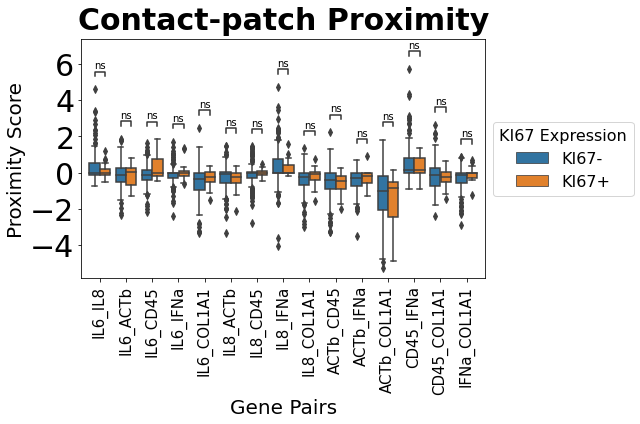

In [550]:
channel_pairs = set1_stat["Gene Pair"].unique()
hue = "KI67"
x = "Gene Pair"
gp = set1_stat["Gene Pair"].unique()
y = "Proximity"
hue_order=['KI67-','KI67+']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67-"),(p, "KI67+")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=set1_stat, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=set1_stat, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67 Expression', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set1 ki67 gene proximity.png', bbox_inches="tight")
plt.show()

In [551]:
sub_df = set1_stat[set1_stat['Gene Pair']=='IL6_ACTb']

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

IL6_ACTb_KI67- v.s. IL6_ACTb_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.409e-01 U_stat=1.878e+03


C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\3498824381.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


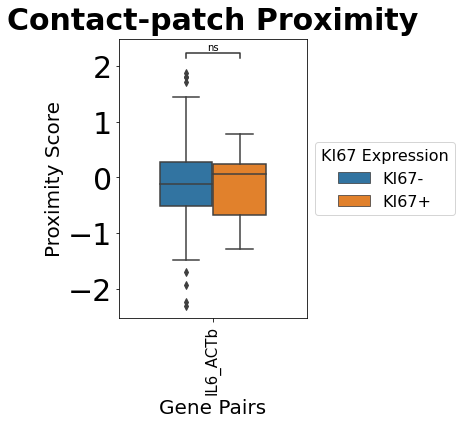

In [552]:
channel_pairs = sub_df["Gene Pair"].unique()
hue = "KI67"
x = "Gene Pair"
gp = sub_df["Gene Pair"].unique()
y = "Proximity"
hue_order=['KI67-','KI67+']
plt.figure(figsize=(6, 6))
plt.title('Contact-patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67-"),(p, "KI67+")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=sub_df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=sub_df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67 Expression', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set1 ki67 actb il6 gene proximity.png', bbox_inches="tight")
plt.show()

In [553]:
set2_proxi_only = set2_mean_central_proxi.drop(columns=['cellID','KI67_label'])
set2_stat = set2_proxi_only.melt(var_name='Gene Pair', value_name='Proximity')
set2_stat['KI67'] = set2_mean_central_proxi['KI67_label'].tolist() * set2_proxi_only.shape[1]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

IL10_PD1_KI67- v.s. IL10_PD1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.975e-01 U_stat=1.061e+03
IL10_PDL1_KI67- v.s. IL10_PDL1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.293e-01 U_stat=1.274e+03
IL10_GAPDH_KI67- v.s. IL10_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.354e-01 U_stat=1.146e+03
PD1_PDL1_KI67- v.s. PD1_PDL1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.218e-01 U_stat=9.600e+02
PD1_GAPDH_KI67- v.s. PD1_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.002e-01 U_stat=1.310e+03
PDL1_GAPDH_KI67- v.s. PDL1_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.485e-01 U_stat=1.326e+03
HLA-DRA_GAPDH_KI67- v.s. HLA-DRA_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.517e-01 U_stat=1.325e+03
COL1A1_IL10_KI67- v.s. COL1A1_IL10_KI67+: Mann-Whitney-Wilcoxon t

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\1253332528.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


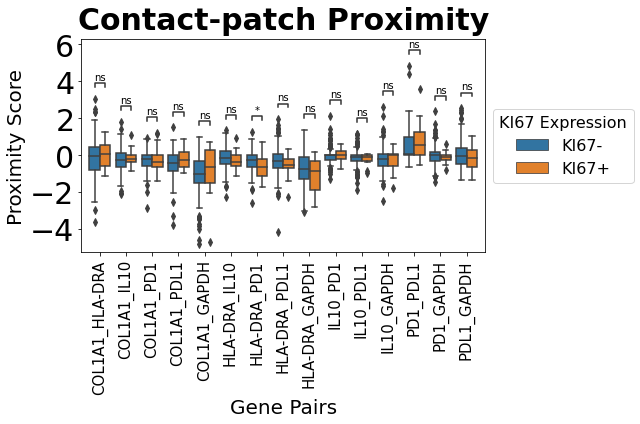

In [554]:
channel_pairs = set2_stat["Gene Pair"].unique()
hue = "KI67"
x = "Gene Pair"
gp = set2_stat["Gene Pair"].unique()
y = "Proximity"
hue_order=['KI67-','KI67+']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67-"),(p, "KI67+")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=set2_stat, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=set2_stat, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67 Expression', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set2 ki67 gene proximity.png', bbox_inches="tight")
plt.show()

In [555]:
set3_proxi_only = set3_mean_central_proxi.drop(columns=['cellID','KI67_label'])
set3_stat = set3_proxi_only.melt(var_name='Gene Pair', value_name='Proximity')
set3_stat['KI67'] = set3_mean_central_proxi['KI67_label'].tolist() * set3_proxi_only.shape[1]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

COL5A2_CCL11_KI67- v.s. COL5A2_CCL11_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.150e+03
COL5A2_COL2A1_KI67- v.s. COL5A2_COL2A1_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.598e+03
COL5A2_CXCL10_KI67- v.s. COL5A2_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.848e+03
CCL11_COL2A1_KI67- v.s. CCL11_COL2A1_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.628e+03
CCL11_CXCL10_KI67- v.s. CCL11_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.107e+03
COL2A1_CXCL10_KI67- v.s. COL2A1_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\1761652084.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


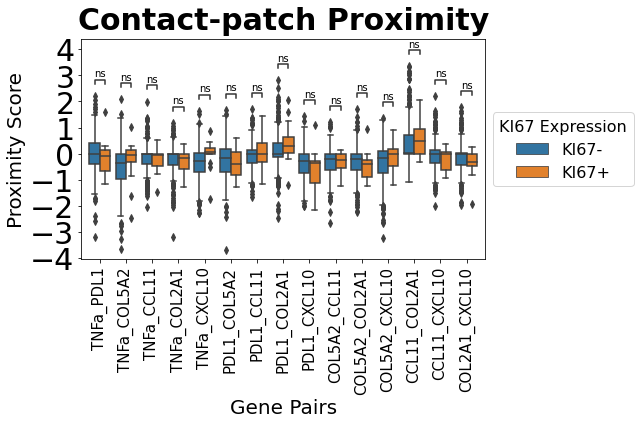

In [556]:
channel_pairs = set3_stat["Gene Pair"].unique()
hue = "KI67"
x = "Gene Pair"
gp = set3_stat["Gene Pair"].unique()
y = "Proximity"
hue_order=['KI67-','KI67+']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67-"),(p, "KI67+")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=set3_stat, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=set3_stat, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67 Expression', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set3 ki67 gene proximity.png', bbox_inches="tight")
plt.show()

In [557]:
set4_proxi_only = set4_mean_central_proxi.drop(columns=['cellID','KI67_label'])
set4_stat = set4_proxi_only.melt(var_name='Gene Pair', value_name='Proximity')
set4_stat['KI67'] = set4_mean_central_proxi['KI67_label'].tolist() * set4_proxi_only.shape[1]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CXCR4_ACTb_KI67- v.s. CXCR4_ACTb_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.500e+01
CXCR4_IFNg_KI67- v.s. CXCR4_IFNg_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.200e+01
CXCR4_CD34_KI67- v.s. CXCR4_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.300e+01
ACTb_IFNg_KI67- v.s. ACTb_IFNg_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.900e+01
ACTb_CD34_KI67- v.s. ACTb_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.500e+01
IFNg_CD34_KI67- v.s. IFNg_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.330e+02
COL2A1_CD34_KI

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\1116753237.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


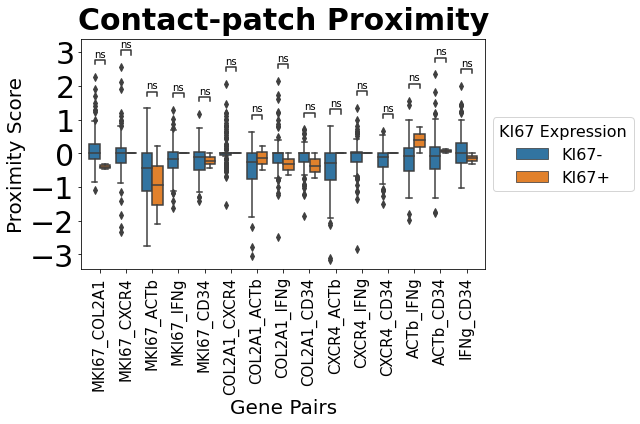

In [558]:
channel_pairs = set4_stat["Gene Pair"].unique()
hue = "KI67"
x = "Gene Pair"
gp = set4_stat["Gene Pair"].unique()
y = "Proximity"
hue_order=['KI67-','KI67+']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67-"),(p, "KI67+")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=set4_stat, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=set4_stat, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67 Expression', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set4 ki67 gene proximity.png', bbox_inches="tight")
plt.show()

# multi-celltype comparison

In [598]:
cd4_proxi_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proxi_dfs\cd4'
fn_l = os.listdir(cd4_proxi_dir)
fn_l.sort()

cd4_proxi = {}
for fn in fn_l:
    proxi = pd.read_csv(os.path.join(cd4_proxi_dir,fn), index_col=0)
    cd4_proxi[fn.split('.')[0]] = proxi

cd8_proxi_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proxi_dfs\cd8'
fn_l = os.listdir(cd8_proxi_dir)
fn_l.sort()

cd8_proxi = {}
for fn in fn_l:
    proxi = pd.read_csv(os.path.join(cd8_proxi_dir,fn), index_col=0)
    cd8_proxi[fn.split('.')[0]] = proxi

In [599]:
cd4_centers_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd4'
fn_l = os.listdir(cd4_centers_dir)
fn_l.sort()

cd4_centers = {}
for fn in fn_l:
    centers = pd.read_csv(os.path.join(cd4_centers_dir,fn), index_col=0)
    cd4_centers[fn.split('_')[0]] = centers

cd8_centers_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd8'
fn_l = os.listdir(cd8_centers_dir)
fn_l.sort()

cd8_centers = {}
for fn in fn_l:
    centers = pd.read_csv(os.path.join(cd8_centers_dir,fn), index_col=0)
    cd8_centers[fn.split('_')[0]] = centers

In [600]:
for k in cd4_proxi.keys():
    cd4_proxi[k]['patch_id'] = cd4_centers[k]['patch_id'].tolist()
    cd4_proxi[k]['cellID'] = cd4_centers[k]['cellID'].tolist()
    cd4_proxi[k]['row'] = cd4_centers[k]['row'].tolist()
    cd4_proxi[k]['col'] = cd4_centers[k]['col'].tolist()
    cd4_proxi[k]['z'] = cd4_centers[k]['z'].tolist()

for k in cd8_proxi.keys():
    cd8_proxi[k]['patch_id'] = cd8_centers[k]['patch_id'].tolist()
    cd8_proxi[k]['cellID'] = cd8_centers[k]['cellID'].tolist()
    cd8_proxi[k]['row'] = cd8_centers[k]['row'].tolist()
    cd8_proxi[k]['col'] = cd8_centers[k]['col'].tolist()
    cd8_proxi[k]['z'] = cd8_centers[k]['z'].tolist()

In [601]:
cd4_pos = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cell_3d_pos_cd4.csv',index_col=0)
cd8_pos = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cell_3d_pos_cd8.csv',index_col=0)

In [628]:
def central_proxi(proxi, cell_centers, cell):
    cell_proxi = proxi[proxi['cellID']==cell]
    patches = cell_proxi[['row','col']].values
    patches = patches.astype('float')
    cell_pos = cell_centers[cell_centers['cellID']==cell][['row','col']].values
    cell_pos = cell_pos.astype('float')
    d = np.sqrt(np.sum((patches - cell_pos) ** 2, axis=1))
    # Sorting key
    sorted_idx = np.argsort(d)
    sorted_idx = sorted_idx
    return cell_proxi.iloc[sorted_idx[:5]]

In [629]:
cd4_central_proxi = {}
for k in cd4_proxi.keys():
    proxi = cd4_proxi[k]
    cells = proxi['cellID'].unique()
    temp = Parallel(n_jobs=-2,verbose=50)(delayed(central_proxi)(proxi, cd4_pos, cell) for cell in cells)

    cd4_central_proxi[k] = pd.concat(temp)

cd8_central_proxi = {}
for k in cd8_proxi.keys():
    proxi = cd8_proxi[k]
    cells = proxi['cellID'].unique()
    temp = Parallel(n_jobs=-2,verbose=50)(delayed(central_proxi)(proxi, cd8_pos, cell) for cell in cells)

    cd8_central_proxi[k] = pd.concat(temp)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0230s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  14 tas

[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 157 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 158 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 159 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 160 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 164 out of 173 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 168 out of 173 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 173 out of 173 | elapsed:    0.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0250s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done   4 tasks      | elaps

In [790]:
cd8_central_proxi['set2'][cd8_central_proxi['set2']['cellID']=='034_4']

COL1A1_HLA-DRA  COL1A1_IL10  COL1A1_PD1  COL1A1_PDL1  COL1A1_GAPDH  \
1237        0.000000     0.000000    0.000000     0.000000      0.000000   
1221       -0.278685     0.000000   -2.114247    -2.637804     -1.073771   
1212        1.534535     0.633540   -0.824157     0.000000     -3.365460   
1214        1.850145     1.536361   -1.269934     0.266897     -4.153976   
1217        0.644554    -1.166166   -0.848608     1.399187     -1.595182   

      HLA-DRA_IL10  HLA-DRA_PD1  HLA-DRA_PDL1  HLA-DRA_GAPDH  IL10_PD1  ...  \
1237      0.000000     0.000000      0.000000       0.000000  0.000000  ...   
1221      0.000000    -3.206220     -4.024732      -1.671470  0.000000  ...   
1212      2.308968    -0.259391      0.000000      -2.103316 -0.367560  ...   
1214      0.386580    -0.882428     -1.128511      -2.845316 -0.429776  ...   
1217      0.327853    -1.128259      0.126087       0.642377  0.959841  ...   

      PD1_PDL1  PD1_GAPDH  PDL1_GAPDH  patch_id  cellID          row  \
1237  0.000000   0.290906    0.000000  034_4_54   034_4  1182.363636   
1221  3.820557   0.056659   -0.405397  034_4_38   034_4  1301.738095   
1212  0.000000  -1.380788    0.000000  034_4_29   034_4  1281.735849   
1214 -0.805079   1.065832    0.120197  034_4_31   034_4  1237.960784   
1217 -0.496581  -0.022179   -1.562858  034_4_34   034_4  1300.357143   

             col          z      KI67  KI67_label  
1237  824.272727  28.636364  0.071405       KI67+  
1221  887.214286   0.357143  0.071405       KI67+  
1212  827.547170  16.584906  0.071405       KI67+  
1214  979.764706  15.117647  0.071405       KI67+  
1217  920.357143  28.214286  0.071405       KI67+  

[5 rows x 22 columns]

In [3]:
cd4_central_proxi = pd.read_pickle(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd4_central_proxi.pkl')
cd8_central_proxi = pd.read_pickle(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd8_central_proxi.pkl')
cd4_central_embedding = pd.read_pickle(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd4_central_embedding.pkl')
cd8_central_embedding = pd.read_pickle(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd8_central_embedding.pkl')

In [8]:
cd4_central_proxi['set1']

IL6_IL8  IL6_ACTb  IL6_CD45  IL6_IFNa  IL6_COL1A1  IL8_ACTb  IL8_CD45  \
24     0.000000  1.565258 -2.160404 -0.897366   -0.671220  0.000000  0.000000   
34    -0.416588 -1.391371  2.393345 -0.764924   -1.330752 -1.418932 -0.754767   
30     0.000000  1.491588 -0.077757 -0.593521   -0.990164  0.000000  0.000000   
16    -1.005174 -4.321532  3.546264 -0.587912    5.120903  0.252696 -1.967545   
11     0.000000  0.006353 -0.344862 -0.522035    2.002284  0.000000  0.000000   
...         ...       ...       ...       ...         ...       ...       ...   
12208  0.000000  0.084381 -0.505366  0.000000    0.153397  0.000000  0.000000   
12176  4.374105 -3.387844  1.122928 -0.721548   -0.488155 -4.962098 -1.014155   
12188  1.351733 -1.457463  1.157380  1.673853   -3.286476  0.003650  1.171526   
12204  0.000000  0.000000  0.000000  0.000000    0.000000 -0.964163 -0.458697   
12223  0.000000  0.242924 -1.559535 -1.424699    0.000000  0.000000  0.000000   

       IL8_IFNa  IL8_COL1A1  ACTb_CD45  ...  CD45_IFNa  CD45_COL1A1  \
24     0.000000    0.000000  -4.279193  ...  -0.431094    -0.429522   
34     1.362711    0.234447  -0.860775  ...  -0.777725    -0.370854   
30     0.000000    0.000000  -2.631141  ...  -0.619745     0.088991   
16    -0.514091   -0.690103  -4.713388  ...   0.697606     0.280950   
11     0.000000    0.000000   0.608863  ...   0.373671    -1.051093   
...         ...         ...        ...  ...        ...          ...   
12208  0.000000    0.000000   0.072326  ...   0.000000    -0.452369   
12176  5.183842   -0.612930  -0.428273  ...  -2.243951     0.911416   
12188  4.624018   -2.247523  -0.393083  ...   2.955300    -1.521993   
12204  1.165673    0.651154   0.155877  ...  -0.468130     1.235771   
12223  0.000000    0.000000  -2.981196  ...   4.164945     0.000000   

       IFNa_COL1A1  patch_id  cellID          row          col          z  \
24        3.331906  000_1_24   000_1  1260.500000  1614.724138  27.310345   
34       -1.295841  000_1_34   000_1  1105.051282  1564.076923   8.692308   
30        0.740256  000_1_30   000_1  1162.555556  1490.400000   7.000000   
16       -0.380647  000_1_16   000_1  1196.276923  1687.446154   8.861538   
11       -0.598155  000_1_11   000_1  1263.971831  1497.971831  33.591549   
...            ...       ...     ...          ...          ...        ...   
12208     0.000000  029_6_37   029_6  1428.829268  1833.365854  23.780488   
12176    -0.689537   029_6_5   029_6  1591.527778  1887.875000  12.041667   
12188    -2.227632  029_6_17   029_6  1411.508197  1881.524590  15.393443   
12204    -0.354361  029_6_33   029_6  1430.422222  1922.177778   8.933333   
12223     0.000000  029_6_52   029_6  1463.947368  1761.789474  57.473684   

           KI67  KI67_label  
24     0.006915       KI67-  
34     0.006915       KI67-  
30     0.006915       KI67-  
16     0.006915       KI67-  
11     0.006915       KI67-  
...         ...         ...  
12208  0.011289       KI67-  
12176  0.011289       KI67-  
12188  0.011289       KI67-  
12204  0.011289       KI67-  
12223  0.011289       KI67-  

[1145 rows x 22 columns]

In [14]:
comp = {}
for k in cd4_central_proxi.keys():
    cd4_proxi = cd4_central_proxi[k].drop(columns=['cellID','row','col','z','patch_id','KI67','KI67_label'])
    cd4_temp = cd4_proxi.melt(var_name='Gene Pair', value_name='Proximity')
    cd8_proxi = cd8_central_proxi[k].drop(columns=['cellID','row','col','z','patch_id','KI67','KI67_label'])
    cd8_temp = cd8_proxi.melt(var_name='Gene Pair', value_name='Proximity')
    combined = pd.concat([cd4_temp,cd8_temp])
    combined['Cell type'] = ['CD4']*cd4_temp.shape[0] + ['CD8']*cd8_temp.shape[0]
    combined = combined[combined['Proximity']!=0]
    comp[k] = combined

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ACTb_CD45_CD4 v.s. ACTb_CD45_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=3.179e-03 U_stat=3.124e+05
ACTb_IFNa_CD4 v.s. ACTb_IFNa_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=5.144e-01 U_stat=1.343e+05
ACTb_COL1A1_CD4 v.s. ACTb_COL1A1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=8.213e-02 U_stat=4.704e+05
CD45_IFNa_CD4 v.s. CD45_IFNa_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=8.861e-01 U_stat=1.148e+05
CD45_COL1A1_CD4 v.s. CD45_COL1A1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=2.137e-01 U_stat=3.272e+05
IFNa_COL1A1_CD4 v.s. IFNa_COL1A1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=4.767e-01 U_stat=1.317e+05
IL8_COL1A1_CD4 v.s. IL8_COL1A1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=7.767e-01 U_stat=1.175e+05
IL6_ACTb_CD4 v.s. IL6_ACTb_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=4.926e-01 U

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\43582610.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


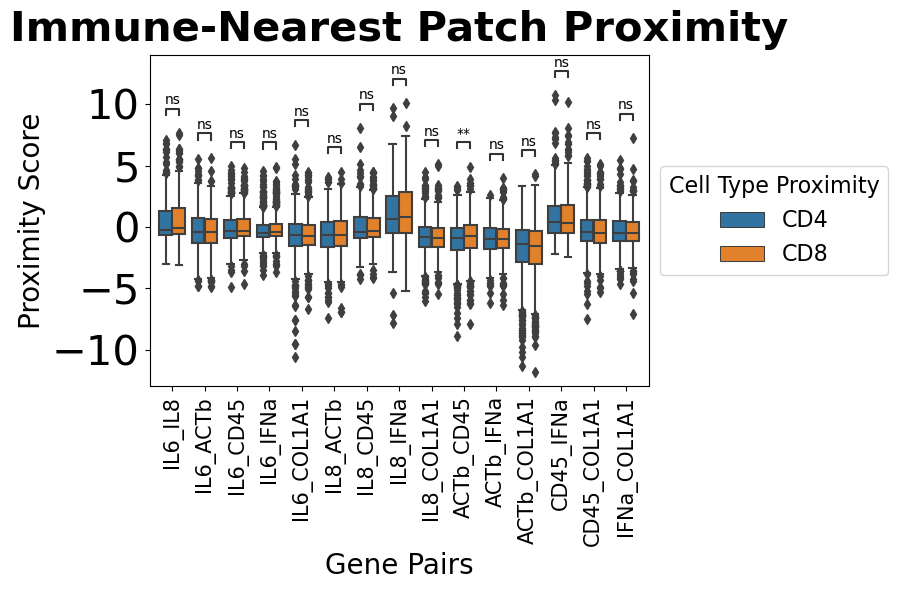

In [17]:
df = comp['set1']
channel_pairs = df["Gene Pair"].unique()
hue = "Cell type"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Proximity"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type Proximity', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set1 cd4-cd8 gene proximity.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

IL10_PD1_CD4 v.s. IL10_PD1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=9.593e-01 U_stat=8.629e+04
IL10_PDL1_CD4 v.s. IL10_PDL1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=5.571e-01 U_stat=1.174e+05
IL10_GAPDH_CD4 v.s. IL10_GAPDH_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=6.748e-01 U_stat=2.038e+05
PD1_PDL1_CD4 v.s. PD1_PDL1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=6.330e-02 U_stat=7.410e+04
PD1_GAPDH_CD4 v.s. PD1_GAPDH_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=2.586e-01 U_stat=1.212e+05
PDL1_GAPDH_CD4 v.s. PDL1_GAPDH_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=9.380e-01 U_stat=1.680e+05
HLA-DRA_GAPDH_CD4 v.s. HLA-DRA_GAPDH_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=6.238e-02 U_stat=3.047e+05
COL1A1_IL10_CD4 v.s. COL1A1_IL10_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=1.966e-01 U

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\1233406992.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


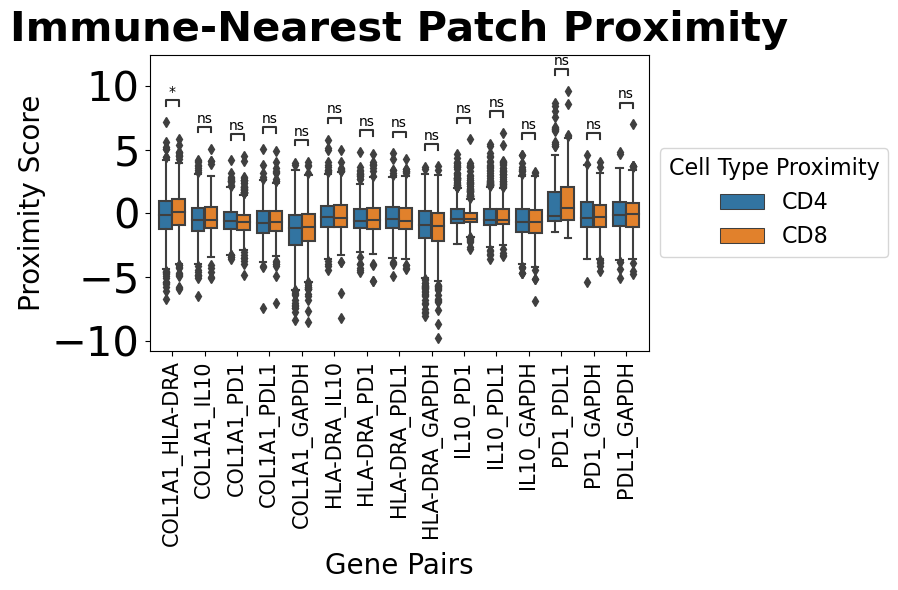

In [18]:
df = comp['set2']
channel_pairs = df["Gene Pair"].unique()
hue = "Cell type"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Proximity"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type Proximity', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set2 cd4-cd8 gene proximity.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

COL5A2_CCL11_CD4 v.s. COL5A2_CCL11_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=6.839e-01 U_stat=3.513e+05
COL5A2_COL2A1_CD4 v.s. COL5A2_COL2A1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=5.603e-03 U_stat=2.673e+05
COL5A2_CXCL10_CD4 v.s. COL5A2_CXCL10_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=8.791e-01 U_stat=5.476e+05
CCL11_COL2A1_CD4 v.s. CCL11_COL2A1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=1.557e-01 U_stat=2.107e+05
CCL11_CXCL10_CD4 v.s. CCL11_CXCL10_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=3.146e-01 U_stat=3.479e+05
COL2A1_CXCL10_CD4 v.s. COL2A1_CXCL10_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=8.188e-01 U_stat=2.497e+05
PDL1_CXCL10_CD4 v.s. PDL1_CXCL10_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=5.001e-01 U_stat=4.792e+05
TNFa_COL5A2_CD4 v.s. TNFa_COL5A2_CD8: Mann-Whitney-Wilc

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\3568220597.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


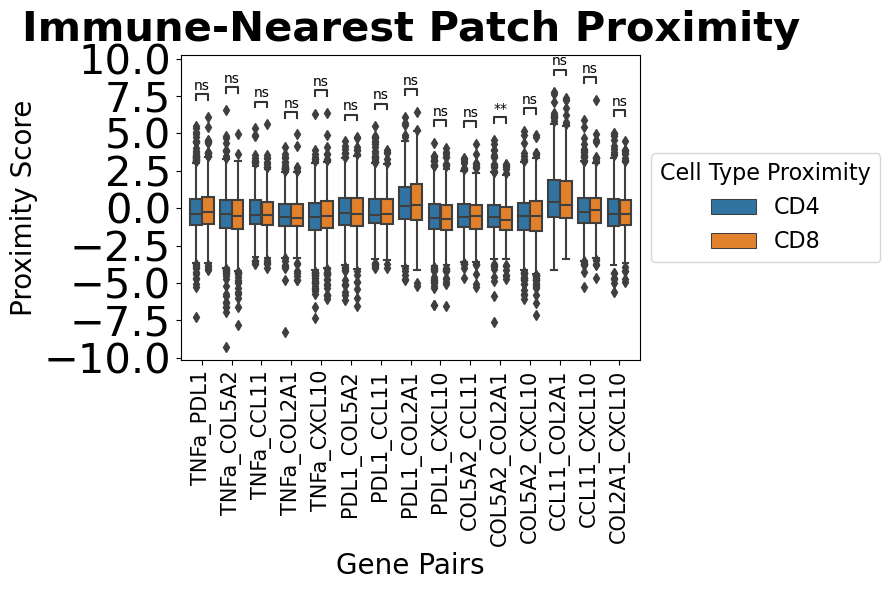

In [19]:
df = comp['set3']
channel_pairs = df["Gene Pair"].unique()
hue = "Cell type"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Proximity"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type Proximity', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set3 cd4-cd8 gene proximity.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CXCR4_ACTb_CD4 v.s. CXCR4_ACTb_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=7.185e-01 U_stat=5.103e+04
CXCR4_IFNg_CD4 v.s. CXCR4_IFNg_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=7.384e-01 U_stat=3.950e+04
CXCR4_CD34_CD4 v.s. CXCR4_CD34_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=9.756e-01 U_stat=3.847e+04
ACTb_IFNg_CD4 v.s. ACTb_IFNg_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=6.455e-01 U_stat=7.758e+04
ACTb_CD34_CD4 v.s. ACTb_CD34_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=1.988e-01 U_stat=8.061e+04
IFNg_CD34_CD4 v.s. IFNg_CD34_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=5.576e-02 U_stat=5.591e+04
COL2A1_CD34_CD4 v.s. COL2A1_CD34_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=9.947e-01 U_stat=1.442e+04
MKI67_CXCR4_CD4 v.s. MKI67_CXCR4_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=7.141e-01

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\2026127124.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


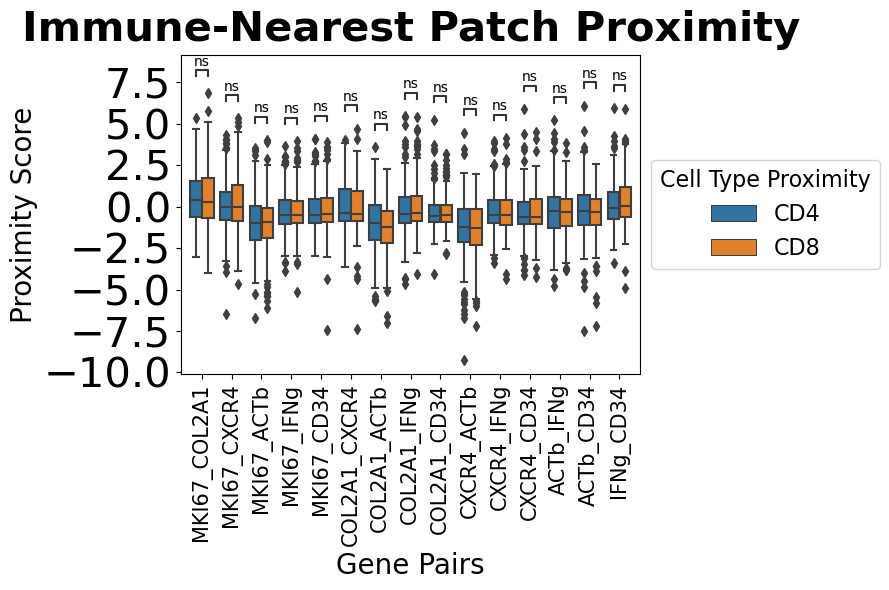

In [20]:
df = comp['set4']
channel_pairs = df["Gene Pair"].unique()
hue = "Cell type"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Proximity"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type Proximity', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set4 cd4-cd8 gene proximity.png', bbox_inches="tight")
plt.show()

## Central proximity v. ki67 expression

In [636]:
from skimage.filters import threshold_otsu

In [637]:
cd4_ki67 = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd4_ki67_intensity.csv', index_col=0)
cd8_ki67 = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd8_ki67_intensity.csv', index_col=0)

In [638]:
for k in cd4_central_proxi.keys():
    ki67_temp = []
    for cell in cd4_central_proxi[k]['cellID']:
        ki67_temp.append(cd4_ki67[cd4_ki67['cellID']==cell]['KI67'].tolist()[0])
    cd4_central_proxi[k]['KI67'] = ki67_temp

for k in cd8_central_proxi.keys():
    ki67_temp = []
    for cell in cd8_central_proxi[k]['cellID']:
        ki67_temp.append(cd8_ki67[cd8_ki67['cellID']==cell]['KI67'].tolist()[0])
    cd8_central_proxi[k]['KI67'] = ki67_temp

In [639]:
cd4_ki67_thre = threshold_otsu(cd4_ki67['KI67'].to_numpy())
cd8_ki67_thre = threshold_otsu(cd8_ki67['KI67'].to_numpy())

In [640]:
for k in cd4_central_proxi.keys():
    ki67 = cd4_central_proxi[k]['KI67'].to_numpy() > cd4_ki67_thre
    ki67_label = ['KI67+' if i else 'KI67-' for i in ki67]
    cd4_central_proxi[k]['KI67_label'] = ki67_label
for k in cd8_central_proxi.keys():
    ki67 = cd8_central_proxi[k]['KI67'].to_numpy() > cd8_ki67_thre
    ki67_label = ['KI67+' if i else 'KI67-' for i in ki67]
    cd8_central_proxi[k]['KI67_label'] = ki67_label

In [21]:
ki67_proxi_comp = {}
for k in cd4_central_proxi.keys():
    cd4_ki67_label = cd4_central_proxi[k]['KI67_label'].tolist()
    cd4_proxi = cd4_central_proxi[k].drop(columns=['cellID','row','col','z','patch_id','KI67','KI67_label'])
    cd4_temp = cd4_proxi.melt(var_name='Gene Pair', value_name='Proximity')
    cd4_temp['KI67_label'] = cd4_ki67_label * cd4_proxi.shape[1]

    cd8_ki67_label = cd8_central_proxi[k]['KI67_label'].tolist()
    cd8_proxi = cd8_central_proxi[k].drop(columns=['cellID','row','col','z','patch_id','KI67','KI67_label'])
    cd8_temp = cd8_proxi.melt(var_name='Gene Pair', value_name='Proximity')
    cd8_temp['KI67_label'] = cd8_ki67_label * cd8_proxi.shape[1]

    combined = pd.concat([cd4_temp,cd8_temp])
    combined['Cell type'] = ['CD4']*cd4_temp.shape[0] + ['CD8']*cd8_temp.shape[0]
    combined = combined[combined['Proximity']!=0]
    ki67_proxi_comp[k] = combined

In [22]:
for k in ki67_proxi_comp.keys():
    ki67_proxi_comp[k] = ki67_proxi_comp[k][ki67_proxi_comp[k]['Proximity']!=0]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ACTb_CD45_KI67- v.s. ACTb_CD45_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.130e-01 U_stat=3.162e+04
ACTb_IFNa_KI67- v.s. ACTb_IFNa_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.234e-01 U_stat=1.294e+04
ACTb_COL1A1_KI67- v.s. ACTb_COL1A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.585e-01 U_stat=3.969e+04
CD45_IFNa_KI67- v.s. CD45_IFNa_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.674e-01 U_stat=1.106e+04
CD45_COL1A1_KI67- v.s. CD45_COL1A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.672e-01 U_stat=2.446e+04
IFNa_COL1A1_KI67- v.s. IFNa_COL1A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.692e-01 U_stat=1.123e+04
IL8_COL1A1_KI67- v.s. IL8_COL1A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.282e-01 U_stat=1.274e+04
IL6_ACTb_KI67- v.s. IL6_ACTb_KI67+: Mann-Whitney-Wilcoxon t

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\2682604280.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


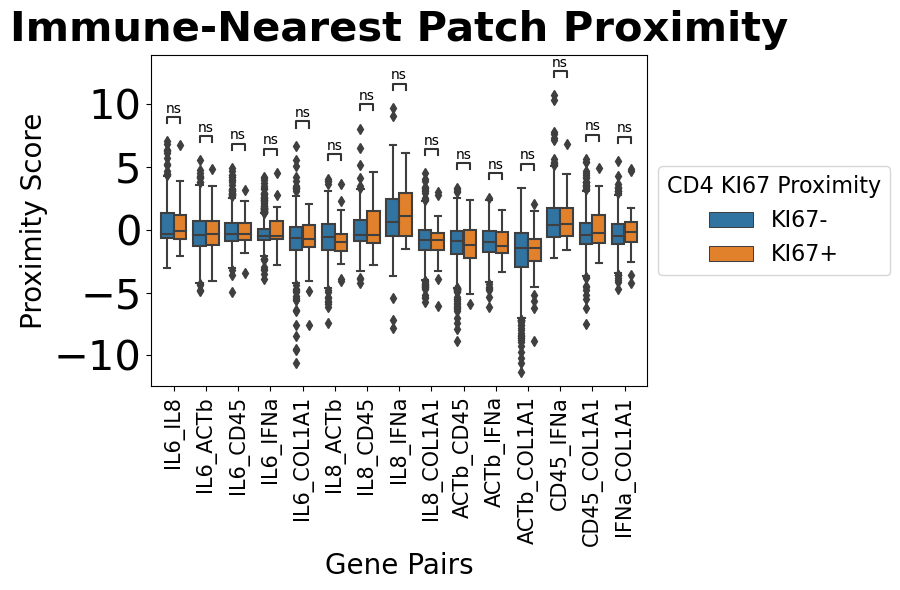

In [23]:
df = ki67_proxi_comp['set1']
df = df[df['Cell type'] == 'CD4']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Proximity"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD4 KI67 Proximity', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set1 cd4 ki67 gene proximity.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

IL10_PD1_KI67- v.s. IL10_PD1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.539e-03 U_stat=5.397e+03
IL10_PDL1_KI67- v.s. IL10_PDL1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.708e-01 U_stat=1.362e+04
IL10_GAPDH_KI67- v.s. IL10_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.355e-01 U_stat=1.826e+04
PD1_PDL1_KI67- v.s. PD1_PDL1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.687e-01 U_stat=6.920e+03
PD1_GAPDH_KI67- v.s. PD1_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.404e-04 U_stat=1.242e+04
PDL1_GAPDH_KI67- v.s. PDL1_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.648e-01 U_stat=1.642e+04
HLA-DRA_GAPDH_KI67- v.s. HLA-DRA_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.067e-01 U_stat=2.755e+04
COL1A1_IL10_KI67- v.s. COL1A1_IL10_KI67+: Mann-Whitney-Wilcoxon t

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\37790110.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


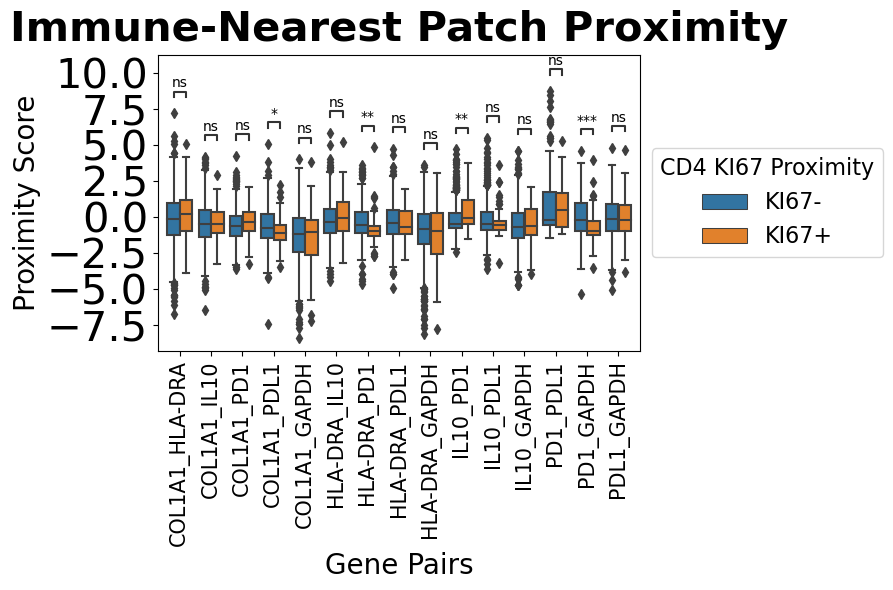

In [24]:
df = ki67_proxi_comp['set2']
df = df[df['Cell type'] == 'CD4']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Proximity"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD4 KI67 Proximity', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set2 cd4 ki67 gene proximity.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

COL5A2_CCL11_KI67- v.s. COL5A2_CCL11_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.304e-01 U_stat=1.995e+04
COL5A2_COL2A1_KI67- v.s. COL5A2_COL2A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.133e-01 U_stat=1.478e+04
COL5A2_CXCL10_KI67- v.s. COL5A2_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.917e-01 U_stat=3.297e+04
CCL11_COL2A1_KI67- v.s. CCL11_COL2A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.583e-01 U_stat=8.795e+03
CCL11_CXCL10_KI67- v.s. CCL11_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.613e-01 U_stat=1.791e+04
COL2A1_CXCL10_KI67- v.s. COL2A1_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.184e-01 U_stat=1.336e+04
PDL1_CXCL10_KI67- v.s. PDL1_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.860e-01 U_stat=2.636e+04
TNFa_COL5A2_KI67- v.s. TNFa

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\2631382056.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


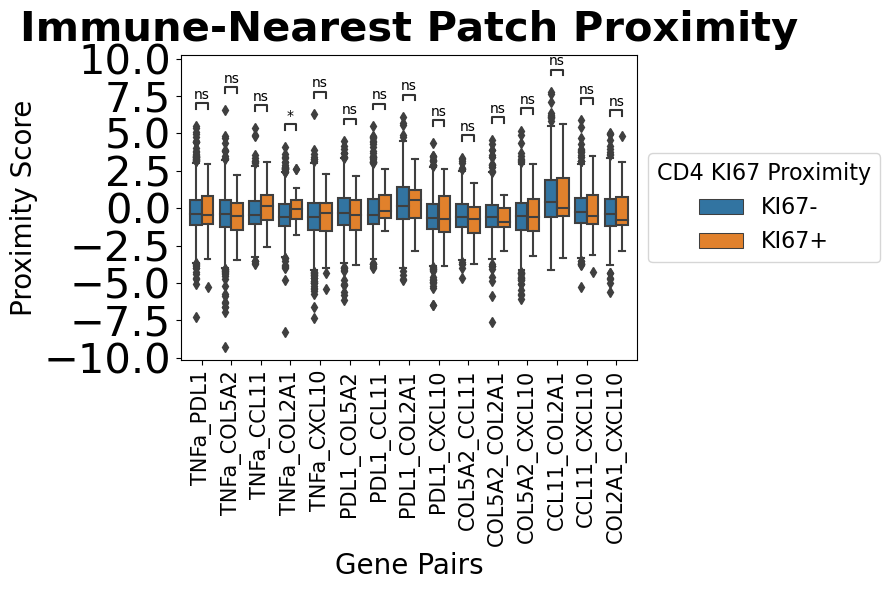

In [25]:
df = ki67_proxi_comp['set3']
df = df[df['Cell type'] == 'CD4']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Proximity"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD4 KI67 Proximity', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set3 cd4 ki67 gene proximity.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CXCR4_ACTb_KI67- v.s. CXCR4_ACTb_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.611e-02 U_stat=7.340e+02
CXCR4_IFNg_KI67- v.s. CXCR4_IFNg_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.914e-01 U_stat=5.190e+02
CXCR4_CD34_KI67- v.s. CXCR4_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.060e-01 U_stat=1.029e+03
ACTb_IFNg_KI67- v.s. ACTb_IFNg_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.023e-01 U_stat=1.366e+03
ACTb_CD34_KI67- v.s. ACTb_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.803e-01 U_stat=1.742e+03
IFNg_CD34_KI67- v.s. IFNg_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.868e-01 U_stat=1.097e+03
COL2A1_CD34_KI67- v.s. COL2A1_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.787e-01 U_stat=3.020e+02
MKI67_CXCR4_KI67- v.s. MKI67_CXCR4_KI67+: Mann-Whitney-Wilcoxon

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\406484523.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


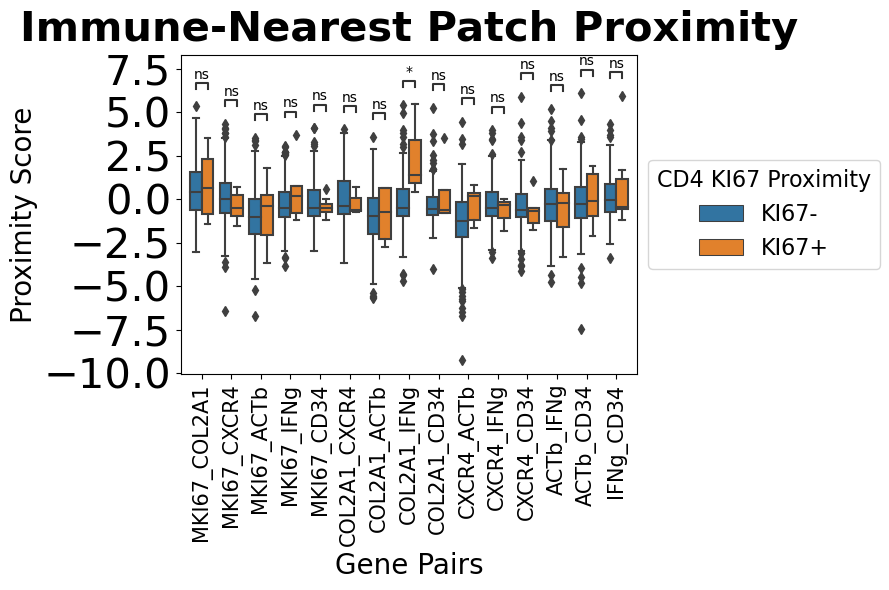

In [26]:
df = ki67_proxi_comp['set4']
df = df[df['Cell type'] == 'CD4']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Proximity"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD4 KI67 Proximity', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set4 cd4 ki67 gene proximity.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ACTb_CD45_KI67+ v.s. ACTb_CD45_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=5.194e-01 U_stat=4.284e+04
ACTb_IFNa_KI67+ v.s. ACTb_IFNa_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=5.452e-01 U_stat=1.683e+04
ACTb_COL1A1_KI67+ v.s. ACTb_COL1A1_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=3.616e-01 U_stat=5.755e+04
CD45_IFNa_KI67+ v.s. CD45_IFNa_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=5.758e-01 U_stat=1.453e+04
CD45_COL1A1_KI67+ v.s. CD45_COL1A1_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=1.306e-01 U_stat=4.426e+04
IFNa_COL1A1_KI67+ v.s. IFNa_COL1A1_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=5.554e-01 U_stat=1.675e+04
IL8_COL1A1_KI67+ v.s. IL8_COL1A1_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=5.050e-02 U_stat=1.705e+04
IL6_ACTb_KI67+ v.s. IL6_ACTb_KI67-: Mann-Whitney-Wilcoxon t

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\542659924.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


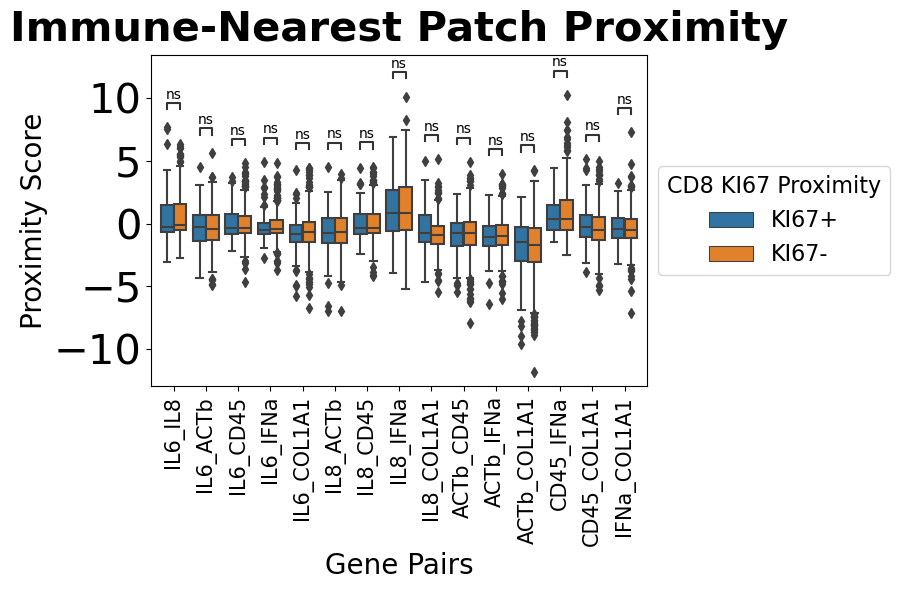

In [27]:
df = ki67_proxi_comp['set1']
df = df[df['Cell type'] == 'CD8']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Proximity"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD8 KI67 Proximity', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set1 cd8 ki67 gene proximity.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

IL10_PD1_KI67- v.s. IL10_PD1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.778e-01 U_stat=4.346e+03
IL10_PDL1_KI67- v.s. IL10_PDL1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.046e-01 U_stat=6.265e+03
IL10_GAPDH_KI67- v.s. IL10_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.678e-01 U_stat=1.187e+04
PD1_PDL1_KI67- v.s. PD1_PDL1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.701e-01 U_stat=4.272e+03
PD1_GAPDH_KI67- v.s. PD1_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.087e-01 U_stat=6.543e+03
PDL1_GAPDH_KI67- v.s. PDL1_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.735e-01 U_stat=1.002e+04
HLA-DRA_GAPDH_KI67- v.s. HLA-DRA_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.981e-02 U_stat=2.100e+04
COL1A1_IL10_KI67- v.s. COL1A1_IL10_KI67+: Mann-Whitney-Wilcoxon t

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\598797089.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


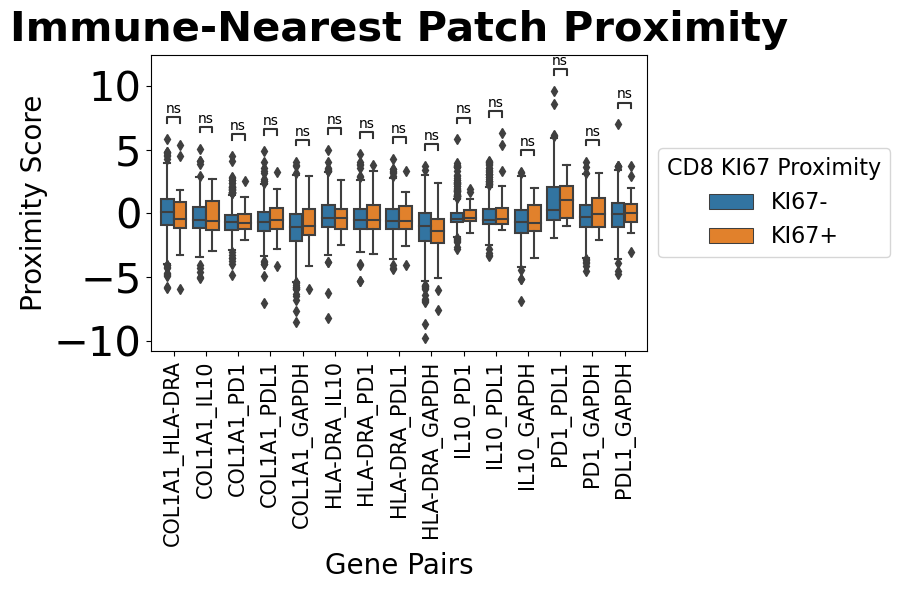

In [28]:
df = ki67_proxi_comp['set2']
df = df[df['Cell type'] == 'CD8']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Proximity"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD8 KI67 Proximity', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set2 cd8 ki67 gene proximity.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

COL5A2_CCL11_KI67- v.s. COL5A2_CCL11_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.006e-01 U_stat=1.367e+04
COL5A2_COL2A1_KI67- v.s. COL5A2_COL2A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.888e-01 U_stat=9.605e+03
COL5A2_CXCL10_KI67- v.s. COL5A2_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.681e-03 U_stat=1.388e+04
CCL11_COL2A1_KI67- v.s. CCL11_COL2A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.660e-01 U_stat=9.637e+03
CCL11_CXCL10_KI67- v.s. CCL11_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.517e-01 U_stat=1.240e+04
COL2A1_CXCL10_KI67- v.s. COL2A1_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.242e-01 U_stat=1.092e+04
PDL1_CXCL10_KI67- v.s. PDL1_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.578e-01 U_stat=1.404e+04
TNFa_COL5A2_KI67- v.s. TNFa

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\1179895798.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


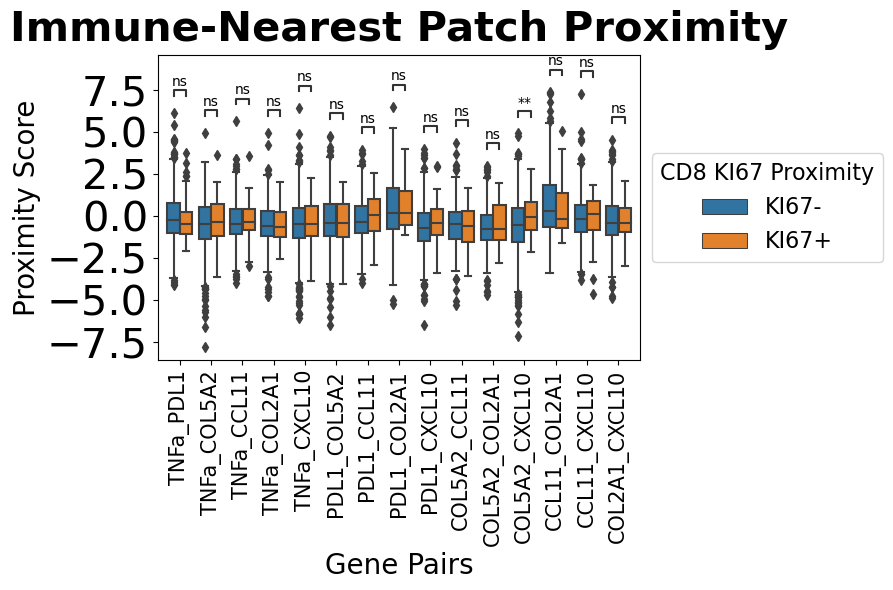

In [29]:
df = ki67_proxi_comp['set3']
df = df[df['Cell type'] == 'CD8']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Proximity"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD8 KI67 Proximity', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set3 cd8 ki67 gene proximity.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CXCR4_ACTb_KI67- v.s. CXCR4_ACTb_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.345e-01 U_stat=9.970e+02
CXCR4_IFNg_KI67- v.s. CXCR4_IFNg_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.660e-01 U_stat=4.740e+02
CXCR4_CD34_KI67- v.s. CXCR4_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.957e-01 U_stat=4.000e+02
ACTb_IFNg_KI67- v.s. ACTb_IFNg_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.129e-01 U_stat=4.360e+02
ACTb_CD34_KI67- v.s. ACTb_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.578e-01 U_stat=7.030e+02
IFNg_CD34_KI67- v.s. IFNg_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.234e-01 U_stat=4.750e+02
COL2A1_CD34_KI67- v.s. COL2A1_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.800e-01 U_stat=1.900e+02
MKI67_CXCR4_KI67- v.s. MKI67_CXCR4_KI67+: Mann-Whitney-Wilcoxon

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\1332376498.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


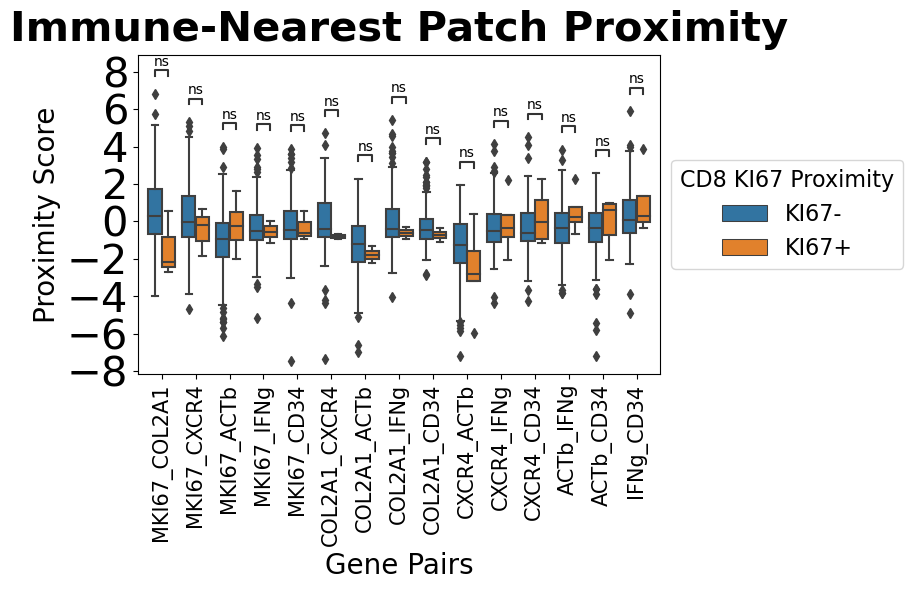

In [30]:
df = ki67_proxi_comp['set4']
df = df[df['Cell type'] == 'CD8']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Proximity"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Proximity',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD8 KI67 Proximity', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set4 cd8 ki67 gene proximity.png', bbox_inches="tight")
plt.show()

### combined statistical plotting

In [792]:
sig_pairs = ['ACTb_CD45', 'COL1A1_HLA-DRA', 'COL1A1_PD1', 'HLA-DRA_PD1', 'IL10_PD1','PD1_GAPDH','TNFa_COL2A1','COL2A1_IFNg','COL5A2_CXCL10']

In [793]:
proxi_comp_combined = []
for k in ki67_proxi_comp.keys():
    proxi_comp_combined.append(ki67_proxi_comp[k])
proxi_comp_combined = pd.concat(proxi_comp_combined)

In [794]:
proxi_comp_combined.head()

Gene Pair  Proximity KI67_label Cell type
1   IL6_IL8  -0.416588      KI67-       CD4
3   IL6_IL8  -1.005174      KI67-       CD4
5   IL6_IL8  -0.784109      KI67-       CD4
6   IL6_IL8  -0.361954      KI67-       CD4
7   IL6_IL8  -0.640646      KI67-       CD4

In [798]:
combined_subdf = proxi_comp_combined[proxi_comp_combined['Gene Pair'].isin(sig_pairs)]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

COL2A1_IFNg_CD4 v.s. COL2A1_IFNg_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=2.814e-01 U_stat=1.544e+04
COL1A1_HLA-DRA_CD4 v.s. COL1A1_HLA-DRA_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=4.268e-02 U_stat=2.522e+05
ACTb_CD45_CD4 v.s. ACTb_CD45_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=3.179e-03 U_stat=3.124e+05
COL1A1_PD1_CD4 v.s. COL1A1_PD1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=3.798e-01 U_stat=1.080e+05
HLA-DRA_PD1_CD4 v.s. HLA-DRA_PD1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=7.667e-01 U_stat=1.121e+05
IL10_PD1_CD4 v.s. IL10_PD1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=9.593e-01 U_stat=8.629e+04
PD1_GAPDH_CD4 v.s. PD1_GAPDH_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=2.586e-01 U_stat=1.212e+05
TNFa_COL2A1_CD4 v.s. TNFa_COL2A1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=5

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\3731938002.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


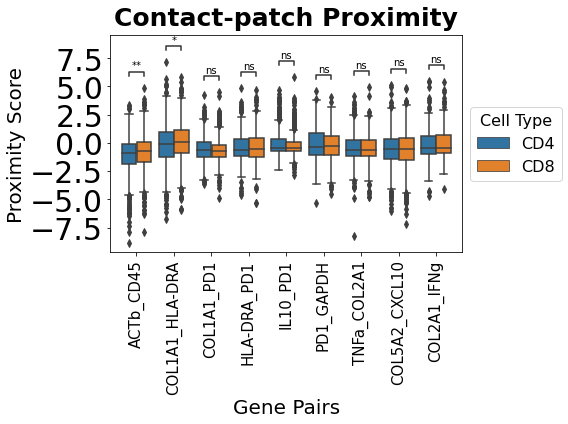

In [827]:
hue = "Cell type"
x = "Gene Pair"
# gp = df["Gene Pair"].unique()
y = "Proximity"
hue_order=['CD4','CD8']
plt.figure(figsize=(8, 6))
plt.title('Contact-patch Proximity',fontsize= 25, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in sig_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=combined_subdf, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=combined_subdf, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\combined cd4 cd8 gene proximity.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

COL2A1_IFNg_KI67- v.s. COL2A1_IFNg_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.828e-02 U_stat=8.000e+01
COL1A1_HLA-DRA_KI67- v.s. COL1A1_HLA-DRA_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.322e-01 U_stat=2.309e+04
ACTb_CD45_KI67- v.s. ACTb_CD45_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.130e-01 U_stat=3.162e+04
COL1A1_PD1_KI67- v.s. COL1A1_PD1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.657e-01 U_stat=7.952e+03
HLA-DRA_PD1_KI67- v.s. HLA-DRA_PD1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.349e-03 U_stat=1.200e+04
IL10_PD1_KI67- v.s. IL10_PD1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.539e-03 U_stat=5.397e+03
PD1_GAPDH_KI67- v.s. PD1_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.404e-04 U_stat=1.242e+04
TNFa_COL2A1_KI67- v.s. TNFa_COL2A1_KI67+: Mann-Whitney-

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\231166667.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


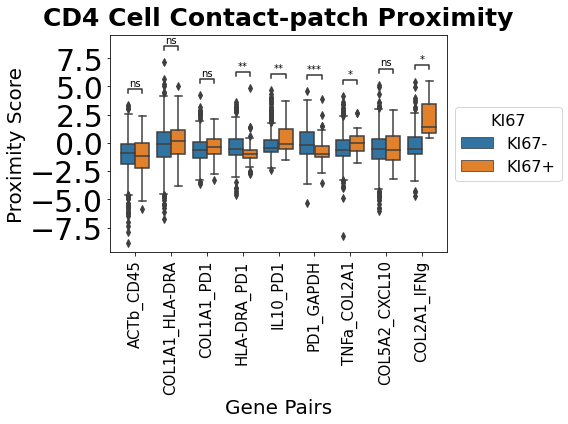

In [828]:
cd4_subdf = combined_subdf[combined_subdf['Cell type']=='CD4']

hue = "KI67_label"
x = "Gene Pair"
# gp = df["Gene Pair"].unique()
y = "Proximity"
hue_order=['KI67-','KI67+']
plt.figure(figsize=(8, 6))
plt.title('CD4 Cell Contact-patch Proximity',fontsize= 25, pad=10, fontweight ="bold")

comparisons = [((p, "KI67-"),(p, "KI67+")) for p in sig_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=cd4_subdf, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=cd4_subdf, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\combined cd4 ki67 gene proximity.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

COL2A1_IFNg_KI67+ v.s. COL2A1_IFNg_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=5.506e-01 U_stat=1.260e+02
COL1A1_HLA-DRA_KI67+ v.s. COL1A1_HLA-DRA_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=7.876e-02 U_stat=1.475e+04
ACTb_CD45_KI67+ v.s. ACTb_CD45_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=5.194e-01 U_stat=4.284e+04
COL1A1_PD1_KI67+ v.s. COL1A1_PD1_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=9.179e-01 U_stat=6.379e+03
HLA-DRA_PD1_KI67+ v.s. HLA-DRA_PD1_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=6.629e-01 U_stat=6.913e+03
IL10_PD1_KI67+ v.s. IL10_PD1_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=2.778e-01 U_stat=5.590e+03
PD1_GAPDH_KI67+ v.s. PD1_GAPDH_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=4.087e-01 U_stat=7.779e+03
TNFa_COL2A1_KI67+ v.s. TNFa_COL2A1_KI67-: Mann-Whitney-

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\2777992258.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


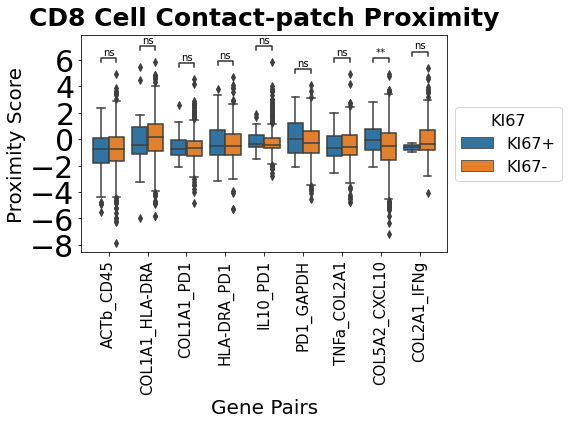

In [834]:
cd8_subdf = combined_subdf[combined_subdf['Cell type']=='CD8']

hue = "KI67_label"
x = "Gene Pair"
# gp = df["Gene Pair"].unique()
y = "Proximity"
hue_order=['KI67-','KI67+']
plt.figure(figsize=(8, 6))
plt.title('CD8 Cell Contact-patch Proximity',fontsize= 25, pad=10, fontweight ="bold")

comparisons = [((p, "KI67-"),(p, "KI67+")) for p in sig_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=cd8_subdf, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=cd8_subdf, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("Proximity Score",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\combined cd8 ki67 gene proximity.png', bbox_inches="tight")
plt.show()

# cd4 cd8 central embedding comparison

In [694]:
cd4_embedding_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\embedded_features\cd4'
fn_l = os.listdir(cd4_embedding_dir)
fn_l.sort()

cd4_embedding = {}
for fn in fn_l:
    if '.csv' in fn:
        embedding = pd.read_csv(os.path.join(cd4_embedding_dir,fn), index_col=0)
        cd4_embedding[fn.split('_')[1]] = embedding

cd8_embedding_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\embedded_features\cd8'
fn_l = os.listdir(cd8_embedding_dir)
fn_l.sort()

cd8_embedding = {}
for fn in fn_l:
    if '.csv' in fn:
        embedding = pd.read_csv(os.path.join(cd8_embedding_dir,fn), index_col=0)
        cd8_embedding[fn.split('_')[1]] = embedding

In [695]:
for k in cd4_embedding.keys():
    cd4_embedding[k]['patch_id'] = cd4_centers[k]['patch_id'].tolist()
    cd4_embedding[k]['cellID'] = cd4_centers[k]['cellID'].tolist()
    cd4_embedding[k]['row'] = cd4_centers[k]['row'].tolist()
    cd4_embedding[k]['col'] = cd4_centers[k]['col'].tolist()
    cd4_embedding[k]['z'] = cd4_centers[k]['z'].tolist()

for k in cd8_embedding.keys():
    cd8_embedding[k]['patch_id'] = cd8_centers[k]['patch_id'].tolist()
    cd8_embedding[k]['cellID'] = cd8_centers[k]['cellID'].tolist()
    cd8_embedding[k]['row'] = cd8_centers[k]['row'].tolist()
    cd8_embedding[k]['col'] = cd8_centers[k]['col'].tolist()
    cd8_embedding[k]['z'] = cd8_centers[k]['z'].tolist()

In [696]:
cd4_central_embedding = {}
for k in cd4_embedding.keys():
    embedding = cd4_embedding[k]
    mask = embedding['patch_id'].isin(cd4_central_proxi[k]['patch_id'].tolist())
    cd4_central_embedding[k] = embedding[mask]

cd8_central_embedding = {}
for k in cd8_embedding.keys():
    embedding = cd8_embedding[k]
    mask = embedding['patch_id'].isin(cd8_central_proxi[k]['patch_id'].tolist())
    cd8_central_embedding[k] = embedding[mask]

In [31]:
embedding_comp = {}
for k in cd4_central_embedding.keys():
    cd4_embedding = cd4_central_embedding[k].drop(columns=['cellID','row','col','z','patch_id','patch','KI67','KI67_label'])
    cd4_temp = cd4_embedding.melt(var_name='Feature', value_name='Embedding')
    cd8_embedding = cd8_central_embedding[k].drop(columns=['cellID','row','col','z','patch_id','patch','KI67','KI67_label'])
    cd8_temp = cd8_embedding.melt(var_name='Feature', value_name='Embedding')
    combined = pd.concat([cd4_temp,cd8_temp])
    combined['Cell type'] = ['CD4']*cd4_temp.shape[0] + ['CD8']*cd8_temp.shape[0]
    embedding_comp[k] = combined

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_CD4 v.s. 9_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.579e-02 U_stat=4.976e+05
8_CD4 v.s. 8_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.392e+05
1_CD4 v.s. 1_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.209e-10 U_stat=6.305e+05
0_CD4 v.s. 0_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.199e-01 U_stat=5.755e+05
2_CD4 v.s. 2_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.236e+05
3_CD4 v.s. 3_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.440e-03 U_stat=4.888e+05
4_CD4 v.s. 4_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.834e-01 U_stat=5.637e+05
5_CD4 v.s. 5_CD8: Mann-W

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\3779194561.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


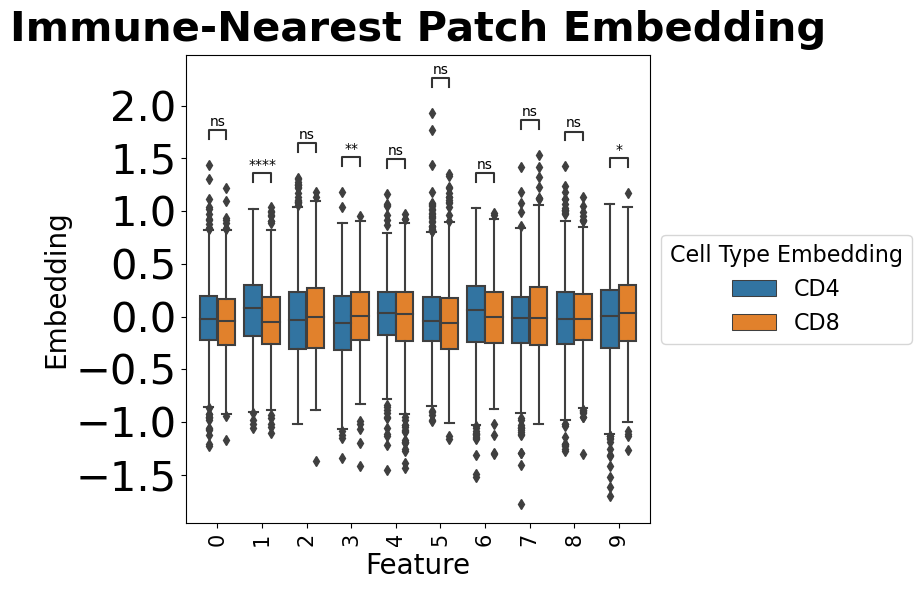

In [32]:
df = embedding_comp['set1']
channel_pairs = df["Feature"].unique()
hue = "Cell type"
x = "Feature"
gp = df["Feature"].unique()
y = "Embedding"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type Embedding', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set1 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_CD4 v.s. 9_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.200e+05
8_CD4 v.s. 8_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.670e-01 U_stat=3.399e+05
1_CD4 v.s. 1_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.642e-05 U_stat=3.597e+05
0_CD4 v.s. 0_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.855e-05 U_stat=2.740e+05
2_CD4 v.s. 2_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.327e+05
3_CD4 v.s. 3_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.122e+05
4_CD4 v.s. 4_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.735e-02 U_stat=2.919e+05
5_CD4 v.s. 5_CD8: Mann-W

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\3961706537.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


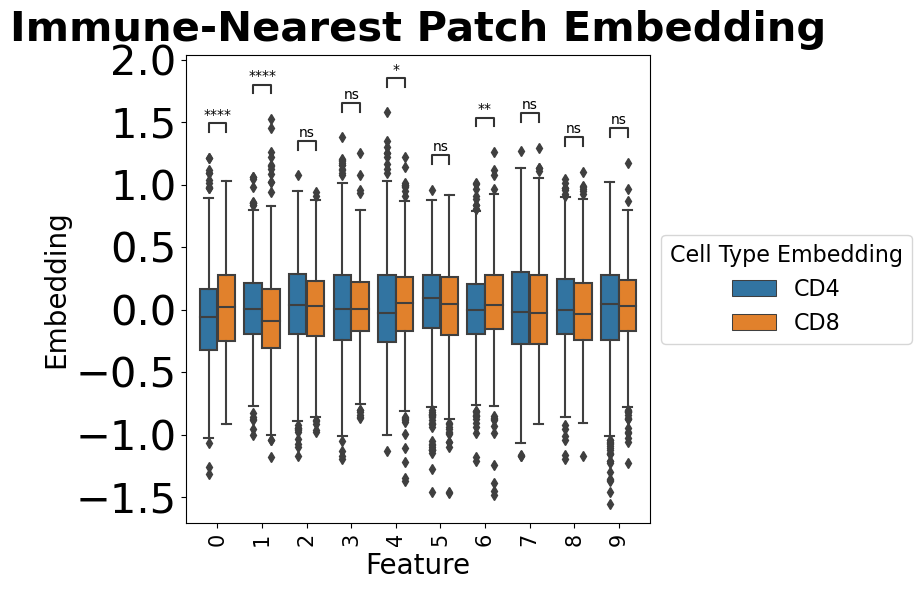

In [33]:
df = embedding_comp['set2']
channel_pairs = df["Feature"].unique()
hue = "Cell type"
x = "Feature"
gp = df["Feature"].unique()
y = "Embedding"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type Embedding', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set2 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show()

## set 2

In [ ]:
motif_train_x_set2,motif_test_x_set2,motif_train_y_set2,motif_test_y_set2 = train_test_split(set2_embedding_adata.X,set2_embedding_adata.obs['label'].tolist(),test_size=0.2,random_state=42)
proxi_train_x_set2,proxi_test_x_set2,proxi_train_y_set2,proxi_test_y_set2 = train_test_split(set2_proxi_adata.X,set2_proxi_adata.obs['label'].tolist(),test_size=0.2,random_state=42)

In [ ]:
clf = SVC(kernel='sigmoid',C=1)
clf.fit(motif_train_x_set2,motif_train_y_set2)
prediction = clf.predict(motif_test_x_set2)

l = np.unique(set2_embedding_adata.obs['label'].tolist())
con = confusion_matrix(motif_test_y_set2,prediction,labels=l)
con = pd.DataFrame(con, columns=l, index=l)

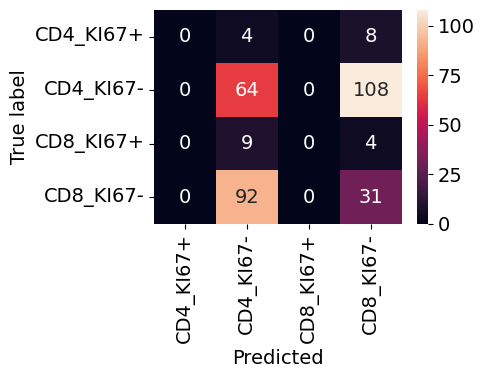

In [ ]:
with rc_context({'font.size':14}):
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    sns.heatmap(con,annot=True,fmt='d',ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True label')
    plt.tight_layout()
    plt.savefig(r'.\figures\motif_classification_set2.png',dpi=300)
    plt.show()

In [ ]:
clf.fit(proxi_train_x_set2,proxi_train_y_set2)
prediction = clf.predict(proxi_test_x_set2)

l = np.unique(set2_proxi_adata.obs['label'].tolist())
con = confusion_matrix(proxi_test_y_set2,prediction,labels=l)
con = pd.DataFrame(con, columns=l, index=l)

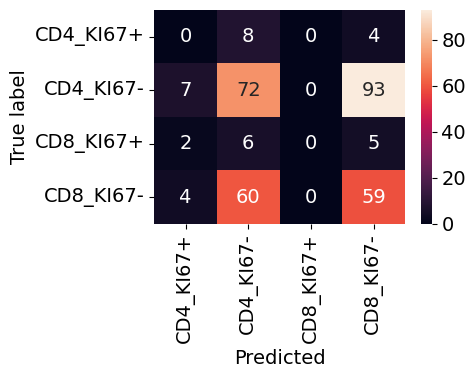

In [ ]:
with rc_context({'font.size':14}):
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    sns.heatmap(con,annot=True,fmt='d',ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True label')
    plt.tight_layout()
    plt.savefig(r'.\figures\proxi_classification_set2.png',dpi=300)
    plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_CD4 v.s. 9_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.652e+05
8_CD4 v.s. 8_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.025e-01 U_stat=8.320e+05
1_CD4 v.s. 1_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.945e+05
0_CD4 v.s. 0_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.677e+05
2_CD4 v.s. 2_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.031e-06 U_stat=9.820e+05
3_CD4 v.s. 3_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.314e-03 U_stat=8.101e+05
4_CD4 v.s. 4_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.837e-02 U_stat=8.161e+05
5_CD4 v.s. 5_CD8: Mann-W

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\113748814.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


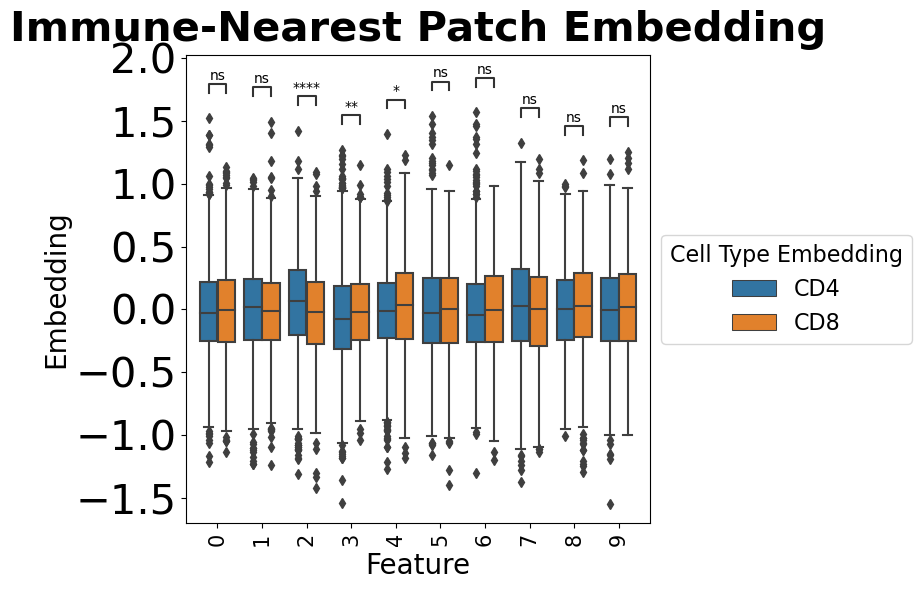

In [34]:
df = embedding_comp['set3']
channel_pairs = df["Feature"].unique()
hue = "Cell type"
x = "Feature"
gp = df["Feature"].unique()
y = "Embedding"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type Embedding', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set3 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_CD4 v.s. 9_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.194e+05
8_CD4 v.s. 8_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.275e+05
1_CD4 v.s. 1_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.210e+05
0_CD4 v.s. 0_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.194e+05
2_CD4 v.s. 2_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.166e+05
3_CD4 v.s. 3_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.228e+05
4_CD4 v.s. 4_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.326e-01 U_stat=1.323e+05
5_CD4 v.s. 5_CD8: Mann-W

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\3809614363.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


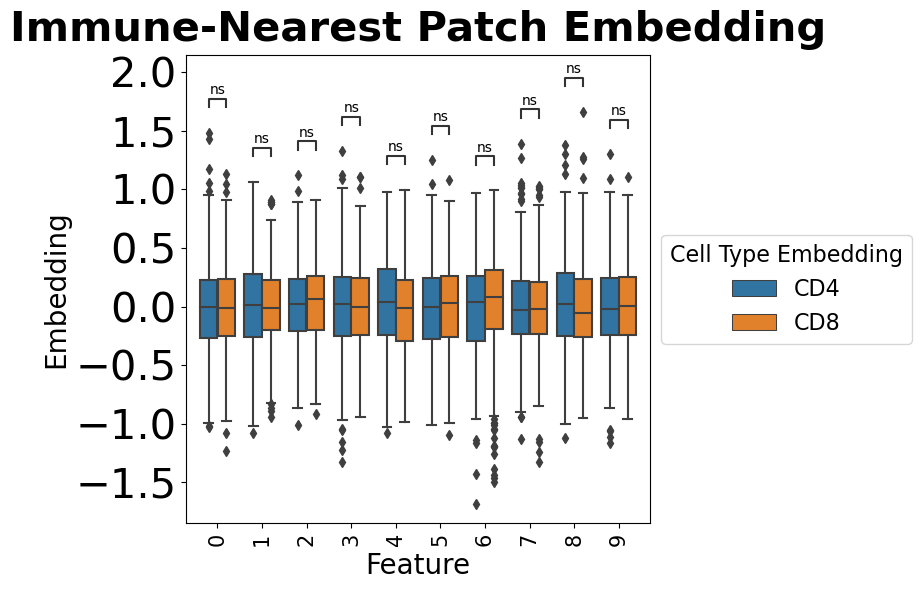

In [35]:
df = embedding_comp['set4']
channel_pairs = df["Feature"].unique()
hue = "Cell type"
x = "Feature"
gp = df["Feature"].unique()
y = "Embedding"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type Embedding', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set4 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show()

## ki67 level comparison

In [702]:
for k in cd4_central_proxi.keys():
    ki67 = cd4_central_proxi[k]['KI67'].to_numpy() > cd4_ki67_thre
    ki67_label = ['KI67+' if i else 'KI67-' for i in ki67]
    cd4_central_proxi[k]['KI67_label'] = ki67_label
for k in cd8_central_proxi.keys():
    ki67 = cd8_central_proxi[k]['KI67'].to_numpy() > cd8_ki67_thre
    ki67_label = ['KI67+' if i else 'KI67-' for i in ki67]
    cd8_central_proxi[k]['KI67_label'] = ki67_label

In [703]:
for k in cd4_central_embedding.keys():
    ki67 = []
    for cell in cd4_central_embedding[k]['cellID']:
        ki67.append(cd4_ki67[cd4_ki67['cellID']==cell]['KI67'].tolist()[0])
    cd4_central_embedding[k]['KI67'] = ki67
    ki67_l = np.array(ki67) > cd4_ki67_thre
    ki67_label = ['KI67+' if i else 'KI67-' for i in ki67_l]
    cd4_central_embedding[k]['KI67_label'] = ki67_label

for k in cd8_central_embedding.keys():
    ki67 = []
    for cell in cd8_central_embedding[k]['cellID']:
        ki67.append(cd8_ki67[cd8_ki67['cellID']==cell]['KI67'].tolist()[0])
    cd8_central_embedding[k]['KI67'] = ki67
    ki67_l = np.array(ki67) > cd8_ki67_thre
    ki67_label = ['KI67+' if i else 'KI67-' for i in ki67_l]
    cd8_central_embedding[k]['KI67_label'] = ki67_label

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\103834079.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd8_central_embedding[k]['KI67'] = ki67
C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\103834079.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd8_central_embedding[k]['KI67_label'] = ki67_label


In [36]:
ki67_embedding_comp = {}
for k in cd4_central_embedding.keys():
    cd4_ki67_label = cd4_central_embedding[k]['KI67_label'].tolist()
    cd4_embedding = cd4_central_embedding[k].drop(columns=['cellID','row','col','z','patch_id','KI67','KI67_label','patch'])
    cd4_temp = cd4_embedding.melt(var_name='Feature', value_name='Value')
    cd4_temp['KI67_label'] = cd4_ki67_label * cd4_embedding.shape[1]

    cd8_ki67_label = cd8_central_embedding[k]['KI67_label'].tolist()
    cd8_embedding = cd8_central_embedding[k].drop(columns=['cellID','row','col','z','patch_id','KI67','KI67_label','patch'])
    cd8_temp = cd8_embedding.melt(var_name='Feature', value_name='Value')
    cd8_temp['KI67_label'] = cd8_ki67_label * cd8_embedding.shape[1]

    combined = pd.concat([cd4_temp,cd8_temp])
    combined['Cell type'] = ['CD4']*cd4_temp.shape[0] + ['CD8']*cd8_temp.shape[0]
    ki67_embedding_comp[k] = combined

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_KI67- v.s. 9_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.201e-02 U_stat=5.289e+04
8_KI67- v.s. 8_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.658e-01 U_stat=4.330e+04
1_KI67- v.s. 1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.111e-01 U_stat=5.124e+04
0_KI67- v.s. 0_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.173e-02 U_stat=4.101e+04
2_KI67- v.s. 2_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.054e-01 U_stat=4.366e+04
3_KI67- v.s. 3_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.708e-01 U_stat=5.160e+04
4_KI67- v.s. 4_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.057e-01 U_stat=4.260e+04
5_KI67- v.s. 5_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.621e-02 U_stat=4.024e+04
6_KI67- v.s. 6_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.225e-01 U_stat=4.940e+04

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\791787811.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


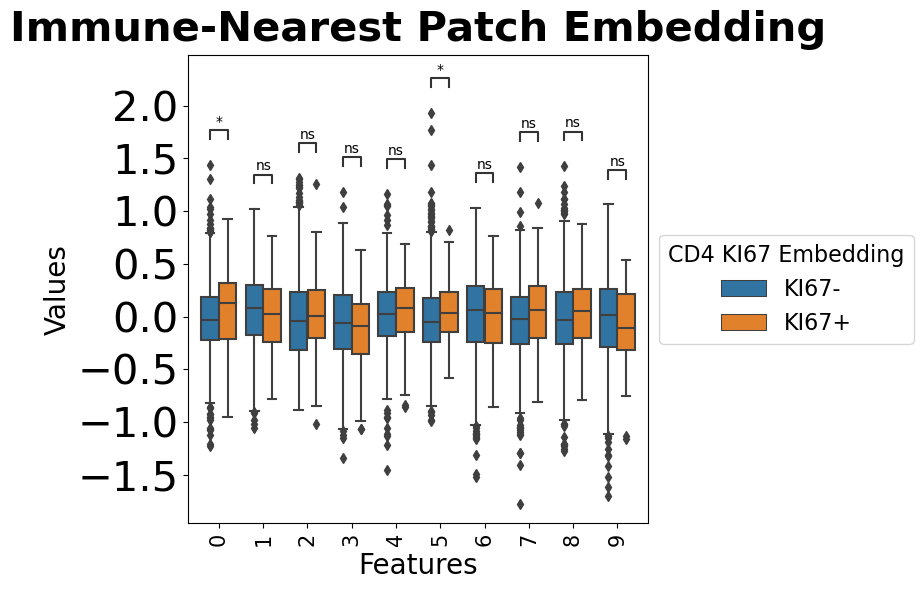

In [37]:
df = ki67_embedding_comp['set1']
df = df[df['Cell type'] == 'CD4']
channel_pairs = df["Feature"].unique()
hue = "KI67_label"
x = "Feature"
gp = df["Feature"].unique()
y = "Value"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Features",fontsize=20)
g.set_ylabel("Values",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD4 KI67 Embedding', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set1 cd4 ki67 embedding.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_KI67- v.s. 9_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.150e-02 U_stat=2.614e+04
8_KI67- v.s. 8_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.573e-01 U_stat=2.772e+04
1_KI67- v.s. 1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.452e-01 U_stat=3.120e+04
0_KI67- v.s. 0_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.259e-01 U_stat=2.646e+04
2_KI67- v.s. 2_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.617e-04 U_stat=3.743e+04
3_KI67- v.s. 3_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.326e-01 U_stat=3.092e+04
4_KI67- v.s. 4_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.476e-02 U_stat=3.427e+04
5_KI67- v.s. 5_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.394e-01 U_stat=3.160e+04
6_KI67- v.s. 6_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.357e-04 U_stat=3.690e+04

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\2525877671.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


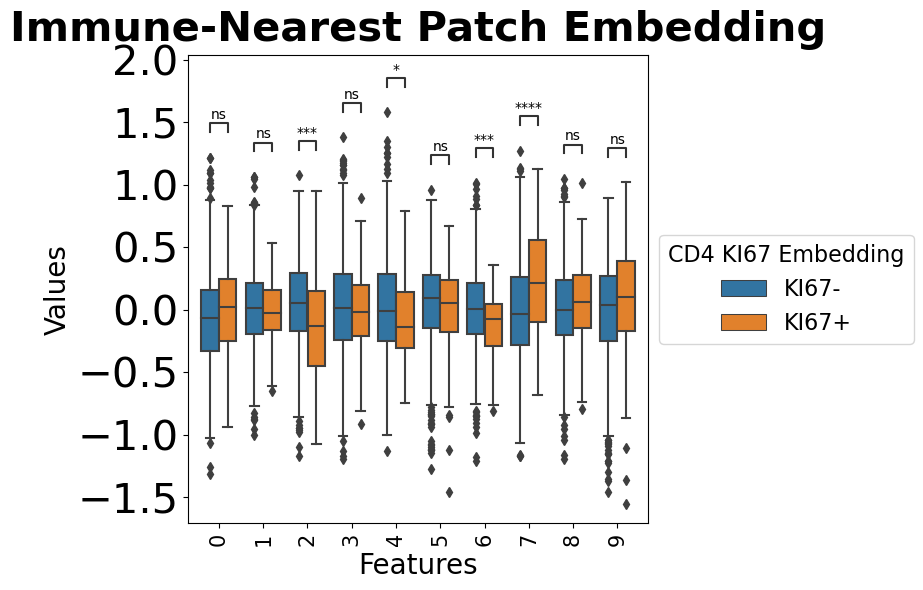

In [38]:
df = ki67_embedding_comp['set2']
df = df[df['Cell type'] == 'CD4']
channel_pairs = df["Feature"].unique()
hue = "KI67_label"
x = "Feature"
gp = df["Feature"].unique()
y = "Value"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Features",fontsize=20)
g.set_ylabel("Values",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD4 KI67 Embedding', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set2 cd4 ki67 embedding.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_KI67- v.s. 9_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.367e-01 U_stat=5.072e+04
8_KI67- v.s. 8_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.158e-02 U_stat=4.515e+04
1_KI67- v.s. 1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.906e-01 U_stat=4.938e+04
0_KI67- v.s. 0_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.055e-01 U_stat=5.396e+04
2_KI67- v.s. 2_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.204e-01 U_stat=5.286e+04
3_KI67- v.s. 3_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.220e-01 U_stat=4.612e+04
4_KI67- v.s. 4_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.549e-01 U_stat=5.424e+04
5_KI67- v.s. 5_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.629e-01 U_stat=4.774e+04
6_KI67- v.s. 6_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.729e-01 U_stat=4.682e+04

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\207126246.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


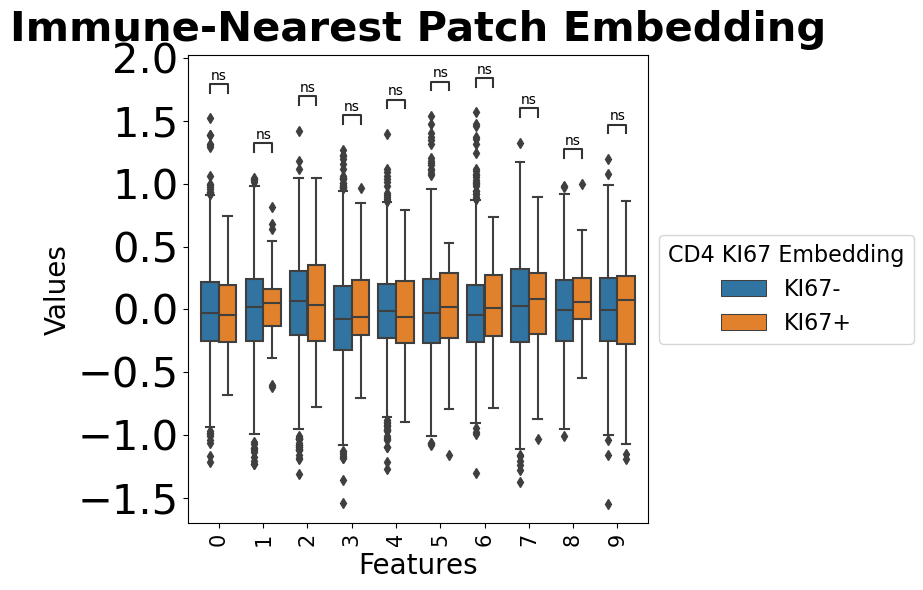

In [39]:
df = ki67_embedding_comp['set3']
df = df[df['Cell type'] == 'CD4']
channel_pairs = df["Feature"].unique()
hue = "KI67_label"
x = "Feature"
gp = df["Feature"].unique()
y = "Value"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Features",fontsize=20)
g.set_ylabel("Values",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD4 KI67 Embedding', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set3 cd4 ki67 embedding.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_KI67- v.s. 9_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.509e-01 U_stat=2.108e+03
8_KI67- v.s. 8_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.449e-01 U_stat=2.836e+03
1_KI67- v.s. 1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.305e-01 U_stat=2.985e+03
0_KI67- v.s. 0_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.754e-01 U_stat=2.006e+03
2_KI67- v.s. 2_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.685e-01 U_stat=2.695e+03
3_KI67- v.s. 3_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.014e-03 U_stat=4.060e+03
4_KI67- v.s. 4_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.318e-01 U_stat=2.366e+03
5_KI67- v.s. 5_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.185e-01 U_stat=2.726e+03
6_KI67- v.s. 6_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.686e-03 U_stat=1.125e+03

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\2536681422.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


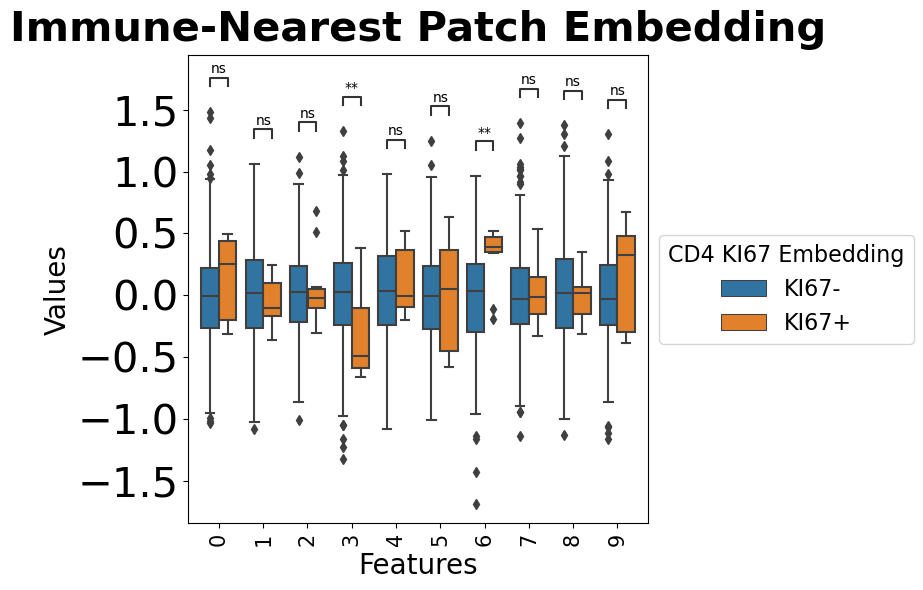

In [40]:
df = ki67_embedding_comp['set4']
df = df[df['Cell type'] == 'CD4']
channel_pairs = df["Feature"].unique()
hue = "KI67_label"
x = "Feature"
gp = df["Feature"].unique()
y = "Value"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Features",fontsize=20)
g.set_ylabel("Values",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD4 KI67 Embedding', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set4 cd4 ki67 embedding.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_KI67+ v.s. 9_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=9.521e-01 U_stat=6.607e+04
8_KI67+ v.s. 8_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=4.769e-01 U_stat=6.817e+04
1_KI67+ v.s. 1_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=8.515e-01 U_stat=6.527e+04
0_KI67+ v.s. 0_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=5.118e-01 U_stat=6.799e+04
2_KI67+ v.s. 2_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=3.241e-03 U_stat=5.639e+04
3_KI67+ v.s. 3_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=2.369e-02 U_stat=7.317e+04
4_KI67+ v.s. 4_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=3.263e-01 U_stat=6.271e+04
5_KI67+ v.s. 5_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=1.095e-01 U_stat=7.103e+04
6_KI67+ v.s. 6_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=4.307e-01 U_stat=6.842e+04

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\1252742150.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


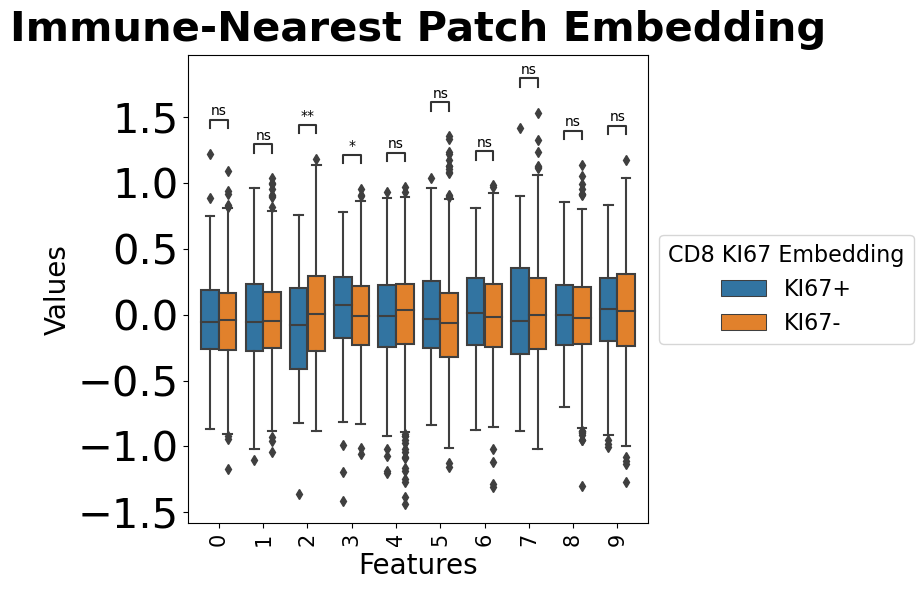

In [41]:
df = ki67_embedding_comp['set1']
df = df[df['Cell type'] == 'CD8']
channel_pairs = df["Feature"].unique()
hue = "KI67_label"
x = "Feature"
gp = df["Feature"].unique()
y = "Value"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Features",fontsize=20)
g.set_ylabel("Values",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD8 KI67 Embedding', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set1 cd8 ki67 embedding.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_KI67- v.s. 9_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.411e-02 U_stat=1.721e+04
8_KI67- v.s. 8_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.882e-01 U_stat=2.047e+04
1_KI67- v.s. 1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.652e-01 U_stat=1.934e+04
0_KI67- v.s. 0_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.710e-02 U_stat=2.295e+04
2_KI67- v.s. 2_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.538e-01 U_stat=1.879e+04
3_KI67- v.s. 3_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.911e-01 U_stat=1.819e+04
4_KI67- v.s. 4_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.740e-01 U_stat=1.811e+04
5_KI67- v.s. 5_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.572e-03 U_stat=1.617e+04
6_KI67- v.s. 6_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.443e-01 U_stat=1.904e+04

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\1951279202.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


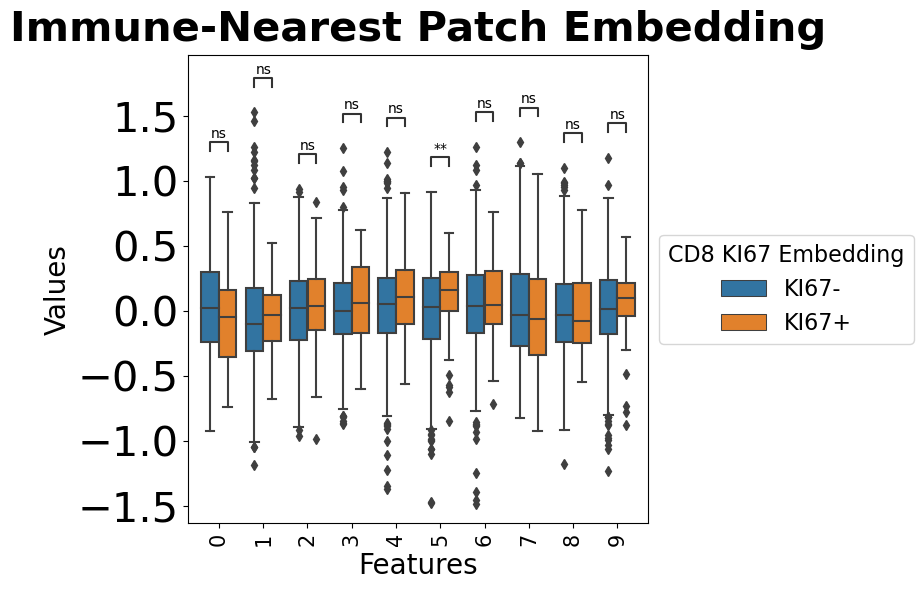

In [42]:
df = ki67_embedding_comp['set2']
df = df[df['Cell type'] == 'CD8']
channel_pairs = df["Feature"].unique()
hue = "KI67_label"
x = "Feature"
gp = df["Feature"].unique()
y = "Value"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Features",fontsize=20)
g.set_ylabel("Values",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD8 KI67 Embedding', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set2 cd8 ki67 embedding.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_KI67- v.s. 9_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.038e-01 U_stat=3.276e+04
8_KI67- v.s. 8_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.425e-02 U_stat=2.576e+04
1_KI67- v.s. 1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.500e-01 U_stat=2.812e+04
0_KI67- v.s. 0_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.647e-02 U_stat=3.406e+04
2_KI67- v.s. 2_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.569e-03 U_stat=3.597e+04
3_KI67- v.s. 3_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.943e-01 U_stat=3.180e+04
4_KI67- v.s. 4_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.695e-01 U_stat=2.994e+04
5_KI67- v.s. 5_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.629e-01 U_stat=2.665e+04
6_KI67- v.s. 6_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.130e-01 U_stat=2.754e+04

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\3393531235.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


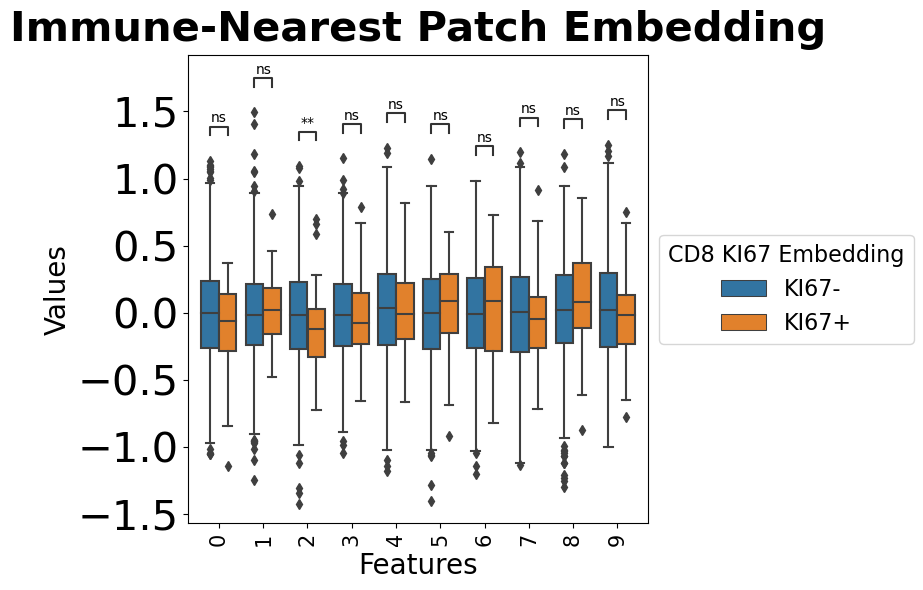

In [43]:
df = ki67_embedding_comp['set3']
df = df[df['Cell type'] == 'CD8']
channel_pairs = df["Feature"].unique()
hue = "KI67_label"
x = "Feature"
gp = df["Feature"].unique()
y = "Value"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Features",fontsize=20)
g.set_ylabel("Values",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD8 KI67 Embedding', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set3 cd8 ki67 embedding.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_KI67- v.s. 9_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.259e-03 U_stat=1.095e+03
8_KI67- v.s. 8_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.357e-02 U_stat=3.168e+03
1_KI67- v.s. 1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.636e-01 U_stat=2.625e+03
0_KI67- v.s. 0_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.271e-01 U_stat=2.789e+03
2_KI67- v.s. 2_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.639e-02 U_stat=2.888e+03
3_KI67- v.s. 3_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.205e-02 U_stat=1.165e+03
4_KI67- v.s. 4_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.355e-02 U_stat=2.895e+03
5_KI67- v.s. 5_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.387e-03 U_stat=1.029e+03
6_KI67- v.s. 6_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.453e-01 U_stat=1.795e+03

C:\Users\zfang38\AppData\Local\Temp\ipykernel_49300\4077367647.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


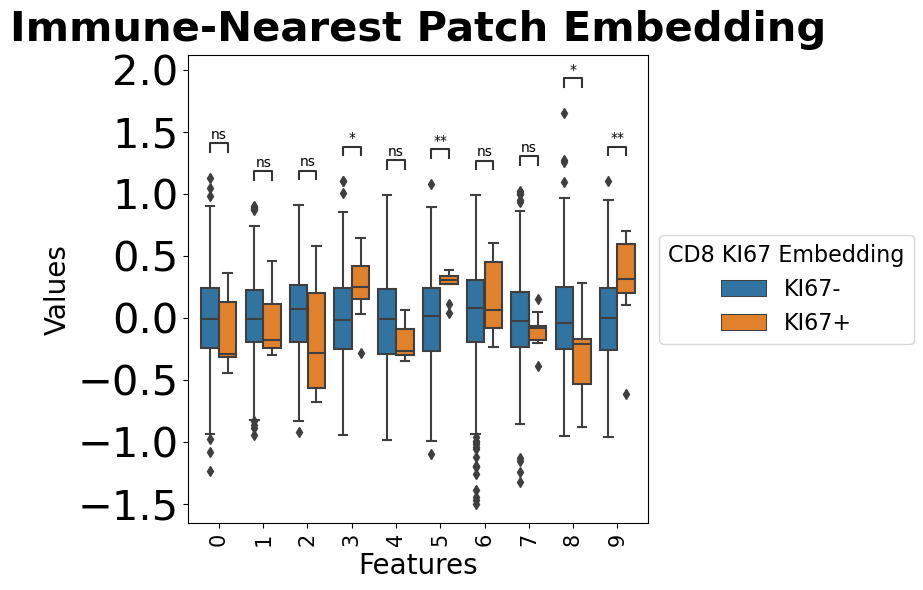

In [44]:
df = ki67_embedding_comp['set4']
df = df[df['Cell type'] == 'CD8']
channel_pairs = df["Feature"].unique()
hue = "KI67_label"
x = "Feature"
gp = df["Feature"].unique()
y = "Value"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Immune-Nearest Patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Features",fontsize=20)
g.set_ylabel("Values",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='CD8 KI67 Embedding', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set4 cd8 ki67 embedding.png', bbox_inches="tight")
plt.show()

## Combined embedding comparison

In [813]:
embedding_comp_combined = []
for k in ki67_embedding_comp.keys():
    temp = ki67_embedding_comp[k]
    temp['Feature'] = 'Exp'+k[-1]+'_'+temp['Feature']
    embedding_comp_combined.append(temp)
embeddeing_comp_combined = pd.concat(embedding_comp_combined)

In [815]:
embeddeing_comp_combined.head()

Feature     Value KI67_label Cell type
0  Exp1_0 -0.392285      KI67-       CD4
1  Exp1_0 -0.541464      KI67-       CD4
2  Exp1_0 -0.437615      KI67-       CD4
3  Exp1_0 -0.347549      KI67-       CD4
4  Exp1_0 -0.500354      KI67-       CD4

In [821]:
sig_feat = ['Exp1_0','Exp1_1','Exp1_2','Exp2_0','Exp2_1','Exp2_5','Exp3_2','Exp3_3','Exp3_4','Exp4_3','Exp4_5','Exp4_6']
embedding_subdf = embeddeing_comp_combined[embeddeing_comp_combined['Feature'].isin(sig_feat)]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Exp4_3_CD4 v.s. Exp4_3_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=7.321e-01 U_stat=1.228e+05
Exp4_5_CD4 v.s. Exp4_5_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=4.342e-01 U_stat=1.178e+05
Exp4_6_CD4 v.s. Exp4_6_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=4.068e-02 U_stat=1.121e+05
Exp3_4_CD4 v.s. Exp3_4_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=1.837e-03 U_stat=8.161e+05
Exp1_1_CD4 v.s. Exp1_1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=7.209e-11 U_stat=6.305e+05
Exp1_0_CD4 v.s. Exp1_0_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=1.199e-02 U_stat=5.755e+05
Exp1_2_CD4 v.s. Exp1_2_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=2.048e-01 U_stat=5.236e+05
Exp2_0_CD4 v.s. Exp2_0_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=1.855e-06 U_stat=2.740e+05
Exp2_1_CD4 v.s. Exp2_1_CD8: Mann-Whitney-Wil

Exp3_3_CD4 v.s. Exp3_3_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=6.314e-04 U_stat=8.101e+05


C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\535470163.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


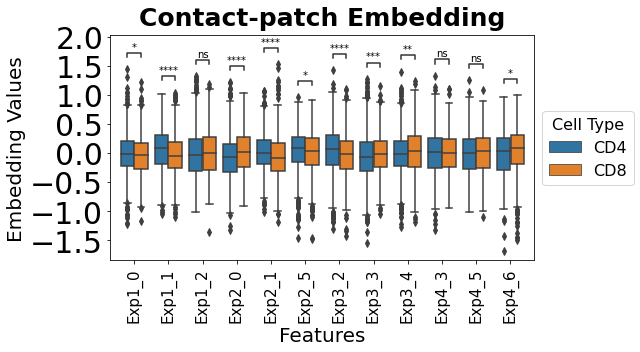

In [830]:
hue = "Cell type"
x = "Feature"
# gp = df["Gene Pair"].unique()
y = "Value"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 5))
plt.title('Contact-patch Embedding',fontsize= 25, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in sig_feat]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=embedding_subdf, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=embedding_subdf, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Features",fontsize=20)
g.set_ylabel("Embedding Values",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\combined cd4 cd8 embedding.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Exp4_3_KI67- v.s. Exp4_3_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.014e-03 U_stat=4.060e+03
Exp4_5_KI67- v.s. Exp4_5_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.185e-01 U_stat=2.726e+03
Exp4_6_KI67- v.s. Exp4_6_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.686e-03 U_stat=1.125e+03
Exp3_4_KI67- v.s. Exp3_4_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.549e-01 U_stat=5.424e+04
Exp1_1_KI67- v.s. Exp1_1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.111e-01 U_stat=5.124e+04
Exp1_0_KI67- v.s. Exp1_0_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.173e-02 U_stat=4.101e+04
Exp1_2_KI67- v.s. Exp1_2_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.054e-01 U_stat=4.366e+04
Exp2_0_KI67- v.s. Exp2_0_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.259e-01 U_stat=2.646e+04
Exp2_1_KI67-

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\770697036.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


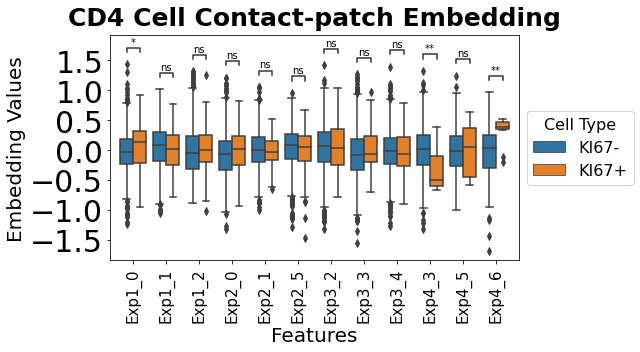

In [831]:
cd4_embedding_subdf = embedding_subdf[embedding_subdf['Cell type']=='CD4']

hue = "KI67_label"
x = "Feature"
# gp = df["Gene Pair"].unique()
y = "Value"
hue_order=['KI67-','KI67+']
plt.figure(figsize=(9, 5))
plt.title('CD4 Cell Contact-patch Embedding',fontsize= 25, pad=10, fontweight ="bold")

comparisons = [((p, "KI67-"),(p, "KI67+")) for p in sig_feat]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=cd4_embedding_subdf, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=cd4_embedding_subdf, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Features",fontsize=20)
g.set_ylabel("Embedding Values",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\combined cd4 ki67 embedding.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Exp4_3_KI67+ v.s. Exp4_3_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=1.205e-02 U_stat=3.185e+03
Exp4_5_KI67+ v.s. Exp4_5_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=4.387e-03 U_stat=3.321e+03
Exp4_6_KI67+ v.s. Exp4_6_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=3.453e-01 U_stat=2.555e+03
Exp3_4_KI67+ v.s. Exp3_4_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=9.695e-01 U_stat=2.976e+04
Exp1_1_KI67+ v.s. Exp1_1_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=8.515e-01 U_stat=6.527e+04
Exp1_0_KI67+ v.s. Exp1_0_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=5.118e-01 U_stat=6.799e+04
Exp1_2_KI67+ v.s. Exp1_2_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=3.241e-03 U_stat=5.639e+04
Exp2_0_KI67+ v.s. Exp2_0_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=8.710e-02 U_stat=1.755e+04
Exp2_1_KI67+

Exp2_5_KI67+ v.s. Exp2_5_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=9.572e-03 U_stat=2.433e+04
Exp3_2_KI67+ v.s. Exp3_2_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=7.569e-03 U_stat=2.373e+04
Exp3_3_KI67+ v.s. Exp3_3_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=3.943e-01 U_stat=2.790e+04


C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\2813601225.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


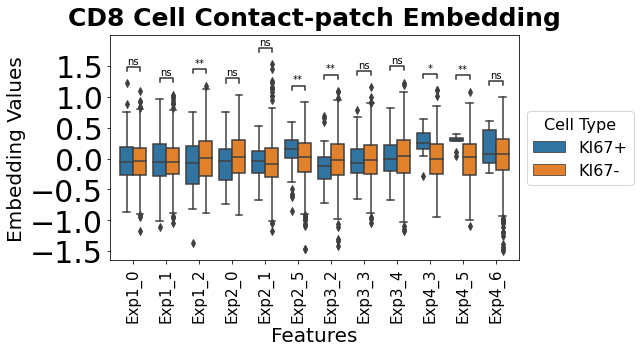

In [833]:
cd8_embedding_subdf = embedding_subdf[embedding_subdf['Cell type']=='CD8']

hue = "KI67_label"
x = "Feature"
# gp = df["Gene Pair"].unique()
y = "Value"
hue_order=['KI67-','KI67+']
plt.figure(figsize=(9, 5))
plt.title('CD8 Cell Contact-patch Embedding',fontsize= 25, pad=10, fontweight ="bold")

comparisons = [((p, "KI67-"),(p, "KI67+")) for p in sig_feat]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=cd8_embedding_subdf, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=cd8_embedding_subdf, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Features",fontsize=20)
g.set_ylabel("Embedding Values",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\combined cd8 ki67 embedding.png', bbox_inches="tight")
plt.show()

# identify index of proximal patch

In [835]:
cd4_central_proxi.keys()

dict_keys(['set1', 'set2', 'set3', 'set4'])

# patch rna count

In [713]:
import util

In [714]:
gene_sets = pd.read_pickle(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gene_set.pkl')

In [715]:
# Patch count for all patches, all microenvironment
cd4_patch_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\patched_cell_df\cd4'
fn_l = os.listdir(cd4_patch_dir)
fn_l.sort()
cd4_patch_counts = {'set1':[],'set2':[],'set3':[],'set4':[]}
for fn in tqdm(fn_l):
    if '.csv' in fn:
        patch = pd.read_csv(os.path.join(cd4_patch_dir,fn), index_col=0)
        fov = fn.split('_')[0]
        gene_name = [''] * patch.shape[0]
        if int(fov) < 30:
            s = 'set1'
        elif int(fov) < 60:
            s = 'set2'
        elif int(fov) < 90:
            s = 'set3'
        else:
            s = 'set4'
        for i,g in enumerate(patch['gene'].tolist()):
            gene_name[i] = gene_sets[s][g.split('_')[1]]
        patch['gene_name'] = gene_name
        
        patch_id = fn.split('.')[0] + '_' + patch['leiden'].astype('str')
        patch['patch_id'] = patch_id.tolist()

        count = util.counting(patch, 'patch_id', 'gene_name')
        cd4_patch_counts[s].append(count)

100%|██████████| 844/844 [01:49<00:00,  7.74it/s]


In [724]:
for k in cd4_patch_counts.keys():
    cd4_patch_counts[k] = pd.concat(cd4_patch_counts[k])

In [725]:
# find patch count for central patches
cd4_central_count = {}
for s in gene_sets.keys():
    cd4_central_count[s] = cd4_patch_counts[s][cd4_patch_counts[s]['Count_id'].isin(cd4_central_proxi[s]['patch_id'].tolist())]

In [726]:
# Patch count for all patches, all microenvironment
cd8_patch_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\patched_cell_df\cd8'
fn_l = os.listdir(cd8_patch_dir)
fn_l.sort()
cd8_patch_counts = {'set1':[],'set2':[],'set3':[],'set4':[]}
for fn in tqdm(fn_l):
    if '.csv' in fn:
        patch = pd.read_csv(os.path.join(cd8_patch_dir,fn), index_col=0)
        fov = fn.split('_')[0]
        gene_name = [''] * patch.shape[0]
        if int(fov) < 30:
            s = 'set1'
        elif int(fov) < 60:
            s = 'set2'
        elif int(fov) < 90:
            s = 'set3'
        else:
            s = 'set4'
        for i,g in enumerate(patch['gene'].tolist()):
            gene_name[i] = gene_sets[s][g.split('_')[1]]
        patch['gene_name'] = gene_name
        
        patch_id = fn.split('.')[0] + '_' + patch['leiden'].astype('str')
        patch['patch_id'] = patch_id.tolist()

        count = util.counting(patch, 'patch_id', 'gene_name')
        cd8_patch_counts[s].append(count)

100%|██████████| 636/636 [01:10<00:00,  9.01it/s]


In [727]:
for k in cd8_patch_counts.keys():
    cd8_patch_counts[k] = pd.concat(cd8_patch_counts[k])

In [728]:
# find patch count for central patches
cd8_central_count = {}
for s in gene_sets.keys():
    cd8_central_count[s] = cd8_patch_counts[s][cd8_patch_counts[s]['Count_id'].isin(cd8_central_proxi[s]['patch_id'].tolist()) == True]

## cd4 v. cd8 comparison

In [732]:
count_stat_df = {}
for k in cd8_central_count.keys():
    cd4_count_temp = cd4_central_count[k]
    temp = cd4_count_temp.drop(columns=['Count_id'])
    cd4_melt = temp.melt(var_name='Gene', value_name='Count')
    cd4_melt['Count'] = cd4_melt['Count'].astype('float')

    cd8_count_temp = cd8_central_count[k]
    temp = cd8_count_temp.drop(columns=['Count_id'])
    cd8_melt = temp.melt(var_name='Gene', value_name='Count')
    cd8_melt['Count'] = cd8_melt['Count'].astype('float')

    count_stat_df[k] = pd.concat([cd4_melt,cd8_melt])
    count_stat_df[k]['Cell Type'] = ['CD4'] * cd4_melt.shape[0] + ['CD8'] * cd8_melt.shape[0]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CD45_CD4 v.s. CD45_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.568e+05
ACTb_CD4 v.s. ACTb_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.850e-01 U_stat=5.682e+05
COL1A1_CD4 v.s. COL1A1_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.149e-02 U_stat=4.984e+05
IFNa_CD4 v.s. IFNa_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.410e+05
IL6_CD4 v.s. IL6_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.463e+05
IL8_CD4 v.s. IL8_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.535e+05


C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\311115817.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


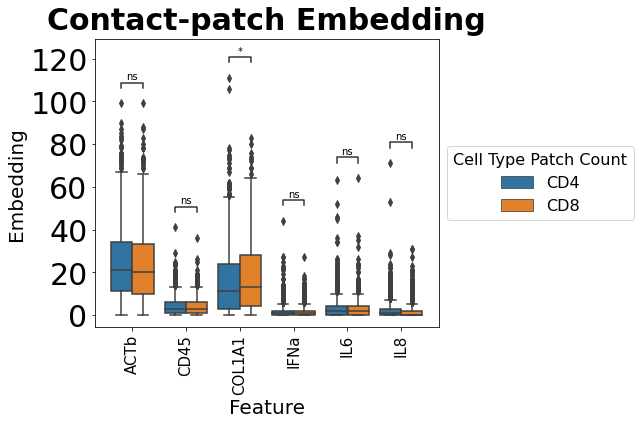

In [733]:
df = count_stat_df['set1']
channel_pairs = df["Gene"].unique()
hue = "Cell Type"
x = "Gene"
gp = df["Gene"].unique()
y = "Count"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type Patch Count', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(r'.\figures\set4 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

GAPDH_CD4 v.s. GAPDH_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.868e-01 U_stat=3.051e+05
COL1A1_CD4 v.s. COL1A1_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.531e-03 U_stat=3.515e+05
HLA-DRA_CD4 v.s. HLA-DRA_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.214e+05
IL10_CD4 v.s. IL10_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.269e+05
PD1_CD4 v.s. PD1_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.672e-02 U_stat=2.950e+05
PDL1_CD4 v.s. PDL1_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.524e-01 U_stat=3.363e+05


C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\3051032443.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


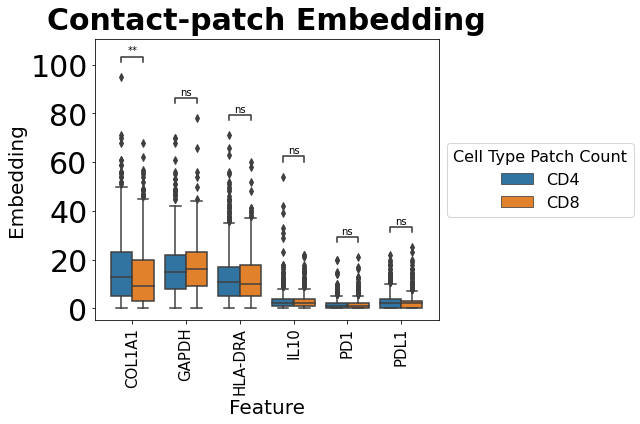

In [734]:
df = count_stat_df['set2']
channel_pairs = df["Gene"].unique()
hue = "Cell Type"
x = "Gene"
gp = df["Gene"].unique()
y = "Count"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type Patch Count', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(r'.\figures\set4 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

COL2A1_CD4 v.s. COL2A1_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.572e+05
CCL11_CD4 v.s. CCL11_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.215e-02 U_stat=8.181e+05
COL5A2_CD4 v.s. COL5A2_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.023e-01 U_stat=8.360e+05
CXCL10_CD4 v.s. CXCL10_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.816e-01 U_stat=9.214e+05
PDL1_CD4 v.s. PDL1_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.762e-01 U_stat=9.215e+05
TNFa_CD4 v.s. TNFa_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.034e+05


C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\2298132298.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


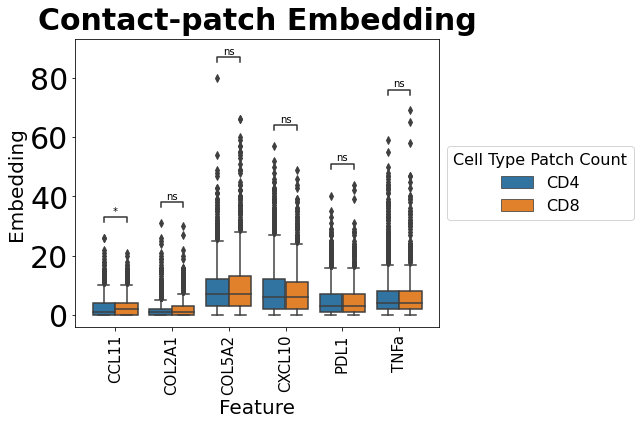

In [735]:
df = count_stat_df['set3']
channel_pairs = df["Gene"].unique()
hue = "Cell Type"
x = "Gene"
gp = df["Gene"].unique()
y = "Count"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type Patch Count', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(r'.\figures\set4 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CD34_CD4 v.s. CD34_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.153e+05
ACTb_CD4 v.s. ACTb_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.165e+05
CXCR4_CD4 v.s. CXCR4_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.156e+05
IFNg_CD4 v.s. IFNg_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.162e+05
MKI67_CD4 v.s. MKI67_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.165e+05
COL2A1_CD4 v.s. COL2A1_CD8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.687e-01 U_stat=1.136e+05


C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\3830476471.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


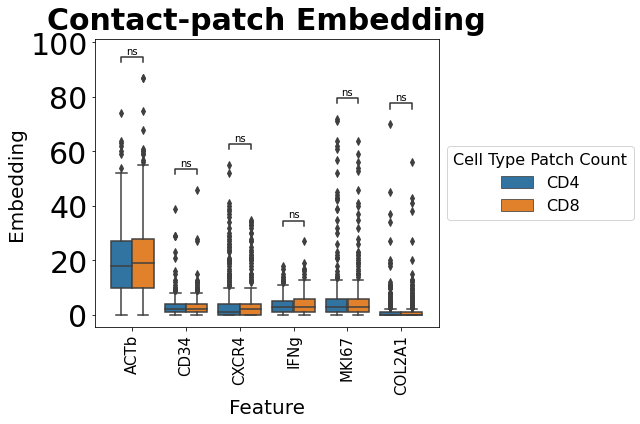

In [736]:
df = count_stat_df['set4']
channel_pairs = df["Gene"].unique()
hue = "Cell Type"
x = "Gene"
gp = df["Gene"].unique()
y = "Count"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type Patch Count', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(r'.\figures\set4 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show()

## ki67+ v. ki67- comparison

In [737]:
for k in cd4_central_count.keys():
    ki67_label = []
    for p in cd4_central_count[k]['Count_id'].tolist():
        ki67_label.append(cd4_central_proxi[k][cd4_central_proxi[k]['patch_id']==p]['KI67_label'].values[0])
    cd4_central_count[k]['KI67_label'] = ki67_label

for k in cd8_central_count.keys():
    ki67_label = []
    for p in cd8_central_count[k]['Count_id'].tolist():
        ki67_label.append(cd8_central_proxi[k][cd8_central_proxi[k]['patch_id']==p]['KI67_label'].values[0])
    cd8_central_count[k]['KI67_label'] = ki67_label

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\1491997366.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd4_central_count[k]['KI67_label'] = ki67_label
C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\1491997366.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd4_central_count[k]['KI67_label'] = ki67_label
C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\1491997366.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [738]:
count_stat_df = {}
for k in cd8_central_count.keys():
    cd4_count_temp = cd4_central_count[k]
    ki67_label = cd4_count_temp['KI67_label'].tolist()
    temp = cd4_count_temp.drop(columns=['Count_id', 'KI67_label'])
    cd4_melt = temp.melt(var_name='Gene', value_name='Count')
    cd4_melt['Count'] = cd4_melt['Count'].astype('float')
    cd4_melt['KI67_label'] = ki67_label * temp.shape[1]

    cd8_count_temp = cd8_central_count[k]
    ki67_label = cd8_count_temp['KI67_label'].tolist()
    temp = cd8_count_temp.drop(columns=['Count_id', 'KI67_label'])
    cd8_melt = temp.melt(var_name='Gene', value_name='Count')
    cd8_melt['Count'] = cd8_melt['Count'].astype('float')
    cd8_melt['KI67_label'] = ki67_label * temp.shape[1]

    count_stat_df[k] = pd.concat([cd4_melt,cd8_melt])
    count_stat_df[k]['Cell Type'] = ['CD4'] * cd4_melt.shape[0] + ['CD8'] * cd8_melt.shape[0]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CD45_KI67- v.s. CD45_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.047e-01 U_stat=4.231e+04
ACTb_KI67- v.s. ACTb_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.727e-01 U_stat=4.218e+04
COL1A1_KI67- v.s. COL1A1_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.650e+04
IFNa_KI67- v.s. IFNa_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.453e+04
IL6_KI67- v.s. IL6_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.532e+04
IL8_KI67- v.s. IL8_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.171e-01 U_stat=4.203e+04


C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\2726698505.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


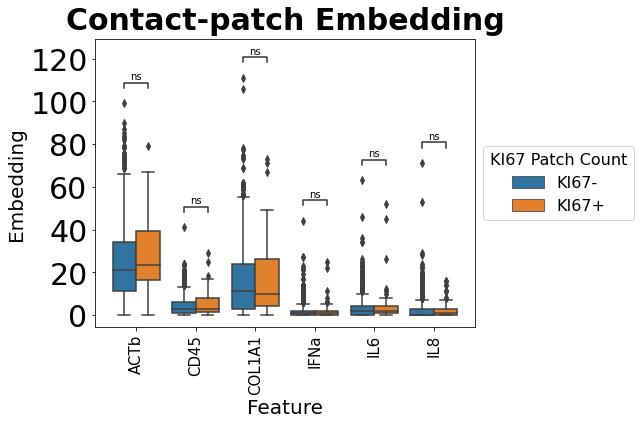

In [739]:
df = count_stat_df['set1']
df = df[df['Cell Type'] == 'CD4']
channel_pairs = df["Gene"].unique()
hue = "KI67_label"
x = "Gene"
gp = df["Gene"].unique()
y = "Count"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67 Patch Count', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(r'.\figures\set4 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show() 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

GAPDH_KI67- v.s. GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.787e+04
COL1A1_KI67- v.s. COL1A1_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.868e+04
HLA-DRA_KI67- v.s. HLA-DRA_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.852e+04
IL10_KI67- v.s. IL10_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.098e+04
PD1_KI67- v.s. PD1_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.949e+04
PDL1_KI67- v.s. PDL1_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.954e+04


C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\2800855865.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


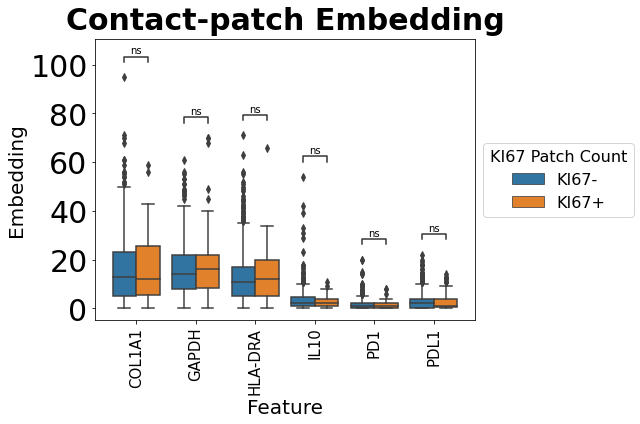

In [740]:
df = count_stat_df['set2']
df = df[df['Cell Type'] == 'CD4']
channel_pairs = df["Gene"].unique()
hue = "KI67_label"
x = "Gene"
gp = df["Gene"].unique()
y = "Count"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67 Patch Count', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(r'.\figures\set4 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show() 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

COL2A1_KI67- v.s. COL2A1_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.452e+04
CCL11_KI67- v.s. CCL11_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.158e-01 U_stat=5.917e+04
COL5A2_KI67- v.s. COL5A2_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.211e+04
CXCL10_KI67- v.s. CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.146e+04
PDL1_KI67- v.s. PDL1_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.796e-01 U_stat=5.828e+04
TNFa_KI67- v.s. TNFa_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.618e+04


C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\4174169495.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


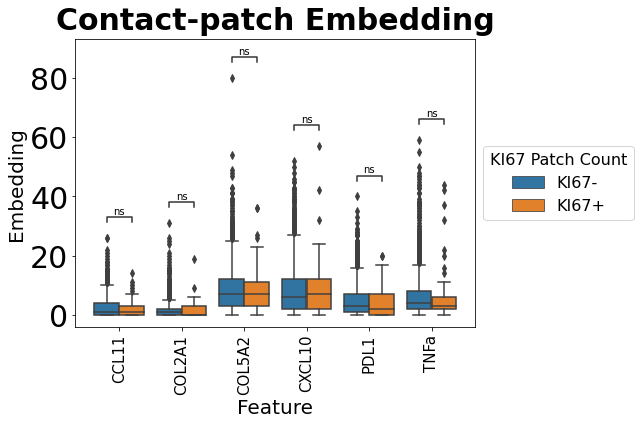

In [741]:
df = count_stat_df['set3']
df = df[df['Cell Type'] == 'CD4']
channel_pairs = df["Gene"].unique()
hue = "KI67_label"
x = "Gene"
gp = df["Gene"].unique()
y = "Count"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67 Patch Count', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(r'.\figures\set4 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show() 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CD34_KI67- v.s. CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.112e+03
ACTb_KI67- v.s. ACTb_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.737e-01 U_stat=1.598e+03
CXCR4_KI67- v.s. CXCR4_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.249e+03
IFNg_KI67- v.s. IFNg_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.731e-01 U_stat=3.452e+03
MKI67_KI67- v.s. MKI67_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.407e+03
COL2A1_KI67- v.s. COL2A1_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.536e+03


C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\1575863624.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


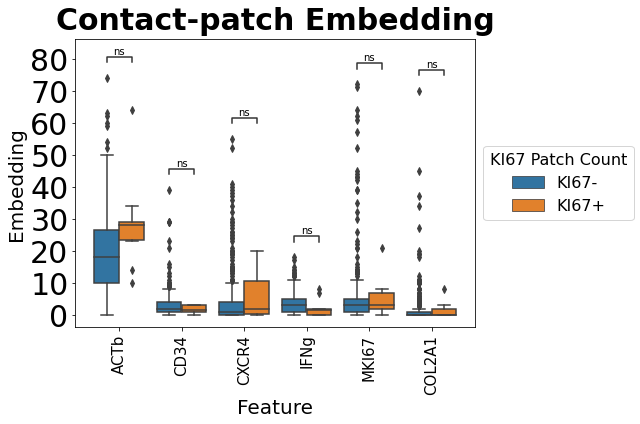

In [742]:
df = count_stat_df['set4']
df = df[df['Cell Type'] == 'CD4']
channel_pairs = df["Gene"].unique()
hue = "KI67_label"
x = "Gene"
gp = df["Gene"].unique()
y = "Count"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67 Patch Count', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(r'.\figures\set4 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show() 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CD45_KI67+ v.s. CD45_KI67-: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.258e-01 U_stat=7.062e+04
ACTb_KI67+ v.s. ACTb_KI67-: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.453e+04
COL1A1_KI67+ v.s. COL1A1_KI67-: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.224e+04
IFNa_KI67+ v.s. IFNa_KI67-: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.827e+04
IL6_KI67+ v.s. IL6_KI67-: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.790e-01 U_stat=7.219e+04
IL8_KI67+ v.s. IL8_KI67-: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.985e-01 U_stat=7.080e+04


C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\1386340247.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


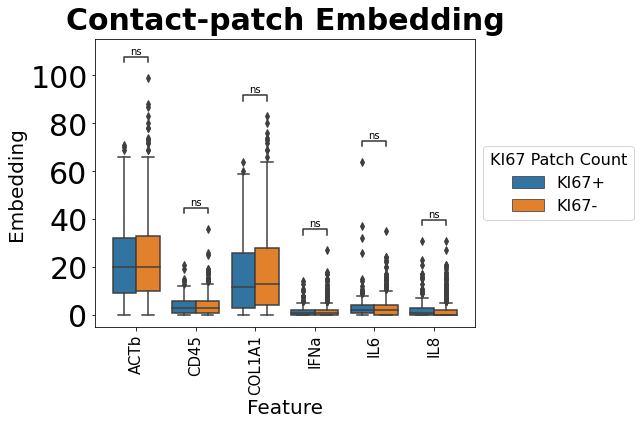

In [743]:
df = count_stat_df['set1']
df = df[df['Cell Type'] == 'CD8']
channel_pairs = df["Gene"].unique()
hue = "KI67_label"
x = "Gene"
gp = df["Gene"].unique()
y = "Count"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67 Patch Count', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(r'.\figures\set4 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show() 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

GAPDH_KI67- v.s. GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.101e+04
COL1A1_KI67- v.s. COL1A1_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.092e+04
HLA-DRA_KI67- v.s. HLA-DRA_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.944e+04
IL10_KI67- v.s. IL10_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.111e-01 U_stat=2.309e+04
PD1_KI67- v.s. PD1_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.667e-01 U_stat=2.293e+04
PDL1_KI67- v.s. PDL1_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.084e+04


C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\4105092212.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


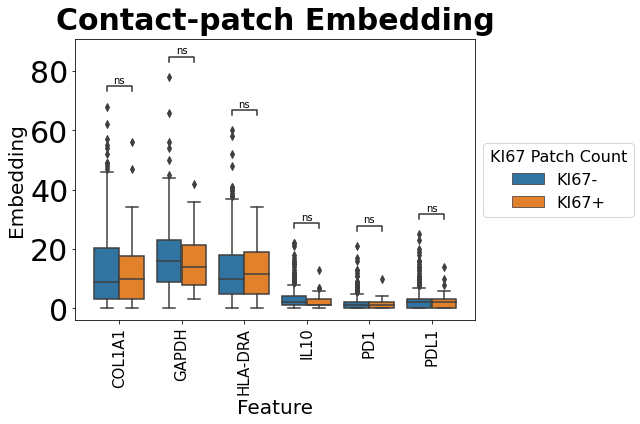

In [744]:
df = count_stat_df['set2']
df = df[df['Cell Type'] == 'CD8']
channel_pairs = df["Gene"].unique()
hue = "KI67_label"
x = "Gene"
gp = df["Gene"].unique()
y = "Count"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67 Patch Count', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(r'.\figures\set4 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show() 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CXCL10_KI67- v.s. CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.160e+04
CCL11_KI67- v.s. CCL11_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.710e+04
PDL1_KI67- v.s. PDL1_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.893e+04
TNFa_KI67- v.s. TNFa_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.963e+04
COL2A1_KI67- v.s. COL2A1_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.372e-01 U_stat=2.487e+04
COL5A2_KI67- v.s. COL5A2_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.117e+04


C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\3340980081.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


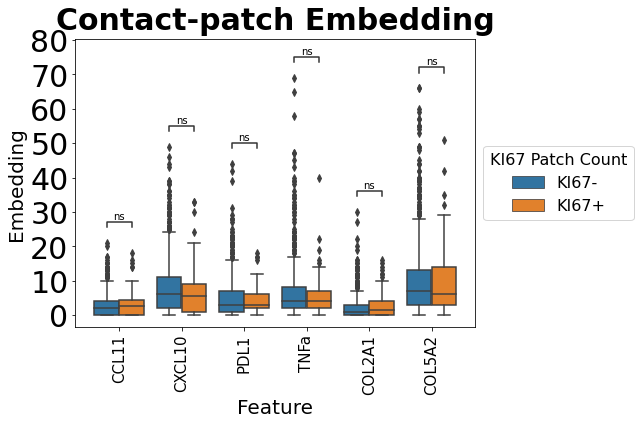

In [745]:
df = count_stat_df['set3']
df = df[df['Cell Type'] == 'CD8']
channel_pairs = df["Gene"].unique()
hue = "KI67_label"
x = "Gene"
gp = df["Gene"].unique()
y = "Count"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67 Patch Count', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(r'.\figures\set4 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show() 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CD34_KI67- v.s. CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.377e-02 U_stat=3.172e+03
ACTb_KI67- v.s. ACTb_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.534e+03
CXCR4_KI67- v.s. CXCR4_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.402e+03
IFNg_KI67- v.s. IFNg_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.122e-03 U_stat=3.600e+03
MKI67_KI67- v.s. MKI67_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.217e-01 U_stat=1.326e+03
COL2A1_KI67- v.s. COL2A1_KI67+: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.241e+03


C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\3191598567.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)


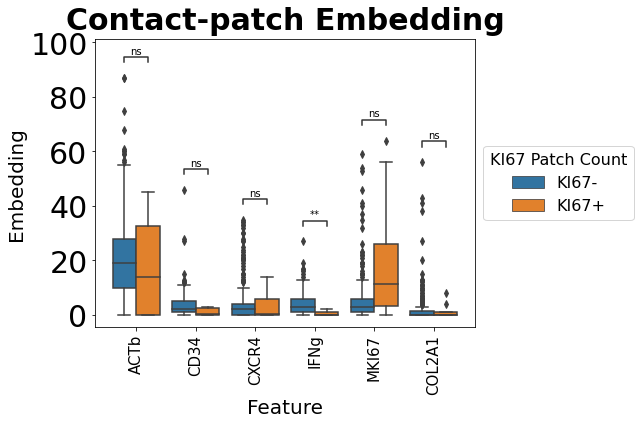

In [746]:
df = count_stat_df['set4']
df = df[df['Cell Type'] == 'CD8']
channel_pairs = df["Gene"].unique()
hue = "KI67_label"
x = "Gene"
gp = df["Gene"].unique()
y = "Count"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 6))
plt.title('Contact-patch Embedding',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction="bonferroni",
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_xlabel("Feature",fontsize=20)
g.set_ylabel("Embedding",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67 Patch Count', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(r'.\figures\set4 cd4-cd8 embedding.png', bbox_inches="tight")
plt.show() 

# patch raw interactions

In [747]:
cd4_proxi_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proxi_dfs\cd4'
fn_l = os.listdir(cd4_proxi_dir)
fn_l.sort()

cd4_proxi = {}
for fn in fn_l:
    proxi = pd.read_csv(os.path.join(cd4_proxi_dir,fn), index_col=0)
    cd4_proxi[fn.split('.')[0]] = proxi

cd8_proxi_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proxi_dfs\cd8'
fn_l = os.listdir(cd8_proxi_dir)
fn_l.sort()

cd8_proxi = {}
for fn in fn_l:
    proxi = pd.read_csv(os.path.join(cd8_proxi_dir,fn), index_col=0)
    cd8_proxi[fn.split('.')[0]] = proxi

In [748]:
cd4_net_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proximity\networks\cd4'
fn_l = os.listdir(cd4_net_dir)
fn_l.sort()

cd4_net = {}
for k in cd4_proxi.keys():
    cd4_net[k] = {}
    for p in cd4_proxi[k].columns.tolist():
        cd4_net[k][p] = []
    cd4_net[k]['patch_id'] = []
    cd4_net[k]['cellID'] = []

for fn in tqdm(fn_l):
    if fn.endswith('.pkl'):
        cell = fn.split('.')[0]
        nets = pd.read_pickle(os.path.join(cd4_net_dir, fn))
        fov = fn.split('_')[0]
        if int(fov) < 30:
            s = 'set1'
        elif int(fov) < 60:
            s = 'set2'
        elif int(fov) < 90:
            s = 'set3'
        else:
            s = 'set4'
        
        for i in range(len(nets)):
            patch = cell + '_' + str(i)
            z, m, std = nets[i]
            df = (z.values * std) + m
            df = pd.DataFrame(df, index = z.index.tolist(), columns = z.columns.tolist())
            for p in cd4_proxi[s].columns.tolist():
                gene1, gene2 = p.split('_')
                if gene1 in df.index.tolist() and gene2 in df.columns.tolist():
                    cd4_net[s][p].append(df.loc[gene1,gene2])
                else:
                    cd4_net[s][p].append(np.nan)
            cd4_net[s]['patch_id'].append(patch)
            cd4_net[s]['cellID'].append(cell)

for k in cd4_net.keys():
    cd4_net[k] = pd.DataFrame(cd4_net[k])

100%|██████████| 844/844 [00:47<00:00, 17.95it/s]


In [749]:
cd8_net_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proximity\networks\cd8'
fn_l = os.listdir(cd8_net_dir)
fn_l.sort()

cd8_net = {}
for k in cd8_proxi.keys():
    cd8_net[k] = {}
    for p in cd8_proxi[k].columns.tolist():
        cd8_net[k][p] = []
    cd8_net[k]['patch_id'] = []
    cd8_net[k]['cellID'] = []

for fn in tqdm(fn_l):
    if fn.endswith('.pkl'):
        cell = fn.split('.')[0]
        nets = pd.read_pickle(os.path.join(cd8_net_dir, fn))
        fov = fn.split('_')[0]
        if int(fov) < 30:
            s = 'set1'
        elif int(fov) < 60:
            s = 'set2'
        elif int(fov) < 90:
            s = 'set3'
        else:
            s = 'set4'
        
        for i in range(len(nets)):
            patch = cell + '_' + str(i)
            z, m, std = nets[i]
            df = (z.values * std) + m
            df = pd.DataFrame(df, index = z.index.tolist(), columns = z.columns.tolist())
            for p in cd8_proxi[s].columns.tolist():
                gene1, gene2 = p.split('_')
                if gene1 in df.index.tolist() and gene2 in df.columns.tolist():
                    cd8_net[s][p].append(df.loc[gene1,gene2])
                else:
                    cd8_net[s][p].append(np.nan)
            cd8_net[s]['patch_id'].append(patch)
            cd8_net[s]['cellID'].append(cell)
    
for k in cd8_net.keys():
    cd8_net[k] = pd.DataFrame(cd8_net[k])

100%|██████████| 636/636 [00:33<00:00, 19.27it/s]


In [750]:
cd4_central_interactions = {}
cd4_central_patches = {}
for k in cd4_central_proxi.keys():
    cd4_central_patches[k] = cd4_central_proxi[k]['patch_id'].tolist()
for k in cd4_proxi.keys():
    cd4_central_interactions[k] = cd4_net[k][cd4_net[k]['patch_id'].isin(cd4_central_patches[k]) == True]

cd8_central_interactions = {}
cd8_central_patches = {}
for k in cd8_central_proxi.keys():
    cd8_central_patches[k] = cd8_central_proxi[k]['patch_id'].tolist()
for k in cd8_proxi.keys():
    cd8_central_interactions[k] = cd8_net[k][cd8_net[k]['patch_id'].isin(cd8_central_patches[k]) == True]

In [751]:
for k in cd4_central_interactions.keys():
    ki67_label = []
    for p in cd4_central_interactions[k]['patch_id'].tolist():
        ki67_label.append(cd4_central_proxi[k][cd4_central_proxi[k]['patch_id']==p]['KI67_label'].values[0])
    cd4_central_interactions[k]['KI67_label'] = ki67_label

for k in cd8_central_interactions.keys():
    ki67_label = []
    for p in cd8_central_interactions[k]['patch_id'].tolist():
        ki67_label.append(cd8_central_proxi[k][cd8_central_proxi[k]['patch_id']==p]['KI67_label'].values[0])
    cd8_central_interactions[k]['KI67_label'] = ki67_label

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\1375545770.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd4_central_interactions[k]['KI67_label'] = ki67_label
C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\1375545770.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd4_central_interactions[k]['KI67_label'] = ki67_label
C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\1375545770.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [752]:
interactions_comp = {}
for k in cd8_central_interactions.keys():
    cd4_interaction_temp = cd4_central_interactions[k]
    temp = cd4_interaction_temp.drop(columns=['patch_id','KI67_label'])
    cd4_melt = temp.melt(var_name='Gene Pair',value_name='Interactions')
    cd4_melt['Interactions'] = cd4_melt['Interactions'].astype('float')
    cd4_melt['KI67_label'] = cd4_interaction_temp['KI67_label'].tolist() * temp.shape[1]

    cd8_interaction_temp = cd8_central_interactions[k]
    temp = cd8_interaction_temp.drop(columns=['patch_id','KI67_label'])
    cd8_melt = temp.melt(var_name='Gene Pair',value_name='Interactions')
    cd8_melt['Interactions'] = cd8_melt['Interactions'].astype('float')
    cd8_melt['KI67_label'] = cd8_interaction_temp['KI67_label'].tolist() * temp.shape[1]

    interactions_comp[k] = pd.concat([cd4_melt, cd8_melt])
    interactions_comp[k]['Cell Type'] = ['CD4'] * cd4_melt.shape[0] + ['CD8']*cd8_melt.shape[0]

    interactions_comp[k] = interactions_comp[k].dropna()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ACTb_CD45_CD4 v.s. ACTb_CD45_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=2.551e-03 U_stat=3.712e+05
ACTb_IFNa_CD4 v.s. ACTb_IFNa_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=1.135e-01 U_stat=1.453e+05
ACTb_COL1A1_CD4 v.s. ACTb_COL1A1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=2.333e-01 U_stat=4.358e+05
CD45_IFNa_CD4 v.s. CD45_IFNa_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=3.582e-01 U_stat=1.193e+05
CD45_COL1A1_CD4 v.s. CD45_COL1A1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=1.791e-01 U_stat=3.039e+05
IFNa_COL1A1_CD4 v.s. IFNa_COL1A1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=4.961e-01 U_stat=1.253e+05
cellID_CD4 v.s. cellID_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=5.608e-01 U_stat=5.490e+05
IL8_COL1A1_CD4 v.s. IL8_COL1A1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=1.196e-01 U_sta

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\622728922.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)


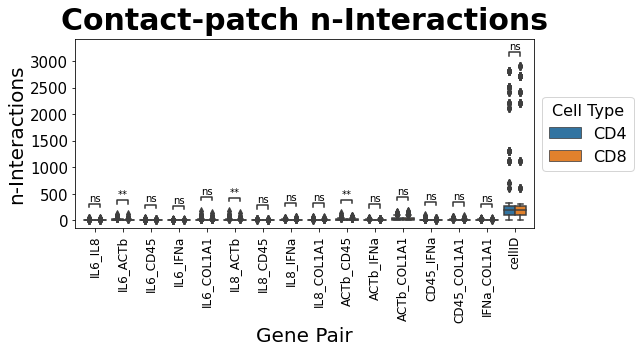

In [753]:
df = interactions_comp['set1']
channel_pairs = df["Gene Pair"].unique()
hue = "Cell Type"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Interactions"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 5))
plt.title('Contact-patch n-Interactions',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)
g.set_xlabel("Gene Pair",fontsize=20)
g.set_ylabel("n-Interactions",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(r'.\figures\set1 cd4-cd8 n-interactions.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

IL10_PD1_CD4 v.s. IL10_PD1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=4.278e-01 U_stat=8.356e+04
IL10_PDL1_CD4 v.s. IL10_PDL1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=6.719e-01 U_stat=1.219e+05
IL10_GAPDH_CD4 v.s. IL10_GAPDH_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=8.268e-01 U_stat=1.996e+05
PD1_PDL1_CD4 v.s. PD1_PDL1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=2.746e-01 U_stat=7.672e+04
PD1_GAPDH_CD4 v.s. PD1_GAPDH_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=4.373e-01 U_stat=1.132e+05
PDL1_GAPDH_CD4 v.s. PDL1_GAPDH_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=3.825e-01 U_stat=1.734e+05
cellID_CD4 v.s. cellID_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=4.373e-08 U_stat=3.683e+05
HLA-DRA_GAPDH_CD4 v.s. HLA-DRA_GAPDH_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=3.135e-01 U_stat=2.80

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\457457247.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)


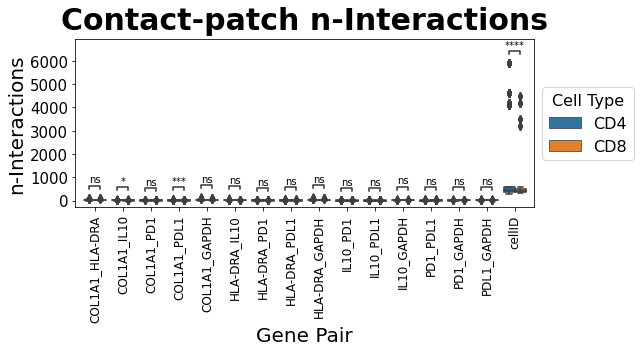

In [754]:
df = interactions_comp['set2']
channel_pairs = df["Gene Pair"].unique()
hue = "Cell Type"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Interactions"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 5))
plt.title('Contact-patch n-Interactions',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)
g.set_xlabel("Gene Pair",fontsize=20)
g.set_ylabel("n-Interactions",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set2 cd4-cd8 n-interactions.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

COL5A2_CCL11_CD4 v.s. COL5A2_CCL11_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=1.822e-01 U_stat=3.346e+05
COL5A2_COL2A1_CD4 v.s. COL5A2_COL2A1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=7.904e-01 U_stat=2.481e+05
COL5A2_CXCL10_CD4 v.s. COL5A2_CXCL10_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=8.117e-01 U_stat=5.531e+05
CCL11_COL2A1_CD4 v.s. CCL11_COL2A1_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=6.422e-01 U_stat=1.984e+05
CCL11_CXCL10_CD4 v.s. CCL11_CXCL10_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=3.973e-03 U_stat=3.289e+05
COL2A1_CXCL10_CD4 v.s. COL2A1_CXCL10_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=5.856e-01 U_stat=2.473e+05
cellID_CD4 v.s. cellID_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=1.014e-19 U_stat=1.060e+06
PDL1_CXCL10_CD4 v.s. PDL1_CXCL10_CD8: Mann-Whitney-Wilcoxon test 

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\2378117588.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)


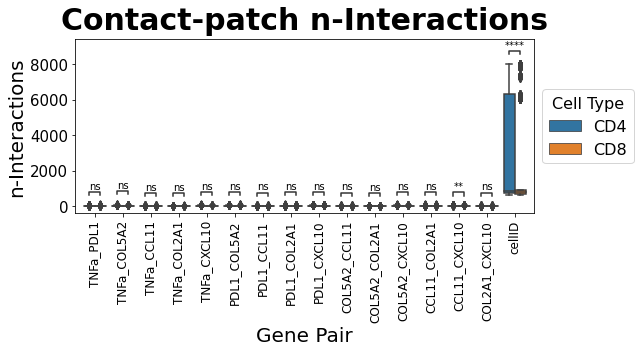

In [755]:
df = interactions_comp['set3']
channel_pairs = df["Gene Pair"].unique()
hue = "Cell Type"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Interactions"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 5))
plt.title('Contact-patch n-Interactions',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)
g.set_xlabel("Gene Pair",fontsize=20)
g.set_ylabel("n-Interactions",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set3 cd4-cd8 n-interactions.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CXCR4_ACTb_CD4 v.s. CXCR4_ACTb_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=7.989e-01 U_stat=4.961e+04
CXCR4_IFNg_CD4 v.s. CXCR4_IFNg_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=1.074e-01 U_stat=3.599e+04
CXCR4_CD34_CD4 v.s. CXCR4_CD34_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=8.227e-01 U_stat=3.894e+04
ACTb_IFNg_CD4 v.s. ACTb_IFNg_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=2.774e-01 U_stat=7.270e+04
ACTb_CD34_CD4 v.s. ACTb_CD34_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=4.378e-01 U_stat=7.408e+04
IFNg_CD34_CD4 v.s. IFNg_CD34_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=6.430e-03 U_stat=5.379e+04
cellID_CD4 v.s. cellID_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=1.000e+00 U_stat=1.213e+05
COL2A1_CD34_CD4 v.s. COL2A1_CD34_CD8: Mann-Whitney-Wilcoxon test two-sided, P_val=9.371e-01 U_stat=1.

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\1679676037.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)


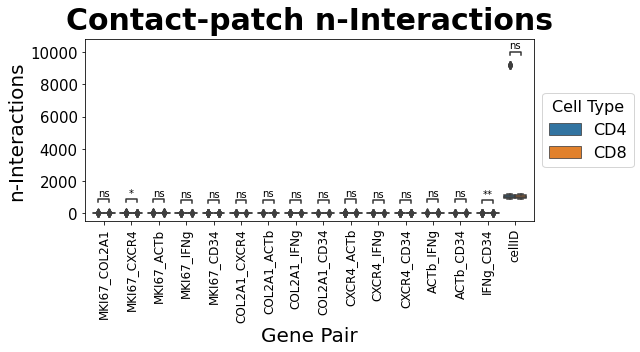

In [756]:
df = interactions_comp['set4']
channel_pairs = df["Gene Pair"].unique()
hue = "Cell Type"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Interactions"
hue_order=['CD4','CD8']
plt.figure(figsize=(9, 5))
plt.title('Contact-patch n-Interactions',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "CD4"),(p, "CD8")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)
g.set_xlabel("Gene Pair",fontsize=20)
g.set_ylabel("n-Interactions",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set4 cd4-cd8 n-interactions.png', bbox_inches="tight")
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ACTb_CD45_KI67- v.s. ACTb_CD45_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.158e-01 U_stat=2.690e+04
ACTb_IFNa_KI67- v.s. ACTb_IFNa_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.585e-01 U_stat=1.128e+04
ACTb_COL1A1_KI67- v.s. ACTb_COL1A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.851e-01 U_stat=3.997e+04
CD45_IFNa_KI67- v.s. CD45_IFNa_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.583e-01 U_stat=1.048e+04
CD45_COL1A1_KI67- v.s. CD45_COL1A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.319e-02 U_stat=2.231e+04
IFNa_COL1A1_KI67- v.s. IFNa_COL1A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.947e-01 U_stat=1.141e+04
cellID_KI67- v.s. cellID_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.656e-02 U_stat=5.300e+04
IL8_COL1A1_KI67- v.s. IL8_COL1A1_KI67+: Mann-Whitney-Wilcoxon test 

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\2728214402.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)


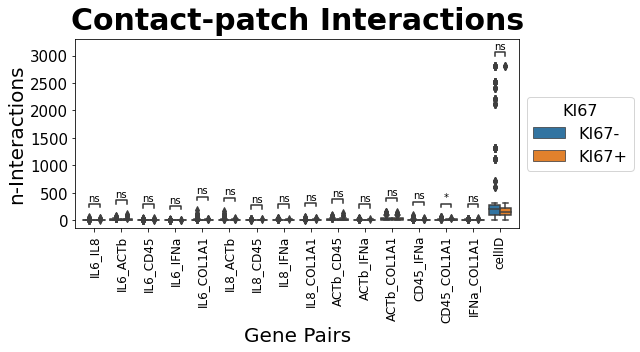

In [757]:
df = interactions_comp['set1']
df = df[df['Cell Type'] == 'CD4']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Interactions"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 5))
plt.title('Contact-patch Interactions',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("n-Interactions",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set1 cd4 ki67 n-interactions.png', bbox_inches="tight")
plt.show() 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

IL10_PD1_KI67- v.s. IL10_PD1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.760e-02 U_stat=6.048e+03
IL10_PDL1_KI67- v.s. IL10_PDL1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.819e-01 U_stat=1.391e+04
IL10_GAPDH_KI67- v.s. IL10_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.896e-01 U_stat=2.012e+04
PD1_PDL1_KI67- v.s. PD1_PDL1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.527e-01 U_stat=7.074e+03
PD1_GAPDH_KI67- v.s. PD1_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.820e-02 U_stat=1.111e+04
PDL1_GAPDH_KI67- v.s. PDL1_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.316e-01 U_stat=1.541e+04
cellID_KI67- v.s. cellID_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.968e-04 U_stat=2.230e+04
HLA-DRA_GAPDH_KI67- v.s. HLA-DRA_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-si

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\469594223.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)


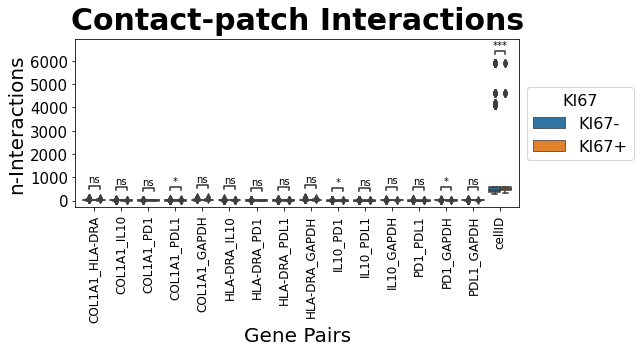

In [758]:
df = interactions_comp['set2']
df = df[df['Cell Type'] == 'CD4']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Interactions"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 5))
plt.title('Contact-patch Interactions',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("n-Interactions",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set2 cd4 ki67 n-interactions.png', bbox_inches="tight")
plt.show() 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

COL5A2_CCL11_KI67- v.s. COL5A2_CCL11_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.448e-01 U_stat=1.896e+04
COL5A2_COL2A1_KI67- v.s. COL5A2_COL2A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.030e-01 U_stat=1.215e+04
COL5A2_CXCL10_KI67- v.s. COL5A2_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.420e-02 U_stat=2.738e+04
CCL11_COL2A1_KI67- v.s. CCL11_COL2A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.599e-01 U_stat=9.234e+03
CCL11_CXCL10_KI67- v.s. CCL11_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.475e-01 U_stat=1.704e+04
COL2A1_CXCL10_KI67- v.s. COL2A1_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.379e-01 U_stat=1.214e+04
cellID_KI67- v.s. cellID_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.118e-04 U_stat=6.570e+04
PDL1_CXCL10_KI67- v.s. PDL1_CXCL10_KI

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\506745202.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)


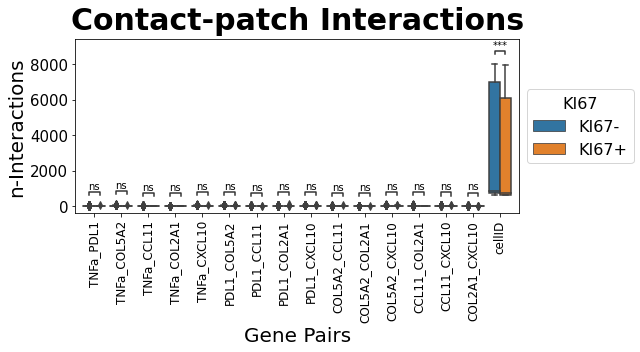

In [759]:
df = interactions_comp['set3']
df = df[df['Cell Type'] == 'CD4']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Interactions"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 5))
plt.title('Contact-patch Interactions',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("n-Interactions",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set3 cd4 ki67 n-interactions.png', bbox_inches="tight")
plt.show() 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CXCR4_ACTb_KI67- v.s. CXCR4_ACTb_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.849e-03 U_stat=4.890e+02
CXCR4_IFNg_KI67- v.s. CXCR4_IFNg_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.569e-01 U_stat=6.665e+02
CXCR4_CD34_KI67- v.s. CXCR4_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=5.365e-01 U_stat=1.013e+03
ACTb_IFNg_KI67- v.s. ACTb_IFNg_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.687e-01 U_stat=1.300e+03
ACTb_CD34_KI67- v.s. ACTb_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.142e-01 U_stat=2.196e+03
IFNg_CD34_KI67- v.s. IFNg_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.349e-01 U_stat=1.538e+03
cellID_KI67- v.s. cellID_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.276e-04 U_stat=4.325e+03
COL2A1_CD34_KI67- v.s. COL2A1_CD34_KI67+: Mann-Whitney-Wilcoxon test two-

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\3623531927.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)


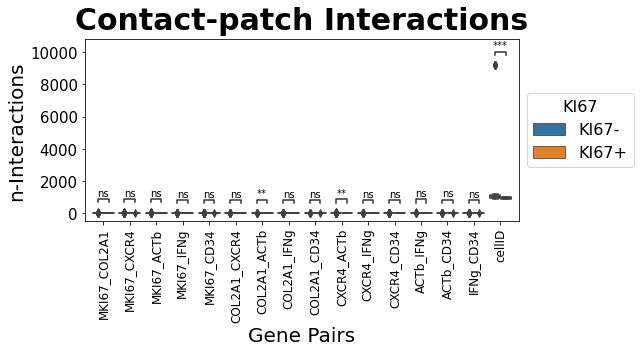

In [760]:
df = interactions_comp['set4']
df = df[df['Cell Type'] == 'CD4']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Interactions"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 5))
plt.title('Contact-patch Interactions',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("n-Interactions",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set4 cd4 ki67 n-interactions.png', bbox_inches="tight")
plt.show() 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ACTb_CD45_KI67+ v.s. ACTb_CD45_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=7.815e-01 U_stat=4.510e+04
ACTb_IFNa_KI67+ v.s. ACTb_IFNa_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=9.003e-01 U_stat=1.770e+04
ACTb_COL1A1_KI67+ v.s. ACTb_COL1A1_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=5.623e-02 U_stat=4.959e+04
CD45_IFNa_KI67+ v.s. CD45_IFNa_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=8.892e-01 U_stat=1.527e+04
CD45_COL1A1_KI67+ v.s. CD45_COL1A1_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=8.457e-01 U_stat=4.137e+04
IFNa_COL1A1_KI67+ v.s. IFNa_COL1A1_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=9.150e-01 U_stat=1.621e+04
cellID_KI67+ v.s. cellID_KI67-: Mann-Whitney-Wilcoxon test two-sided, P_val=4.499e-05 U_stat=5.272e+04
IL8_COL1A1_KI67+ v.s. IL8_COL1A1_KI67-: Mann-Whitney-Wilcoxon test 

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\4122557291.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)


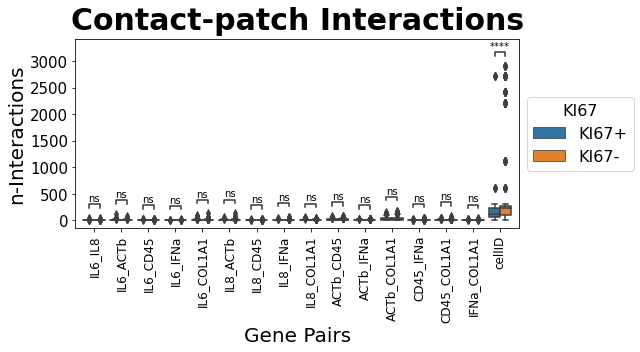

In [761]:
df = interactions_comp['set1']
df = df[df['Cell Type'] == 'CD8']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Interactions"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 5))
plt.title('Contact-patch Interactions',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("n-Interactions",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set1 cd8 ki67 n-interactions.png', bbox_inches="tight")
plt.show() 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

IL10_PD1_KI67- v.s. IL10_PD1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.735e-01 U_stat=5.699e+03
IL10_PDL1_KI67- v.s. IL10_PDL1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.650e-01 U_stat=7.944e+03
IL10_GAPDH_KI67- v.s. IL10_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.705e-01 U_stat=1.366e+04
PD1_PDL1_KI67- v.s. PD1_PDL1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.552e-01 U_stat=4.796e+03
PD1_GAPDH_KI67- v.s. PD1_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.468e-01 U_stat=6.475e+03
PDL1_GAPDH_KI67- v.s. PDL1_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.438e-01 U_stat=1.024e+04
cellID_KI67- v.s. cellID_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.760e-07 U_stat=1.215e+04
HLA-DRA_GAPDH_KI67- v.s. HLA-DRA_GAPDH_KI67+: Mann-Whitney-Wilcoxon test two-si

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\1209153978.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)


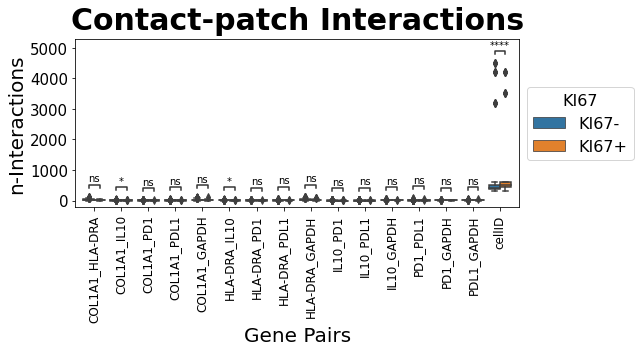

In [762]:
df = interactions_comp['set2']
df = df[df['Cell Type'] == 'CD8']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Interactions"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 5))
plt.title('Contact-patch Interactions',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("n-Interactions",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set2 cd8 ki67 n-interactions.png', bbox_inches="tight")
plt.show() 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

COL5A2_CCL11_KI67- v.s. COL5A2_CCL11_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.127e-01 U_stat=1.207e+04
COL5A2_COL2A1_KI67- v.s. COL5A2_COL2A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=2.035e-01 U_stat=9.209e+03
COL5A2_CXCL10_KI67- v.s. COL5A2_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=9.839e-01 U_stat=1.801e+04
CCL11_COL2A1_KI67- v.s. CCL11_COL2A1_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.501e-01 U_stat=7.850e+03
CCL11_CXCL10_KI67- v.s. CCL11_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=8.078e-01 U_stat=1.387e+04
COL2A1_CXCL10_KI67- v.s. COL2A1_CXCL10_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=6.913e-01 U_stat=1.123e+04
cellID_KI67- v.s. cellID_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=7.194e-02 U_stat=3.398e+04
PDL1_CXCL10_KI67- v.s. PDL1_CXCL10_KI

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\3660317552.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)


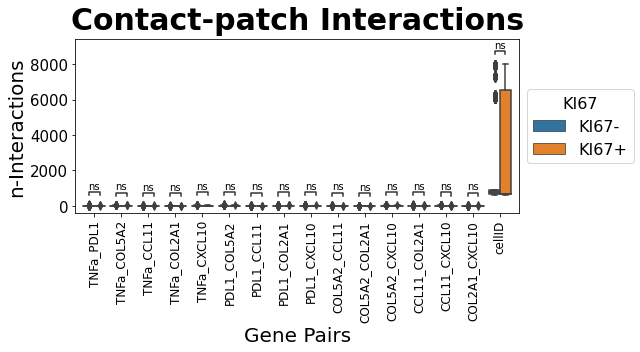

In [763]:
df = interactions_comp['set3']
df = df[df['Cell Type'] == 'CD8']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Interactions"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 5))
plt.title('Contact-patch Interactions',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("n-Interactions",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set3 cd8 ki67 n-interactions.png', bbox_inches="tight")
plt.show() 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CXCR4_ACTb_KI67- v.s. CXCR4_ACTb_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.491e-01 U_stat=5.400e+02
CXCR4_IFNg_KI67- v.s. CXCR4_IFNg_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.691e-01 U_stat=7.010e+02
CXCR4_CD34_KI67- v.s. CXCR4_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=3.391e-01 U_stat=3.670e+02
ACTb_IFNg_KI67- v.s. ACTb_IFNg_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.000e-02 U_stat=1.106e+03
ACTb_CD34_KI67- v.s. ACTb_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=4.029e-01 U_stat=1.069e+03
IFNg_CD34_KI67- v.s. IFNg_CD34_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.387e-01 U_stat=8.945e+02
cellID_KI67- v.s. cellID_KI67+: Mann-Whitney-Wilcoxon test two-sided, P_val=1.204e-01 U_stat=2.800e+03
COL2A1_CD34_KI67- v.s. COL2A1_CD34_KI67+: Mann-Whitney-Wilcoxon test two-

C:\Users\zfang38\AppData\Local\Temp\ipykernel_48768\4229068854.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)


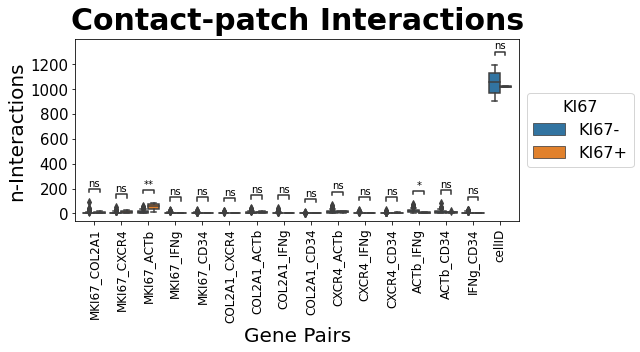

In [764]:
df = interactions_comp['set4']
df = df[df['Cell Type'] == 'CD8']
channel_pairs = df["Gene Pair"].unique()
hue = "KI67_label"
x = "Gene Pair"
gp = df["Gene Pair"].unique()
y = "Interactions"
hue_order=['KI67+','KI67-']
plt.figure(figsize=(9, 5))
plt.title('Contact-patch Interactions',fontsize= 30, pad=10, fontweight ="bold")

comparisons = [((p, "KI67+"),(p, "KI67-")) for p in channel_pairs]
box_pairs = comparisons
# box_pairs = []
# for chan in channel_pairs:
#     for c in comparisons:
#         box_pair = ((chan, c[0]), (chan, c[1]))
#         box_pairs.append(box_pair)

g = sns.boxplot(data=df, hue=hue, x=x, y=y)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

add_stat_annotation(g, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs, comparisons_correction=None,
                    test='Mann-Whitney', loc='inside', verbose=2)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15)
g.set_xlabel("Gene Pairs",fontsize=20)
g.set_ylabel("n-Interactions",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='KI67', fontsize=16, title_fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(r'.\figures\set4 cd8 ki67 n-interactions.png', bbox_inches="tight")
plt.show() 

In [765]:
import pickle

In [766]:
with open(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd4_central_proxi.pkl','wb') as f:
    pickle.dump(cd4_central_proxi, f)
with open(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd8_central_proxi.pkl','wb') as f:
    pickle.dump(cd8_central_proxi, f)
with open(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd4_central_embedding.pkl','wb') as f:
    pickle.dump(cd4_central_embedding, f)
with open(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd8_central_embedding.pkl','wb') as f:
    pickle.dump(cd8_central_embedding, f)
with open(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd4_central_count.pkl','wb') as f:
    pickle.dump(cd4_central_count, f)
with open(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd8_central_count.pkl','wb') as f:
    pickle.dump(cd8_central_count, f)
with open(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd4_central_interactions.pkl','wb') as f:
    pickle.dump(cd4_central_interactions, f)
with open(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd8_central_interactions.pkl','wb') as f:
    pickle.dump(cd8_central_interactions, f)

# Interaction count pca

In [446]:
adatas = {}
for k in cd4_central_interactions.keys():
    cd4_temp = cd4_central_interactions[k].drop(columns=['patch_id','KI67_label'])
    cd4_ki67_label = cd4_central_interactions[k]['KI67_label'].tolist()
    cd4_x = cd4_temp.fillna(0).values.astype('float')

    cd8_temp = cd8_central_interactions[k].drop(columns=['patch_id','KI67_label'])
    cd8_ki67_label = cd8_central_interactions[k]['KI67_label'].tolist()
    cd8_x = cd8_temp.fillna(0).values.astype('float')

    adata = sc.AnnData(np.concatenate([cd4_x, cd8_x]))
    adata.var_names = cd4_temp.columns.tolist()
    cell_ki67 = []
    for item in cd4_ki67_label:
        cell_ki67.append('CD4_' + item)
    for item in cd8_ki67_label:
        cell_ki67.append('CD8_' + item)
    adata.obs['Cell-KI67'] = pd.Categorical(cell_ki67,categories=['CD4_KI67+','CD4_KI67-','CD8_KI67+','CD8_KI67-'])
    adata.uns['Cell-KI67_colors'] = ['#00008F','#B60000','#00ff00','#ff00ff']
    adata.obs['Cell'] = pd.Categorical(['CD4']*len(cd4_ki67_label) + ['CD8']*len(cd8_ki67_label))
    adata.uns['Cell_colors'] = ['#00008F','#B60000']
    adata.obs['KI67'] = cd4_ki67_label + cd8_ki67_label
    adata.uns['KI67_colors'] = ['#00ff00','#ff00ff']
    sc.pp.pca(adata,n_comps=10)
    adatas[k] = adata

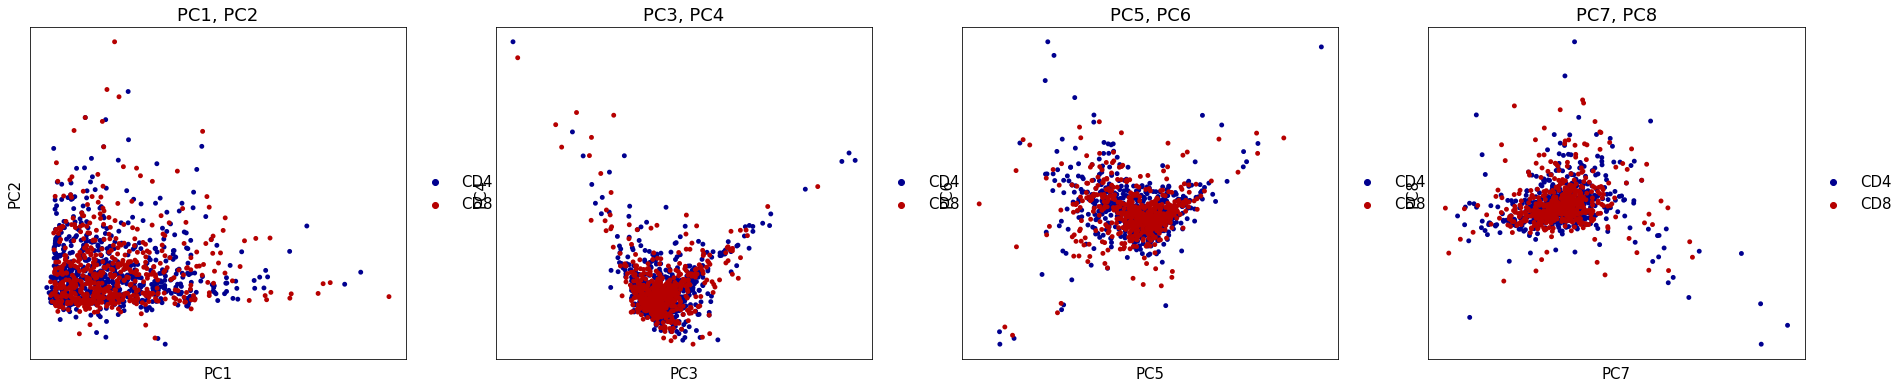

In [436]:
with rc_context({'figure.figsize':(7,6),'font.size':15}):
    sc.pl.pca(adatas['set1'], color=['Cell'], components=['1,2','3,4','5,6','7,8'],ncols=4,
              title=['PC1, PC2','PC3, PC4','PC5, PC6','PC7, PC8'], save=' set1 cell.png')

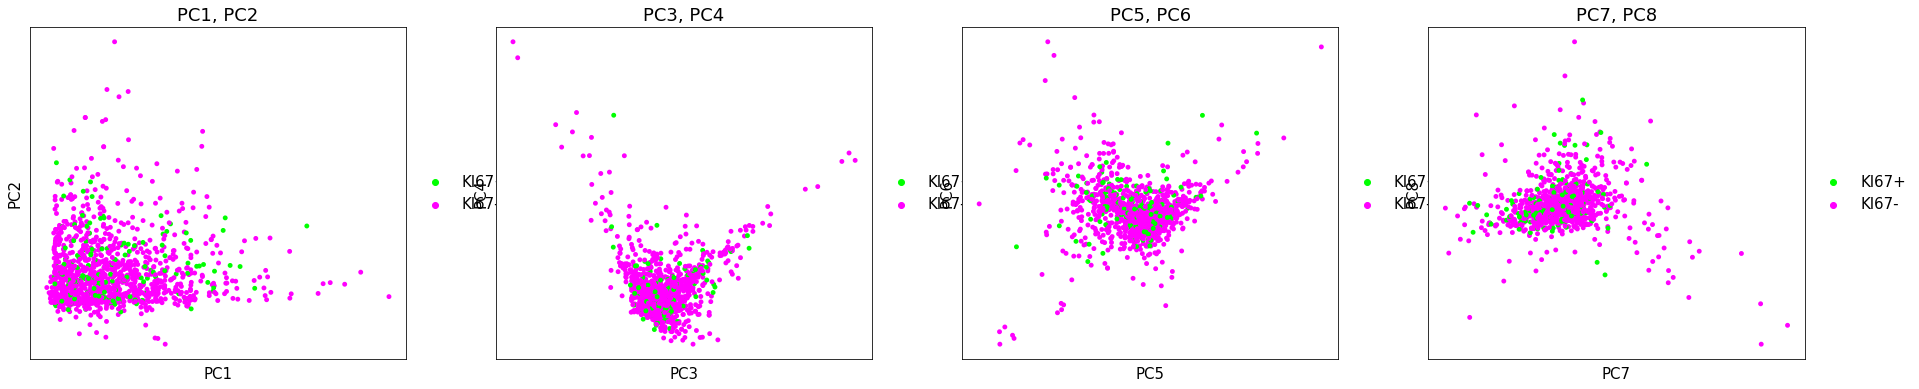

In [435]:
with rc_context({'figure.figsize':(7,6),'font.size':15}):
    sc.pl.pca(adatas['set1'], color=['KI67'], components=['1,2','3,4','5,6','7,8'],ncols=4,
              title=['PC1, PC2','PC3, PC4','PC5, PC6','PC7, PC8'], save=' set1 ki67.png')

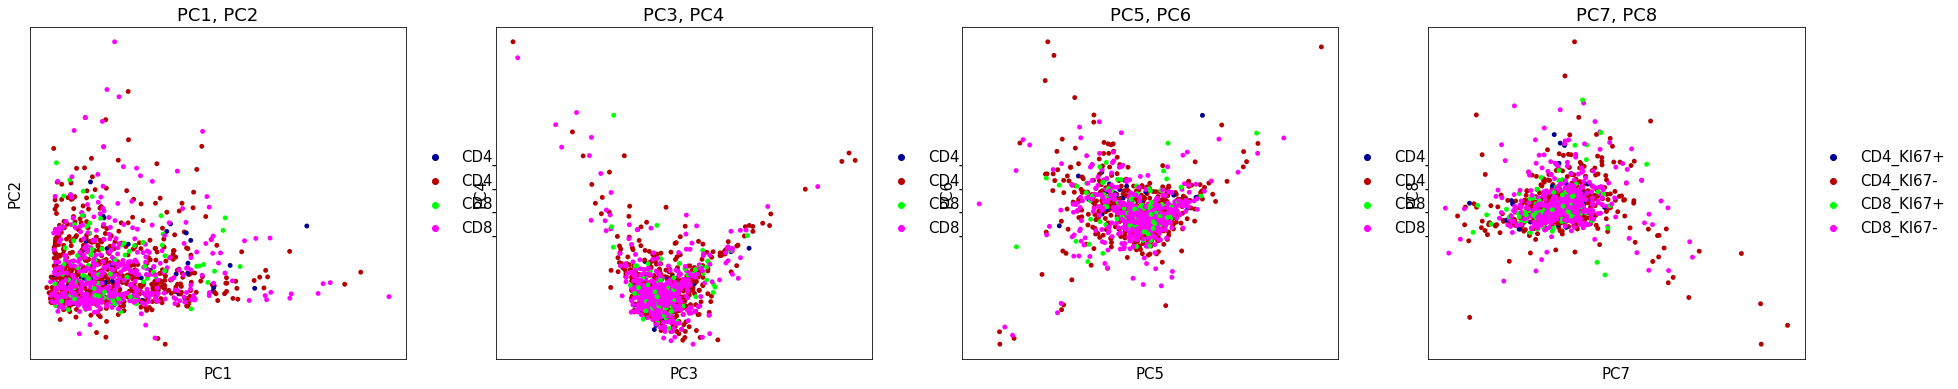

In [434]:
with rc_context({'figure.figsize':(7,6),'font.size':15}):
    sc.pl.pca(adatas['set1'], color=['Cell-KI67'], components=['1,2','3,4','5,6','7,8'],ncols=4,
              title=['PC1, PC2','PC3, PC4','PC5, PC6','PC7, PC8'], save=' set1 combined.png')

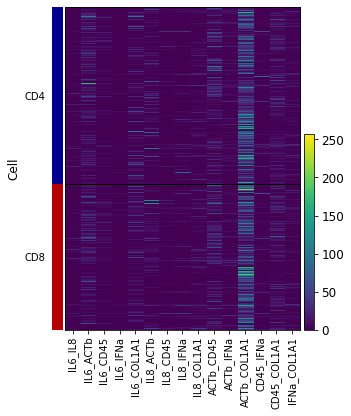

In [450]:
with rc_context({'font.size':12}):
    sc.pl.heatmap(adatas['set1'],var_names=adatas['set1'].var_names,groupby='Cell',save=' set1 cell.png')

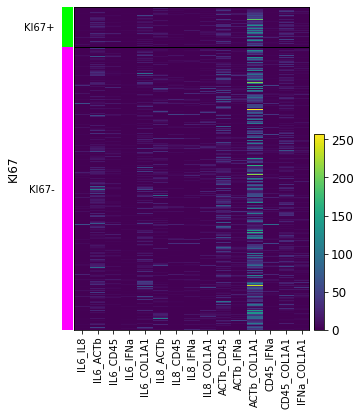

In [451]:
with rc_context({'font.size':12}):
    sc.pl.heatmap(adatas['set1'],var_names=adatas['set1'].var_names,groupby='KI67',save=' set1 ki67.png')

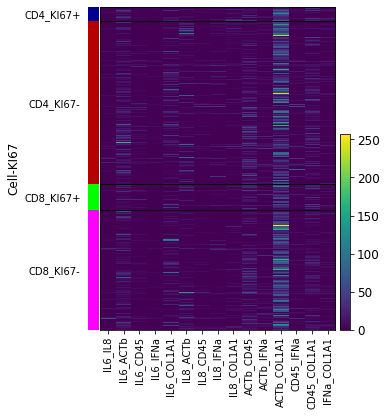

In [452]:
with rc_context({'font.size':12}):
    sc.pl.heatmap(adatas['set1'],var_names=adatas['set1'].var_names,groupby='Cell-KI67',save=' set1 combined.png')

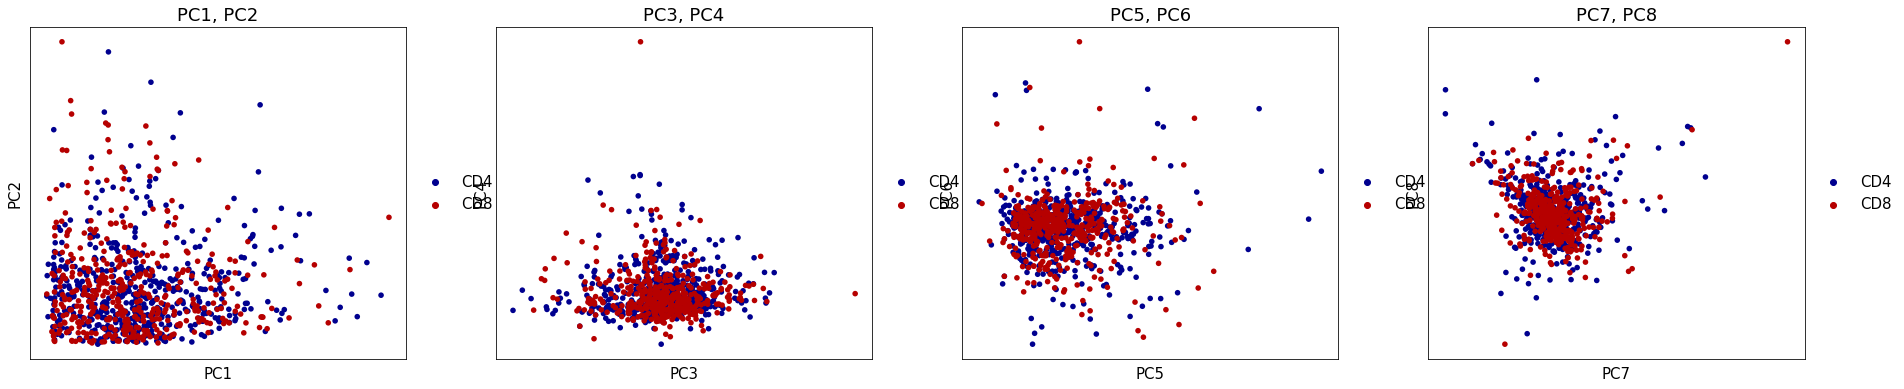

In [437]:
with rc_context({'figure.figsize':(7,6),'font.size':15}):
    sc.pl.pca(adatas['set2'], color=['Cell'], components=['1,2','3,4','5,6','7,8'],ncols=4,
              title=['PC1, PC2','PC3, PC4','PC5, PC6','PC7, PC8'], save=' set2 cell.png')

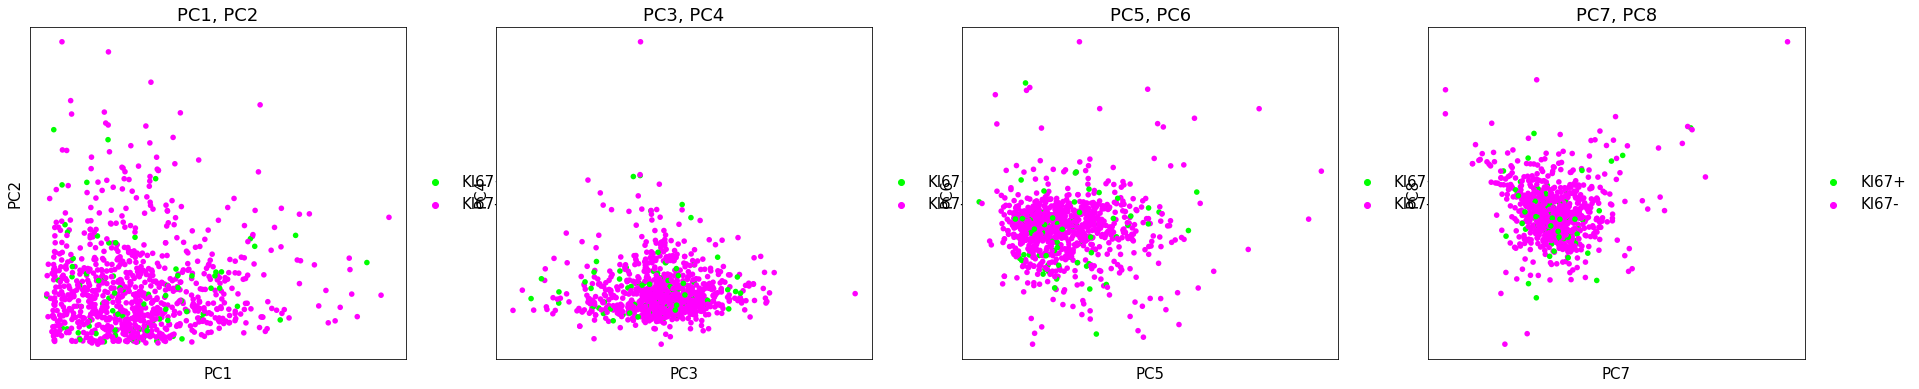

In [438]:
with rc_context({'figure.figsize':(7,6),'font.size':15}):
    sc.pl.pca(adatas['set2'], color=['KI67'], components=['1,2','3,4','5,6','7,8'],ncols=4,
              title=['PC1, PC2','PC3, PC4','PC5, PC6','PC7, PC8'], save=' set2 ki67.png')

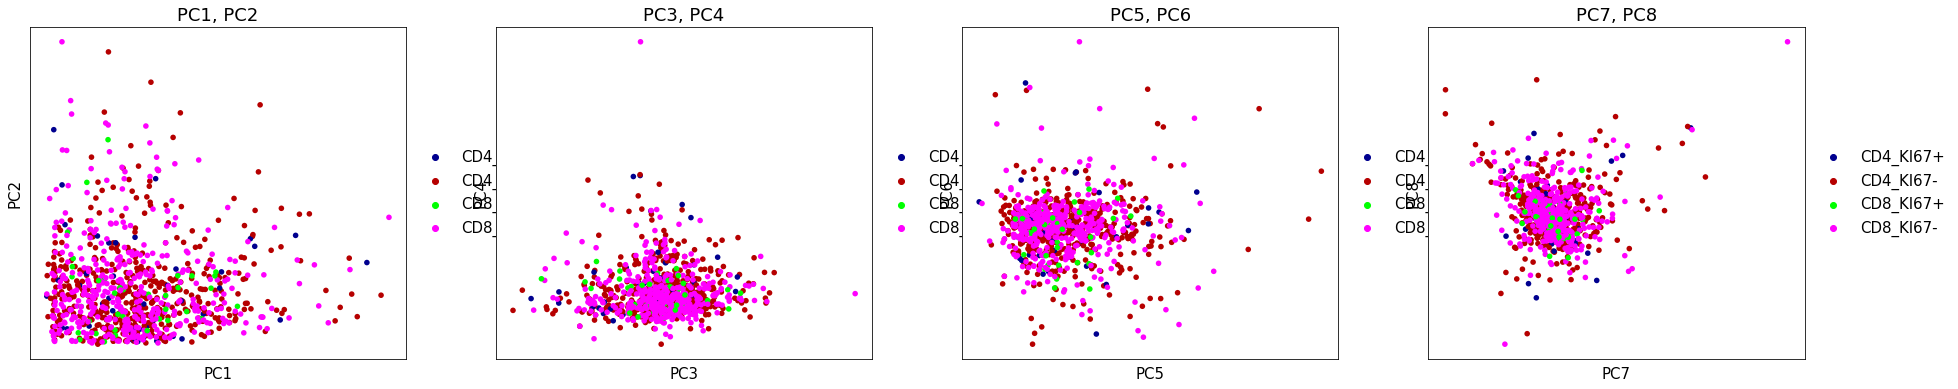

In [439]:
with rc_context({'figure.figsize':(7,6),'font.size':15}):
    sc.pl.pca(adatas['set2'], color=['Cell-KI67'], components=['1,2','3,4','5,6','7,8'],ncols=4,
              title=['PC1, PC2','PC3, PC4','PC5, PC6','PC7, PC8'], save=' set2 combined.png')

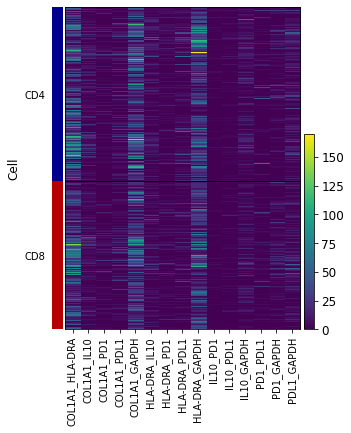

In [454]:
with rc_context({'font.size':12}):
    sc.pl.heatmap(adatas['set2'],var_names=adatas['set2'].var_names,groupby='Cell',save=' set2 cell.png')

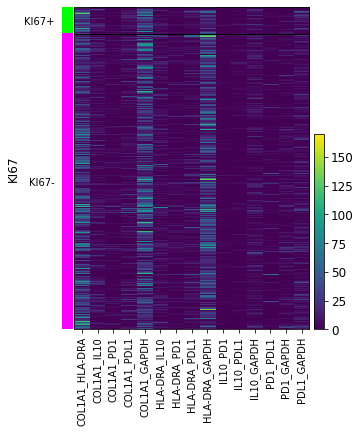

In [455]:
with rc_context({'font.size':12}):
    sc.pl.heatmap(adatas['set2'],var_names=adatas['set2'].var_names,groupby='KI67',save=' set2 ki67.png')

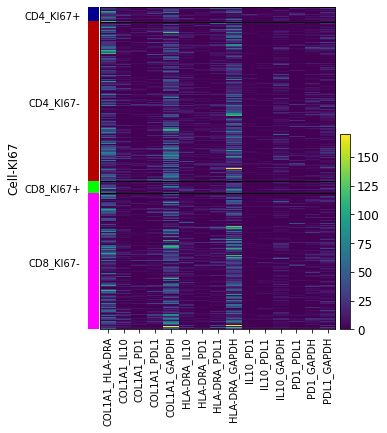

In [456]:
with rc_context({'font.size':12}):
    sc.pl.heatmap(adatas['set2'],var_names=adatas['set2'].var_names,groupby='Cell-KI67',save=' set2 combined.png')

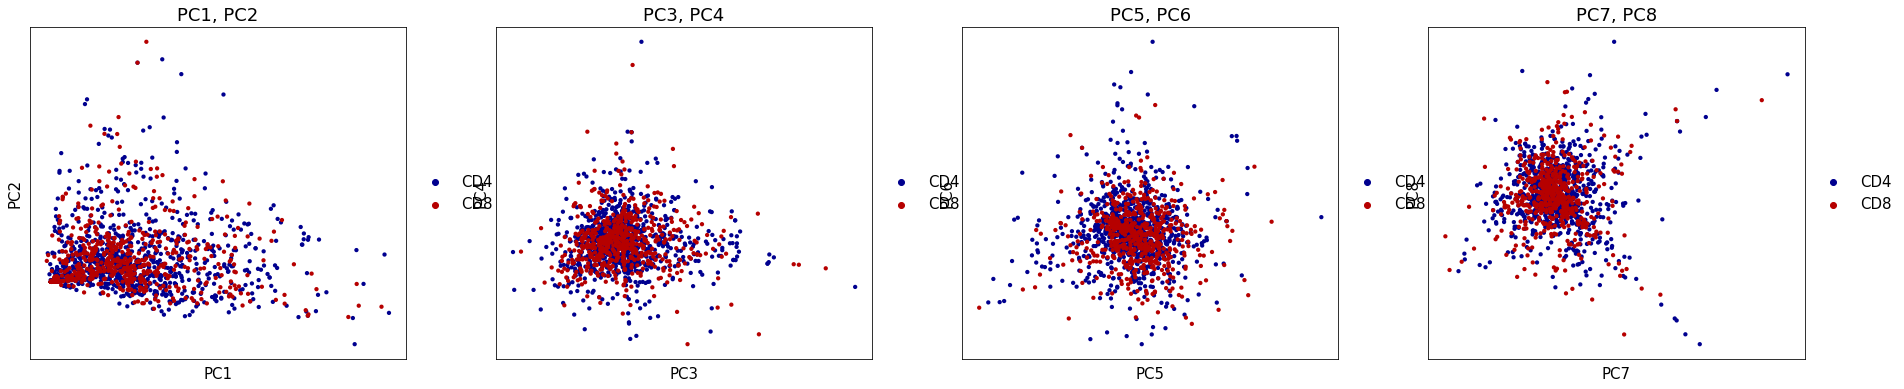

In [440]:
with rc_context({'figure.figsize':(7,6),'font.size':15}):
    sc.pl.pca(adatas['set3'], color=['Cell'], components=['1,2','3,4','5,6','7,8'],ncols=4,
              title=['PC1, PC2','PC3, PC4','PC5, PC6','PC7, PC8'], save=' set3 cell.png')

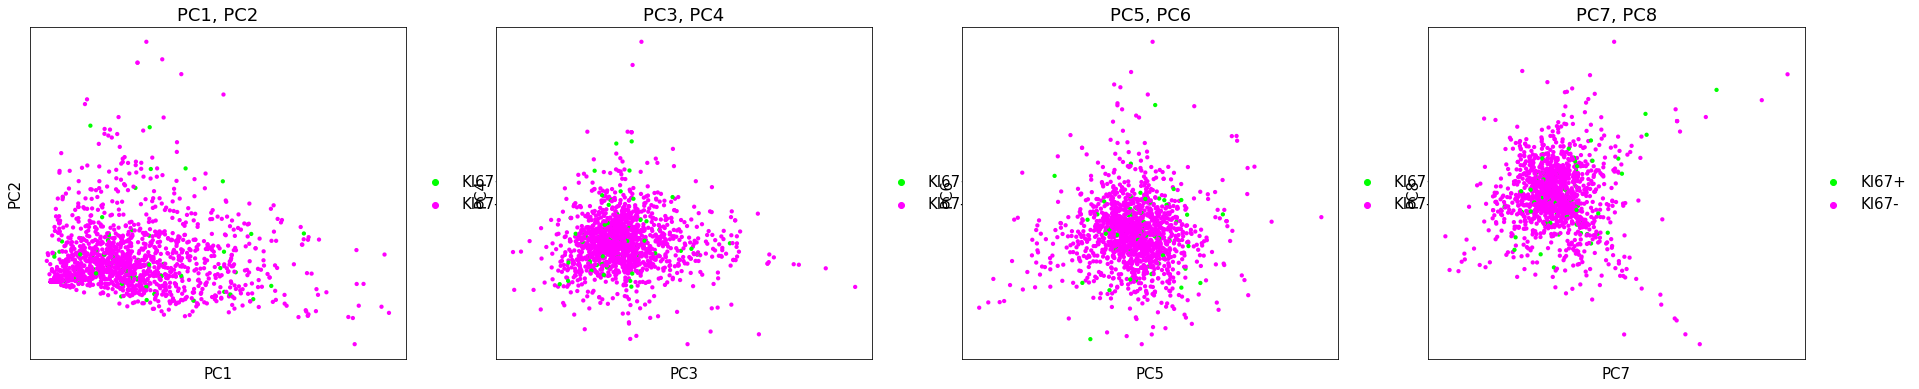

In [441]:
with rc_context({'figure.figsize':(7,6),'font.size':15}):
    sc.pl.pca(adatas['set3'], color=['KI67'], components=['1,2','3,4','5,6','7,8'],ncols=4,
              title=['PC1, PC2','PC3, PC4','PC5, PC6','PC7, PC8'], save=' set3 ki67.png')

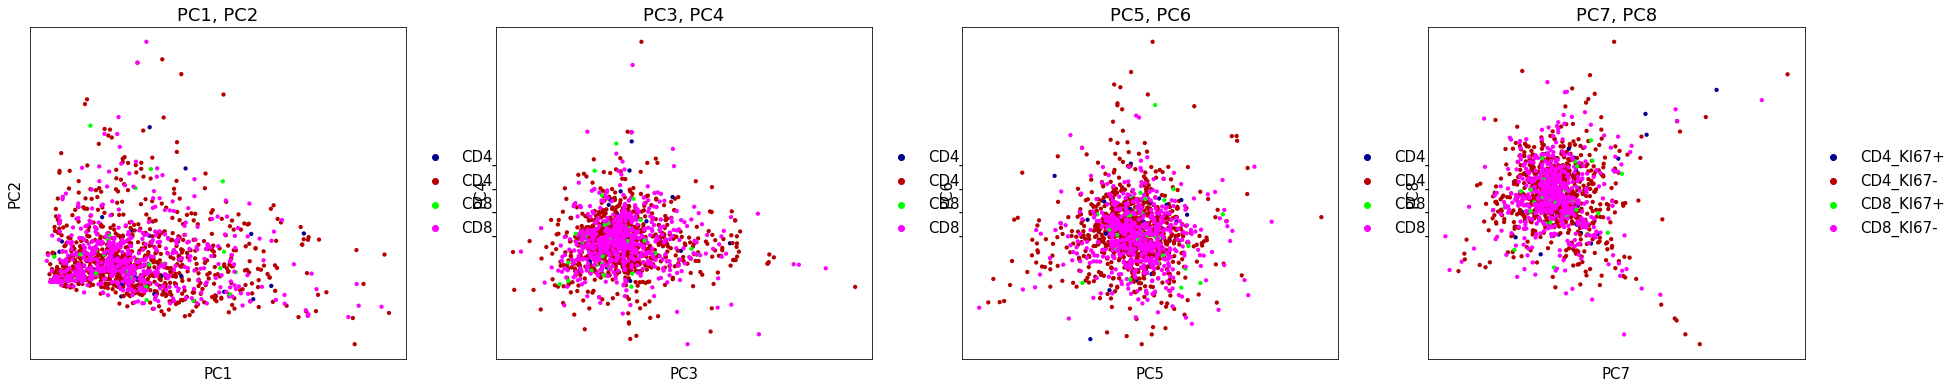

In [442]:
with rc_context({'figure.figsize':(7,6),'font.size':15}):
    sc.pl.pca(adatas['set3'], color=['Cell-KI67'], components=['1,2','3,4','5,6','7,8'],ncols=4,
              title=['PC1, PC2','PC3, PC4','PC5, PC6','PC7, PC8'], save=' set3 combined.png')

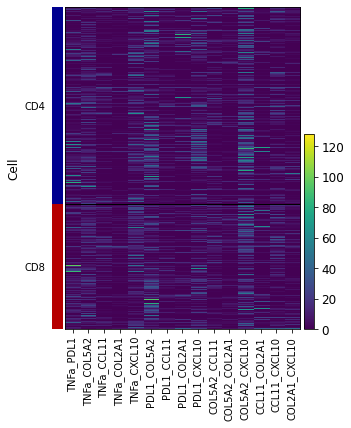

In [457]:
with rc_context({'font.size':12}):
    sc.pl.heatmap(adatas['set3'],var_names=adatas['set3'].var_names,groupby='Cell',save=' set3 cell.png')

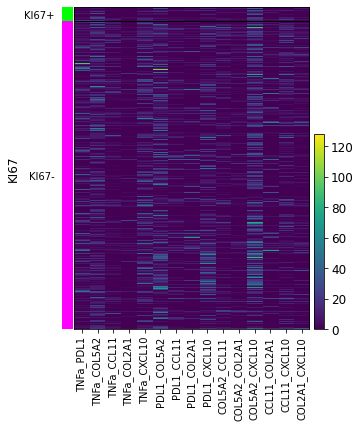

In [458]:
with rc_context({'font.size':12}):
    sc.pl.heatmap(adatas['set3'],var_names=adatas['set3'].var_names,groupby='KI67',save=' set3 ki67.png')

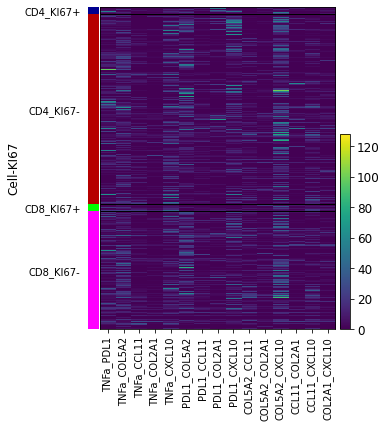

In [459]:
with rc_context({'font.size':12}):
    sc.pl.heatmap(adatas['set3'],var_names=adatas['set3'].var_names,groupby='Cell-KI67',save=' set3 combined.png')

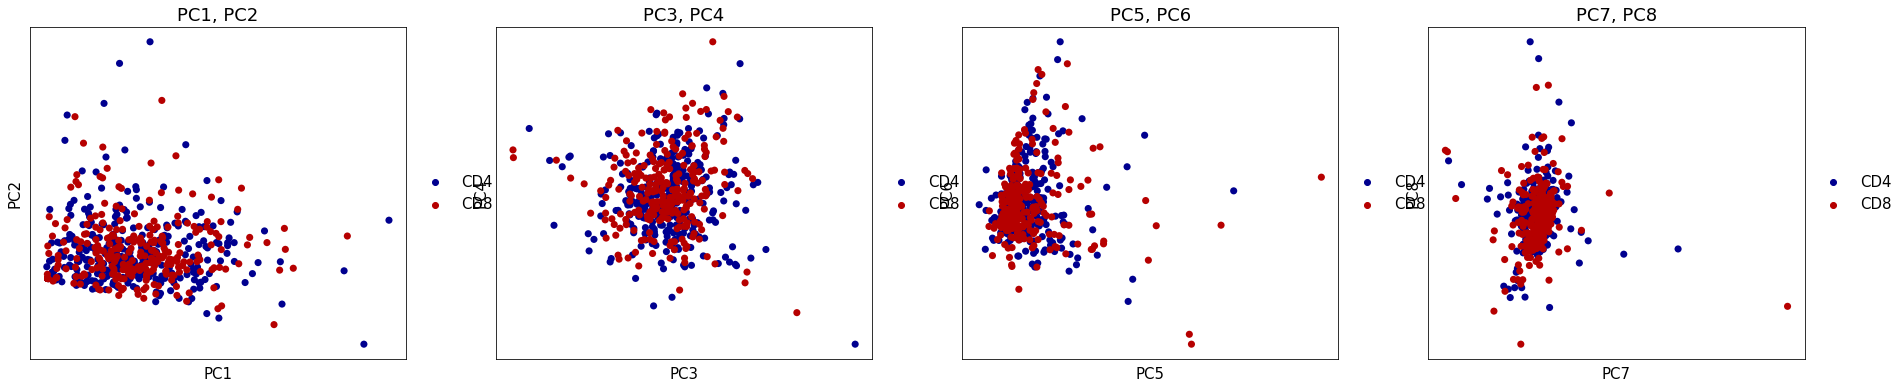

In [443]:
with rc_context({'figure.figsize':(7,6),'font.size':15}):
    sc.pl.pca(adatas['set4'], color=['Cell'], components=['1,2','3,4','5,6','7,8'],ncols=4,
              title=['PC1, PC2','PC3, PC4','PC5, PC6','PC7, PC8'], save=' set4 cell.png')

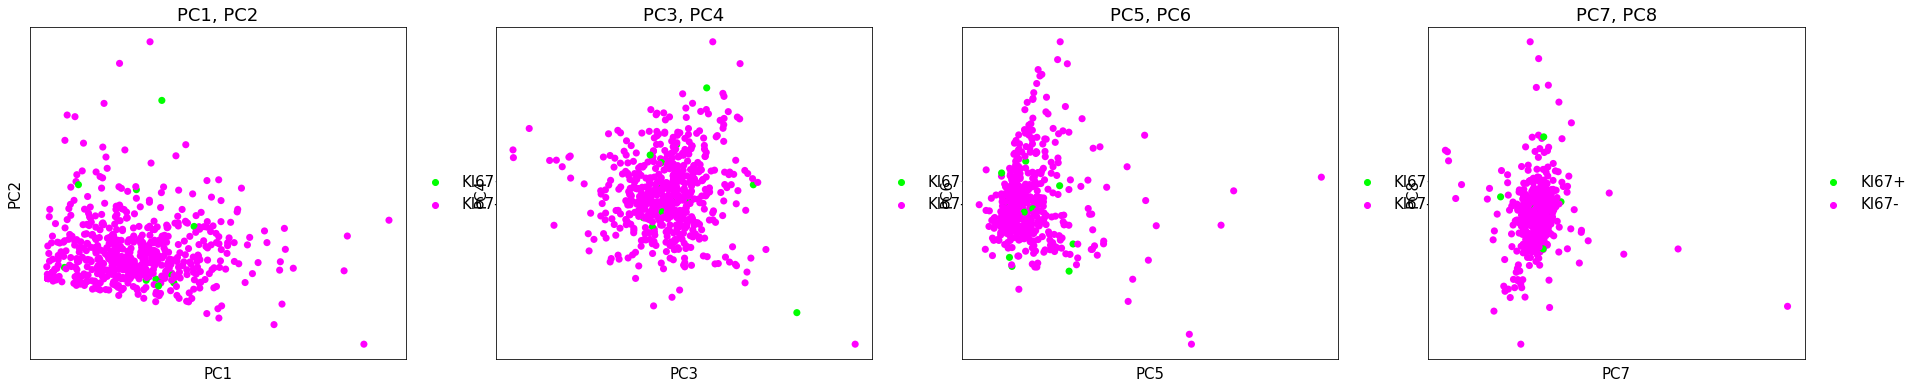

In [444]:
with rc_context({'figure.figsize':(7,6),'font.size':15}):
    sc.pl.pca(adatas['set4'], color=['KI67'], components=['1,2','3,4','5,6','7,8'],ncols=4,
              title=['PC1, PC2','PC3, PC4','PC5, PC6','PC7, PC8'], save=' set4 ki67.png')

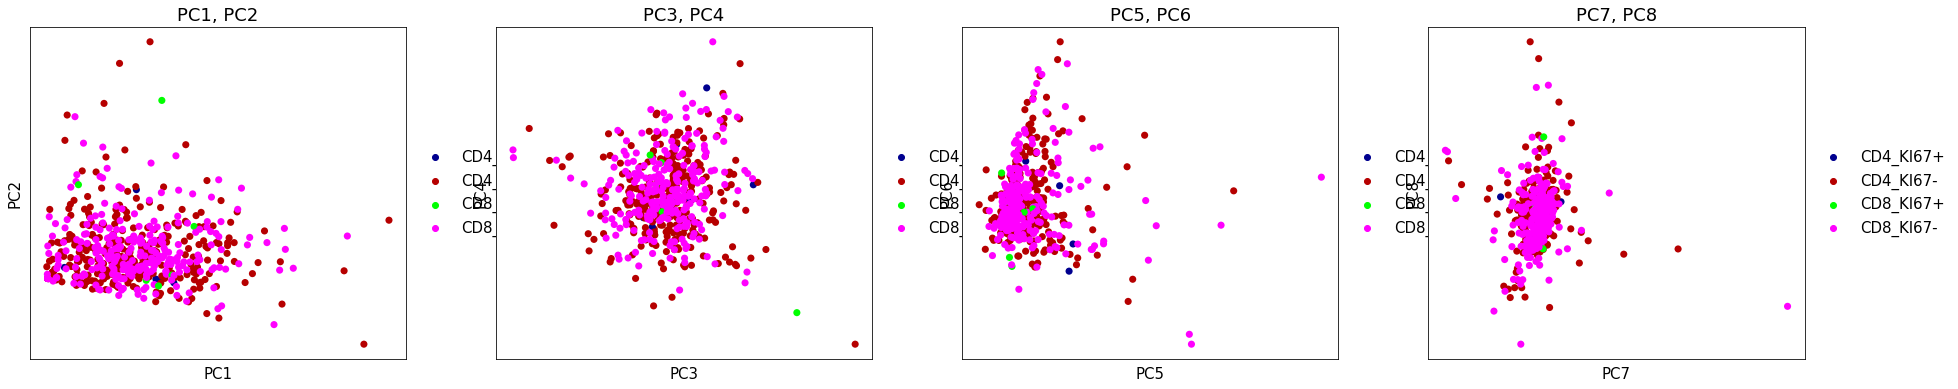

In [445]:
with rc_context({'figure.figsize':(7,6),'font.size':15}):
    sc.pl.pca(adatas['set4'], color=['Cell-KI67'], components=['1,2','3,4','5,6','7,8'],ncols=4,
              title=['PC1, PC2','PC3, PC4','PC5, PC6','PC7, PC8'], save=' set4 combined.png')

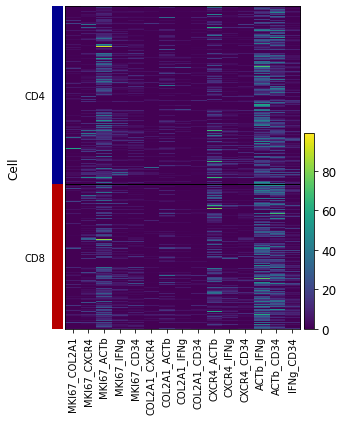

In [460]:
with rc_context({'font.size':12}):
    sc.pl.heatmap(adatas['set4'],var_names=adatas['set4'].var_names,groupby='Cell',save=' set4 cell.png')

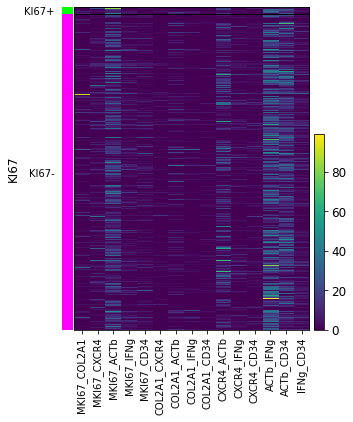

In [461]:
with rc_context({'font.size':12}):
    sc.pl.heatmap(adatas['set4'],var_names=adatas['set4'].var_names,groupby='KI67',save=' set4 ki67.png')

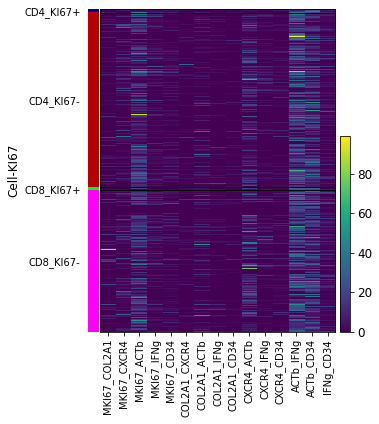

In [462]:
with rc_context({'font.size':12}):
    sc.pl.heatmap(adatas['set4'],var_names=adatas['set4'].var_names,groupby='Cell-KI67',save=' set4 combined.png')